# Model Training
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

This notebook implements the training of the final model.
- All of the model's features and values are determined through the `Model Development` notebooks.
- GPU can be used. 

The sections are as follows -
- [Load Files](#load_files)
- [Imports](#imports)
- [Data Preparation](#data_preparation)
- [Training Parameters](#training_parameters)
- [Model Parameters](#model_parameters)
- [Pre-training Visualization](#pre_viz)
- [Session I](#session_one)
- [Session II](#session_two)
- [Session III](#session_three)
- [Session IV](#session_four)
- [Session V](#session_five)
- [Combining Sessions](#comb_sessions)
- [Post-training Visualization](#post_viz)

<a id='load_files'></a>
## Load Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Loading the IEMOCAP Spectrograms, IEMOCAP Meta, network module, visualization module, and helper module into the session storage (for use in Colab).
- Additionally installing `torchmetrics`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Spectrograms.zip' 'IEMOCAP Spectrograms.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/network.zip' 'network.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/visualization.zip' 'visualization.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/helper.zip' 'helper.zip'

!unzip 'IEMOCAP Spectrograms.zip'
!unzip 'IEMOCAP Meta.zip'
!unzip 'network.zip'
!unzip 'visualization.zip'
!unzip 'helper.zip'

!pip install torchmetrics

<a id='imports'></a>
## Imports
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Importing the required functions from the network module.
> `model` - Code for model class.<br>
> `batch` - Code for batch-related operations.
<br>
> `train` - Code for training the network.

In [ ]:
import sys
sys.path.append('./network')

from network.model import ComplexNetwork
from network.batch import get_batches
from network.train import train_network

#### Step 2:
- Importing the required functions from the visualization module.
    > `explanation` - Code for conducting explanatory visualizations.<br>
    > `exploration` - Code for conducting exploratory visualizations.

In [ ]:
sys.path.append('./visualization')

from visualization.explanation import plot_train_loss, plot_train_regression, plot_train_classification
from visualization.explanation import plot_confusion_matrix, plot_per_class, plot_maps
from visualization.exploration import show_batch, plot_split

#### Step 3:
Importing the required functions from the helper module.
> `common` - Code for general-purpose functions common among all modules.<br>
> `network` - Code for general-purpose functions of network module.<br>
> `visualization` - Code for general-purpose functions of visualization module.


In [ ]:
from helper.common import save_data
from helper.network import load_data, get_emotion_num, get_classification_metric, get_regression_metric, get_criterion, get_confusion_matrix
from helper.visualization import get_dataframe, get_feature_maps

#### Step 4:
- Importing required modules from `pytorch`.
- Increasing quality of plots.

In [ ]:
import torch
import torch.optim as optim

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

<a id='data_preparation'></a>
## Data Preparation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Loading `label_data`, `split_data`, `class_data`, `scaled_vad`, `stats`, and model architecture.

In [ ]:
root = './IEMOCAP Spectrograms'
meta_root = './IEMOCAP Meta'
roots = (root, meta_root)
name = 'iemocap'

label_data = load_data(meta_root, 'Label')
split_data = load_data(meta_root, 'Split')
class_data = load_data(meta_root, 'Class')
stats = load_data(meta_root, 'Statistics')

ARCH = load_data(meta_root, 'Selected')

class_labels = dict(class_data)
class_labels.pop('Male')
class_labels.pop('Female');

In [ ]:
ARCH = {
    'input': (129, 129),
    'convolutional': [
        {'input': None, 'output': 32, 'kernel': 7, 'stride': 2, 'padding': 3},
        {'input': 32, 'output': 64, 'kernel': 5, 'stride': 1, 'padding': 2},
    ],
    'pooling': [
        {'kernel': 3, 'stride': 2},
        {'kernel': 2, 'stride': 2}
    ],
    'hidden': [
        {'input': 16384, 'output': 2048}
    ],
    'output': None,
    'pool position': [1, 2]
}

#### Step 2:
- Obtaining the number of outputs for each task.
- Defining the type of each task.
> `batch_size` - number of batches. Kept as **32**.

In [ ]:
num_outputs = [get_emotion_num(name, class_data), 2, 1, 1, 1]

tasks = ('Emotions', 'Genders', 'Valence', 'Activation', 'Dominance')
task_type = ('classification', 'classification', 'regression', 'regression', 'regression')

for i, output in enumerate(num_outputs):
    print(f'{tasks[i]}: {output}')

batch_size = 32

Emotions: 8
Genders: 2
Valence: 1
Activation: 1
Dominance: 1


#### Step 3:
Generating batches by -
- Obtaining the names of files in the train and valid sets.
- Creating train and valid batches. The data only includes the names of the files in the batches, not the inputs or labels.
- Filling the missing entries in the last batch, if any, randomly.
- Saving the batches for use during training.

> `augs_train` - augmentations to include in train set.<br>
> `augs_valid` - augmentations to include in valid set.

| Number | Augmentation Type |
| :-: | :-: |
| 1 | Original |
| 2 | Noise |
| 3 | Time Stretch |
| 4 | Pitch Shift |
| 5 | Frequency Mask |
| 6 | Time Mask |

In [ ]:
augs_train = [1, 2, 3, 4, 5, 6]
augs_valid = [1, 2, 3, 4]
data_batches, shuffled_data = get_batches(batch_size, split_data, ['train', 'valid'], num_augs = [augs_train, augs_valid])

batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Train)')

<a id='training_parameters'></a>
## Training Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Defining training parameters. Metrics selected are -
> - **Accuracy** - Computes ratio of number of samples correctly classified to total number of samples.<br>
> - **F1 Score** - Harmonic mean of precision and recall. Here, ${\beta}$ = 1 indicating equal weightage to precision and recall.<br>
> - **Root Mean Squared Error** - Measures the root of the average squared difference between the estimated values and the actual value.

- Additionally, `average_type` is the method of averaging classification metric results. The chosen methods are -
> - **macro** - This calculates the metric for each class separately, and average the metrics across classes (with equal weights for each class).<br>
> - **weighted** - This calculates the metric for each class separately, and averages the metrics across classes, weighting each class by its support (`tp` + `fn`). This is good for an imbalanced dataset.<br>
> - **none** - This calculates the metric for each class separately, and returns the metric for every class.<br>

- In this case, weighted accuracy is the same as micro accuracy and micro f1 score.

In [ ]:
metrics_macro = get_classification_metric('macro', num_emotion = num_outputs[0], num_gender = num_outputs[1])
metrics_weight = get_classification_metric('weighted', num_emotion = num_outputs[0], num_gender = num_outputs[1])
metrics_none = get_classification_metric('none', num_emotion = num_outputs[0], num_gender = num_outputs[1])

metrics_num = get_regression_metric(num_metrics = 3)

#### Step 2:
Defining loss functions (`criterion`) - 
> - **Categorical** - loss function for categorical labels is **Negative Log-likelihood Loss**. Since predictions are obtained through **Log Softmax**, they both combine to form the **Categorical Cross Entropy Loss**.<br>
> - **Numerical** - loss function for numerical labels is **Root Mean Squared Error Loss**. Predictions are obtained as activation function outputs.

In [ ]:
criterion = get_criterion(task_type)

#### Step 3:
Defining confusion matrix (for classification) -
> This is a table with that reports the number of true positives, false negatives, false positives, and true negatives.
> This allows more detailed analysis than accuracy for imbalanced dataset.

In [ ]:
confusion_matrix = get_confusion_matrix(num_emotion = num_outputs[0], num_gender = num_outputs[1])

#### Step 4:
Packing the training parameters.
> **Min-Max Scaler** - Each value is transformed using $\frac{\text{x} \text{ - } \text{min}}{\text{max} \text{ - } \text{min}}$. <br>
> **Epochs** - Training for the first 10 epochs.

In [ ]:
epoch_size = 10
epochs = (0, epoch_size)

torch_params = {'criterion': criterion, 'metrics weight': metrics_weight, 'metrics macro': metrics_macro, 'metrics none': metrics_none,
                'metrics num': metrics_num, 'conf matrix': confusion_matrix}
other_params = {'scaling type': stats['scaling type'], 'task type': task_type, 'epochs': epochs, 'batch size': batch_size}

scaling_type = stats['scaling type']
print(f"Scaling Type - '{scaling_type}'")

Scaling Type - 'min-max'


<a id='model_parameters'></a>
## Model Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Obtaining the input normalization transform. Each channel is transformed using $\frac{\text{channel input} \text{ - } \text{channel mean}}{\text{channel std}}$.
> `color_map` - color map for images.<br>
> `channel_mean` - mean for each channel.<br>
> `channel_std` - standard deviation for each channel.

In [ ]:
channel_mean, channel_std, color_map = stats['channel mean'], stats['channel std'], stats['color map']

transforms = [channel_mean, channel_std, color_map]
print(f'Channel Mean - {transforms[0]} | Channel Std - {transforms[1]} | Color Map - {transforms[2]}')

Channel Mean - [0.2746834032590987] | Channel Std - [0.17490942513599714] | Color Map - L


#### Step 2:
Assigning the model's input and output size.

In [ ]:
all_transforms = [ARCH['input']]
all_transforms.extend(transforms)
ARCH['output'] = num_outputs
ARCH['convolutional'][0]['input'] = 1 if color_map == 'L' else 3

#### Step 2:
- Defining the parameters -
> `layer_params` - parameters for the layers of the network.<br>
> `optim_params` - parameters for the optimizer.<br>
> `multi_params` - parameters for the multitask network.

| Layer Parameters | Optimizer Parameters | Multitask Parameters |
| :-: | :-: | :-: |
| Activation - ReLU | Learning Rate - 0.01 | Loss Type - weighted param |
| Pooling - MaxPool | Type - SGD | Loss Weights - None |
| Dropout - 0.8 | Momentum - 0 | Task Layers - None | 
| Batch Norm - False | Weight Decay - 0 |
| Attention - 0.0001 | Scheduler - ([10], 0.8) |
| Weight Init - False |

In [ ]:
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.8, 'batch norm': False, 
    'attention': 0.0001, 'weight init': False
               }

optim_params = {'learning rate': 0.01, 'type': 'sgd', 'momentum': 0, 'weight decay': 0}

#### Step 3:
- Defining the model and optimizer.
- Defining the scheduler for learning-rate decay.
> `milestones` - epochs at which the decay occurs.<br>
> `gamma` - percentage by which learning-rate is decayed.

In [ ]:
model = ComplexNetwork(ARCH, layer_params, multitask_params, task_type)
optimizer = optim.SGD(model.parameters(), lr = optim_params['learning rate'], momentum = optim_params['momentum'],
                      weight_decay = optim_params['weight decay'])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)
model_params = (model, optimizer, all_transforms, scheduler)

<a id='pre_viz'></a>
## Pre-training Visualization
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Plotting label distribution across split data.

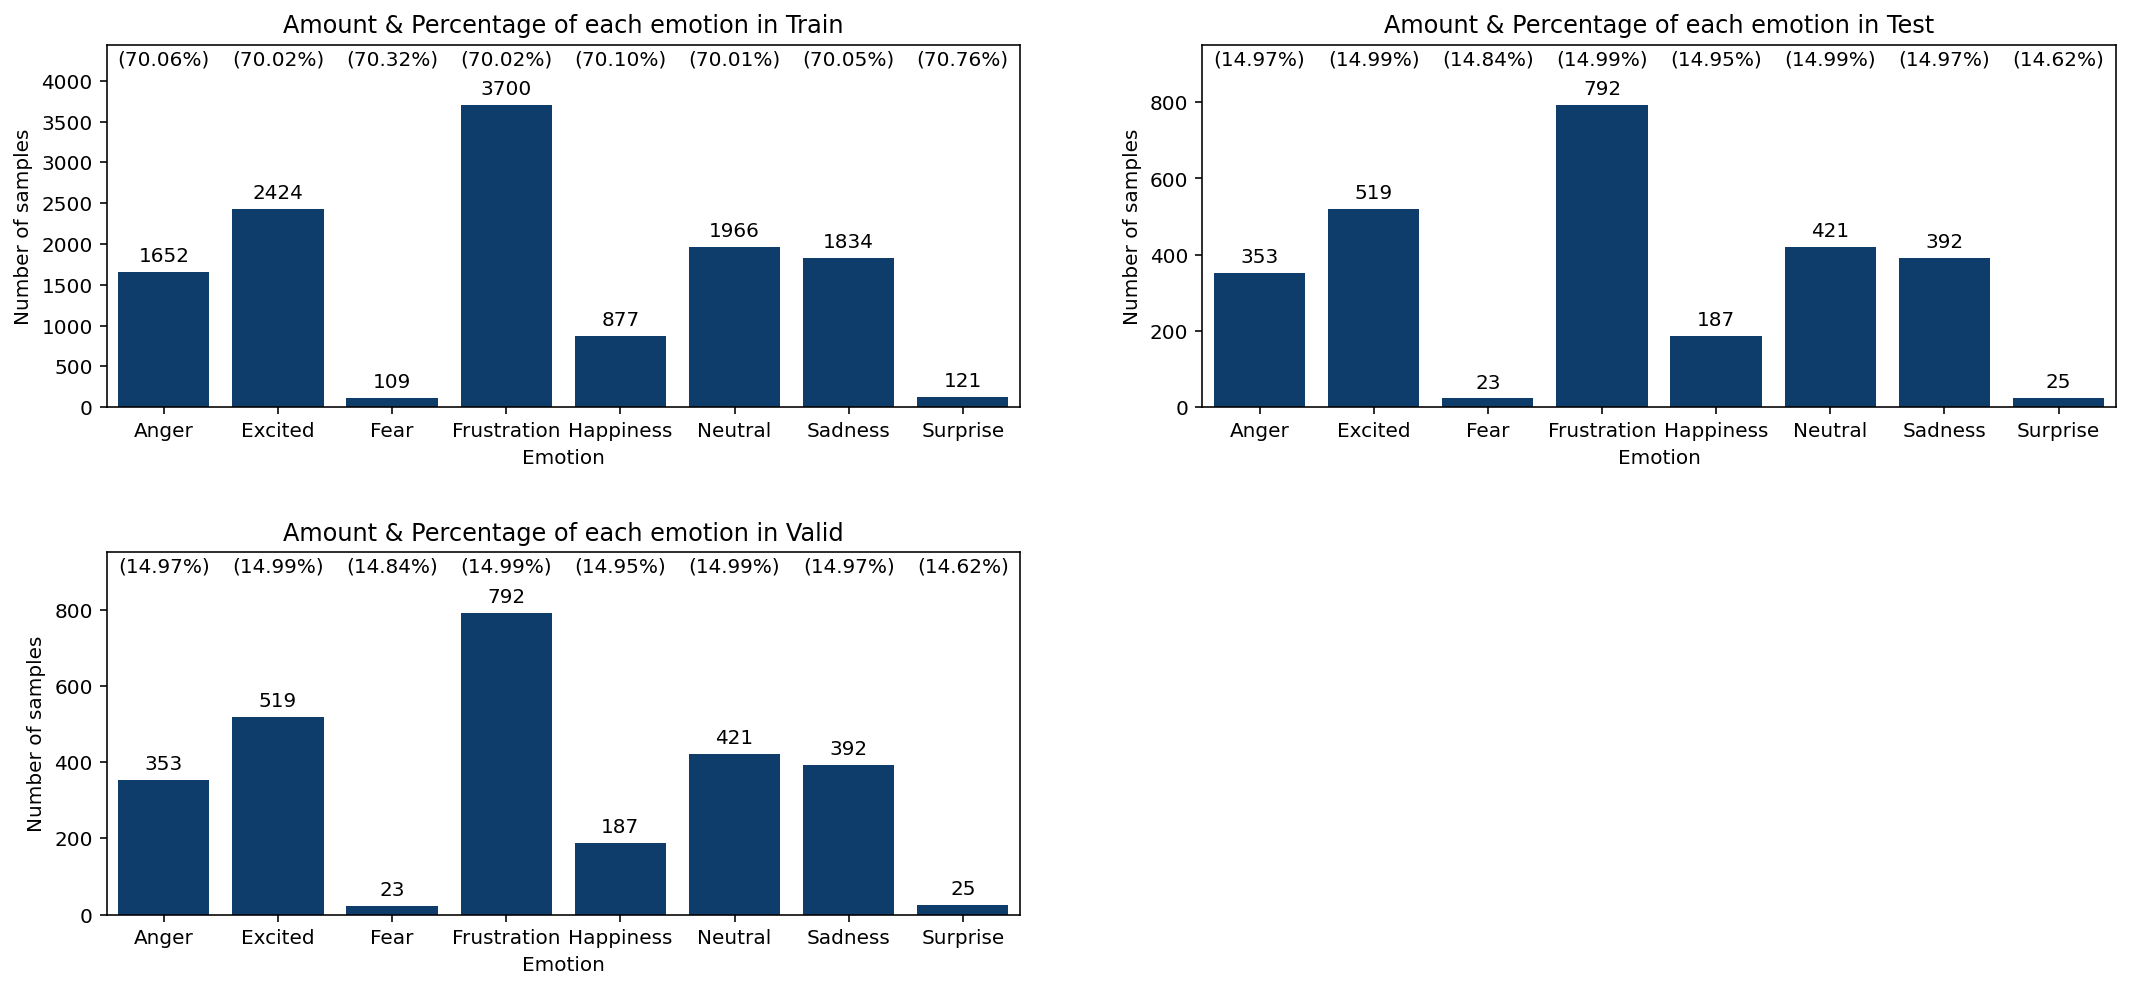

In [ ]:
label_df = get_dataframe(label_data, name, 'label')
plot_split(split_data, label_df, label_data, list(class_labels.keys()))

#### Step 2:
Calculating the size of the data.

In [ ]:
num_train = len(split_data['train'])
num_valid = len(split_data['valid'])
print(f'Number of training samples = {num_train} * 1 = {num_train * 1}')
print(f'Number of validation samples = {num_valid} * 1 = {num_valid * 1}')

Number of training samples = 12683 * 1 = 12683
Number of validation samples = 2712 * 1 = 2712


#### Step 3:
Visualizing the batch samples.

In [ ]:
img_size = ARCH['input']
train_batches, valid_batches = data_batches
shuffled_train, shuffled_valid = shuffled_data

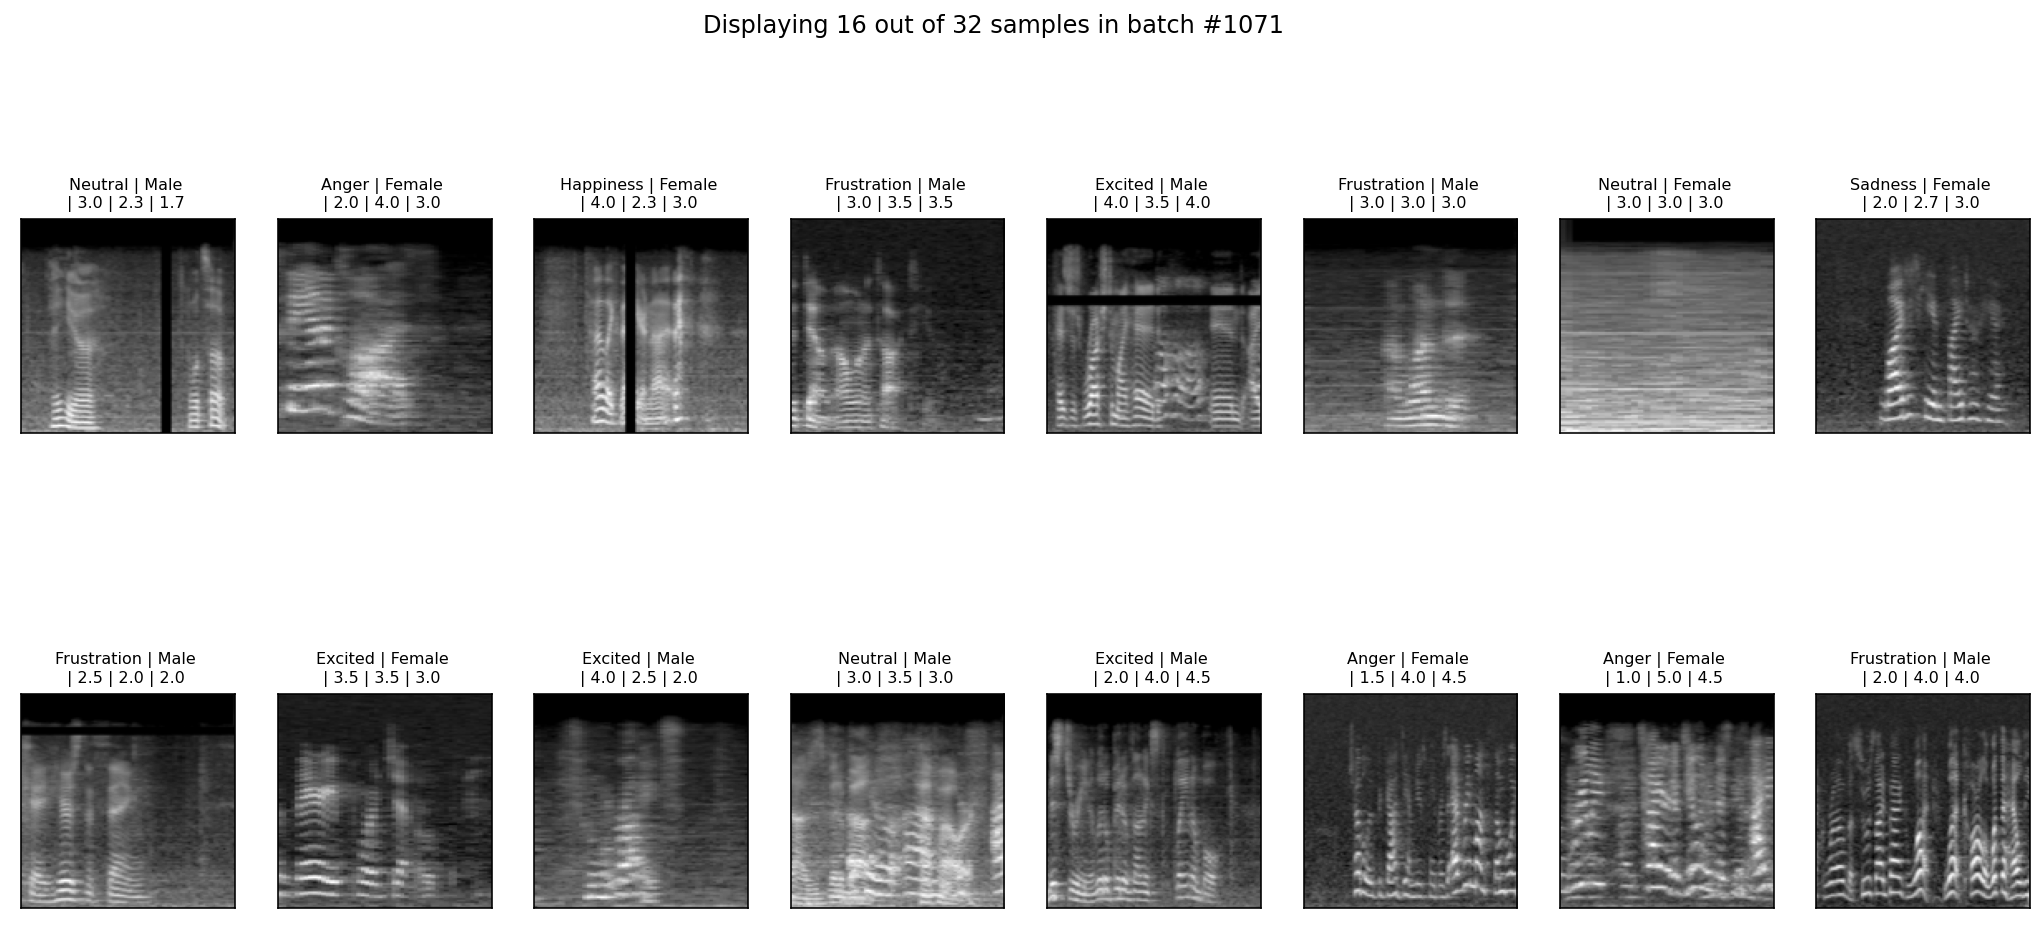

In [ ]:
batch_data = ('train', shuffled_train, train_batches, batch_size)
show_batch(root, name, label_data, batch_data, color_map, img_size = img_size, num_samples = 16)

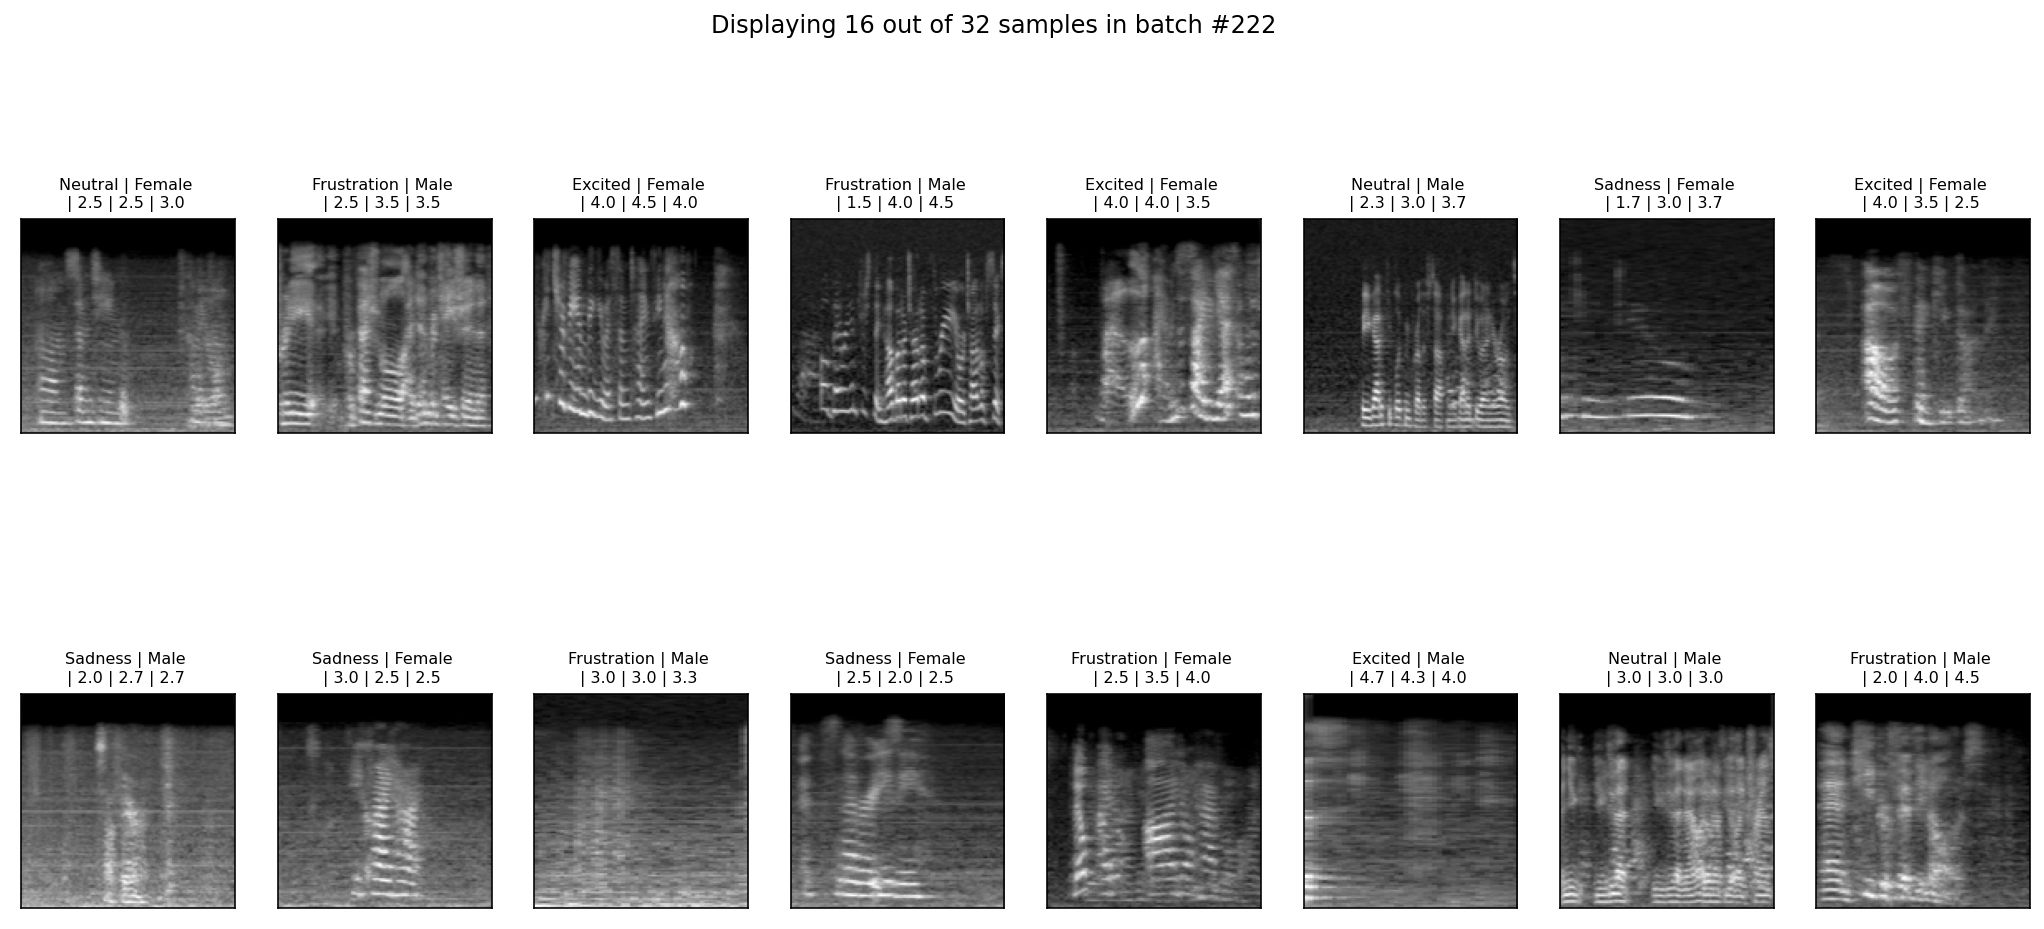

In [ ]:
batch_data = ('valid', shuffled_valid, valid_batches, batch_size)
show_batch(root, name, label_data, batch_data, color_map, img_size = img_size, num_samples = 16)

<a id='session_one'></a>
## Session I
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- Due to long training times, training of the model will be divided into sessions of **10 epochs** each.

- `train_network` performs training and validation of the model -
> - In each epoch, batch is loaded and transformations are applied.
> - Before normalization, each image is resized and converted to a tensor.
> - Numerical predictions and labels are scaled back to original values before being fed to their corresponding metric.

- After completion of training for set number of epochs, data pertaining to model, optimizer, and scheduler is saved in `Checkpoint-{checkpoint_num}.pt`.
- The model with the lowest validation loss is saved in `Best.pt`.

> `checkpoint_num` - number indicating which training session is being run.

#### Step 1:
Training the model.

In [ ]:
checkpoint_num = 1
train_network(roots, model_params, torch_params, other_params, checkpoint_num)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

#### Step 2:
Loading the model data.

In [ ]:
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt', map_location=torch.device('cpu'))
best_model = torch.load(f'{meta_root}/Best.pt', map_location=torch.device('cpu'))
best_epoch = best_model['current epoch'] - epoch_size*(checkpoint_num - 1)

#### Step 3:
Plotting the loss curves of the trained model with a marker of the current best model.

Epoch Range = 0 to 10
Session-1 | Training Duration = 5073.36 sec | Average Duration = 507.34 sec


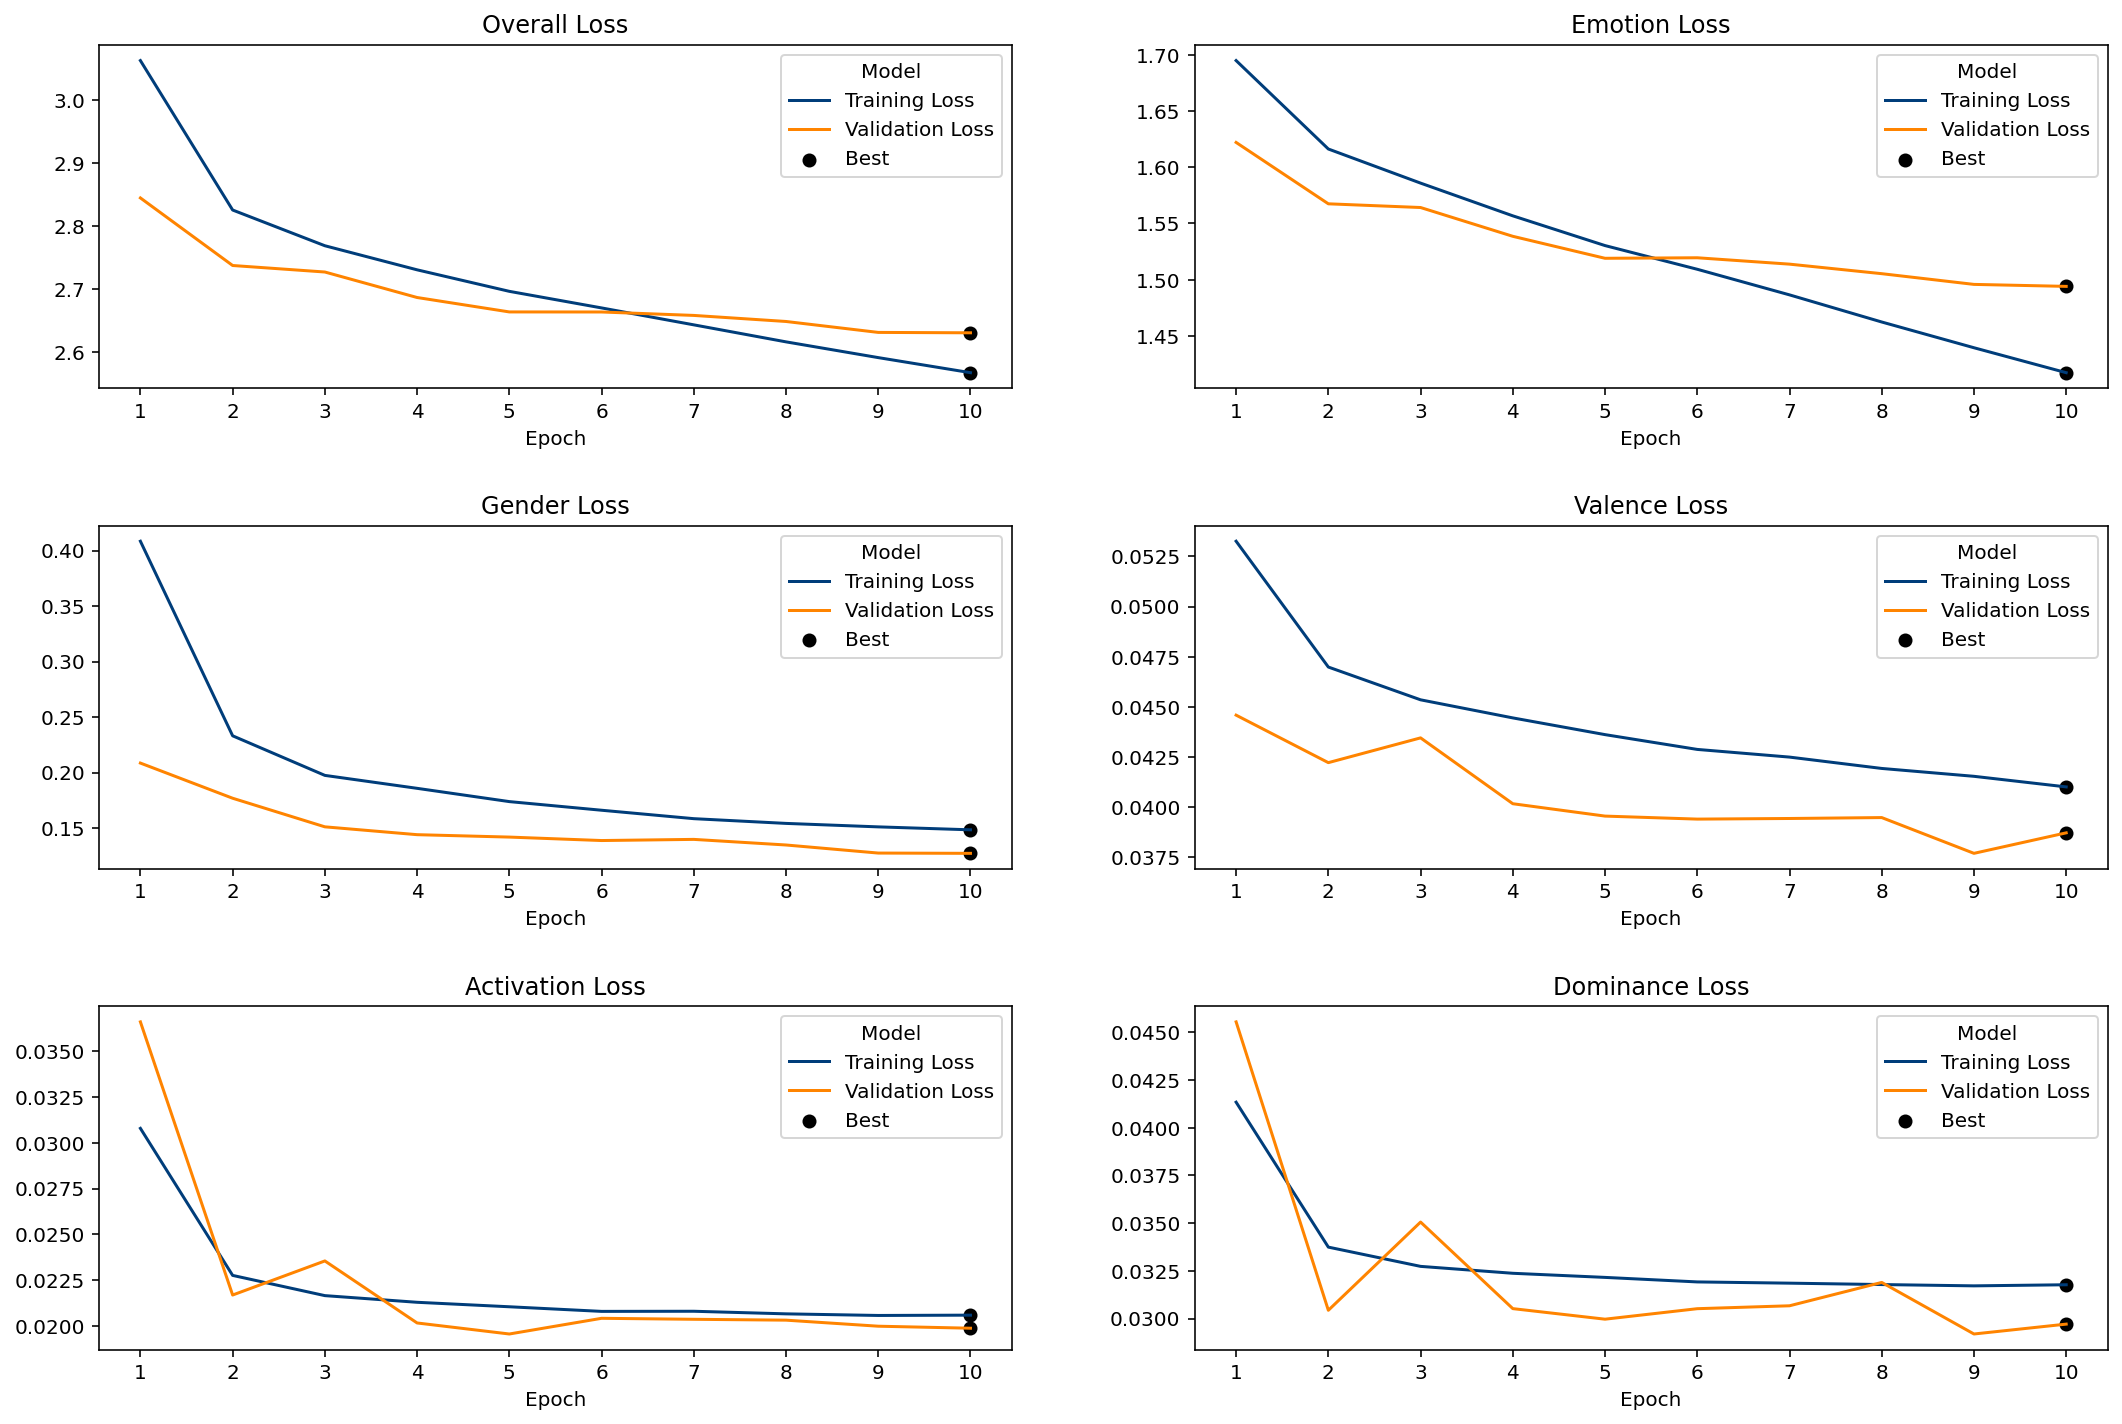

In [ ]:
plot_train_loss(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 4:
Plotting the classification metrics.
> `average` - weighted and macro.

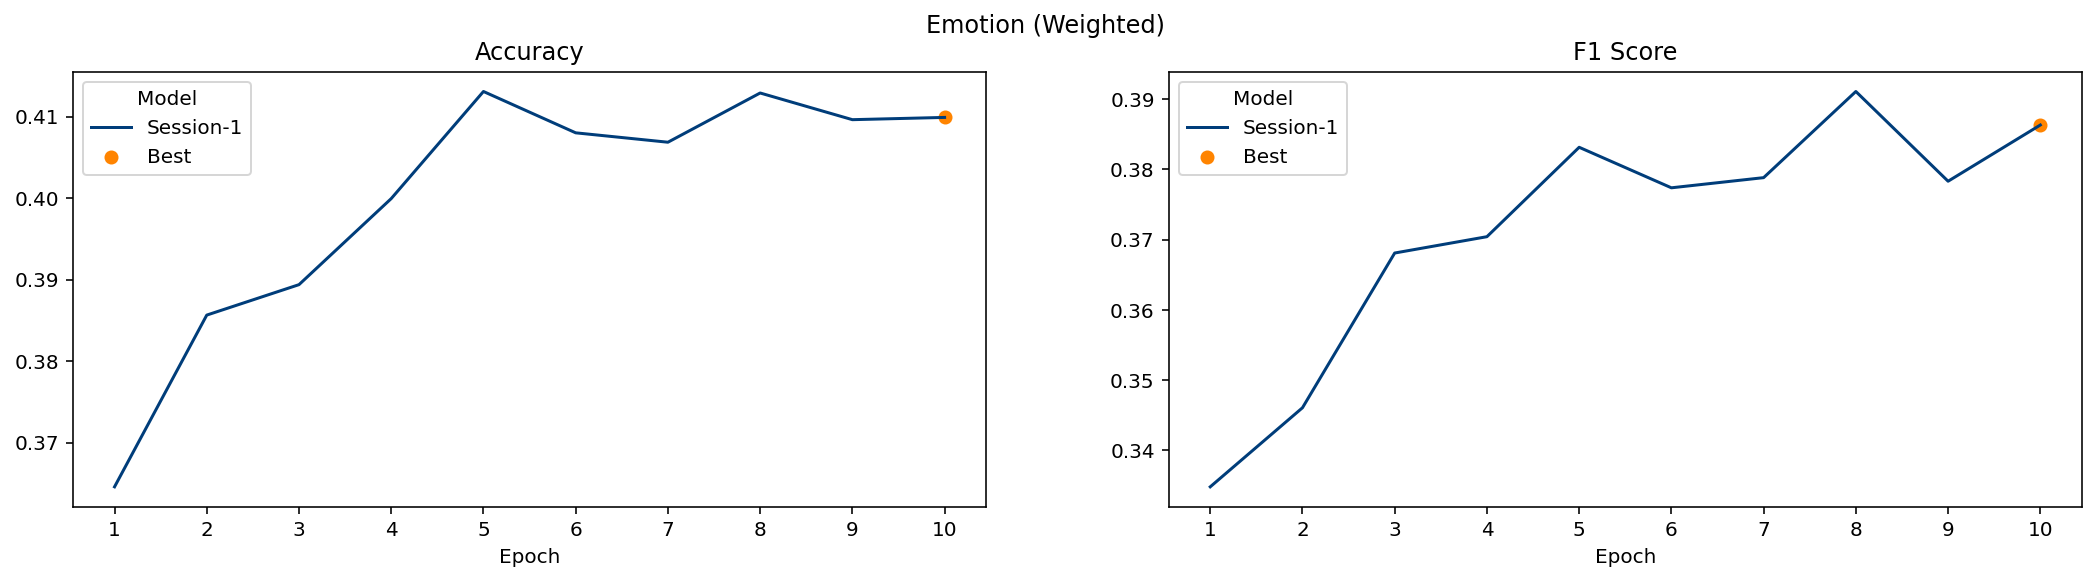

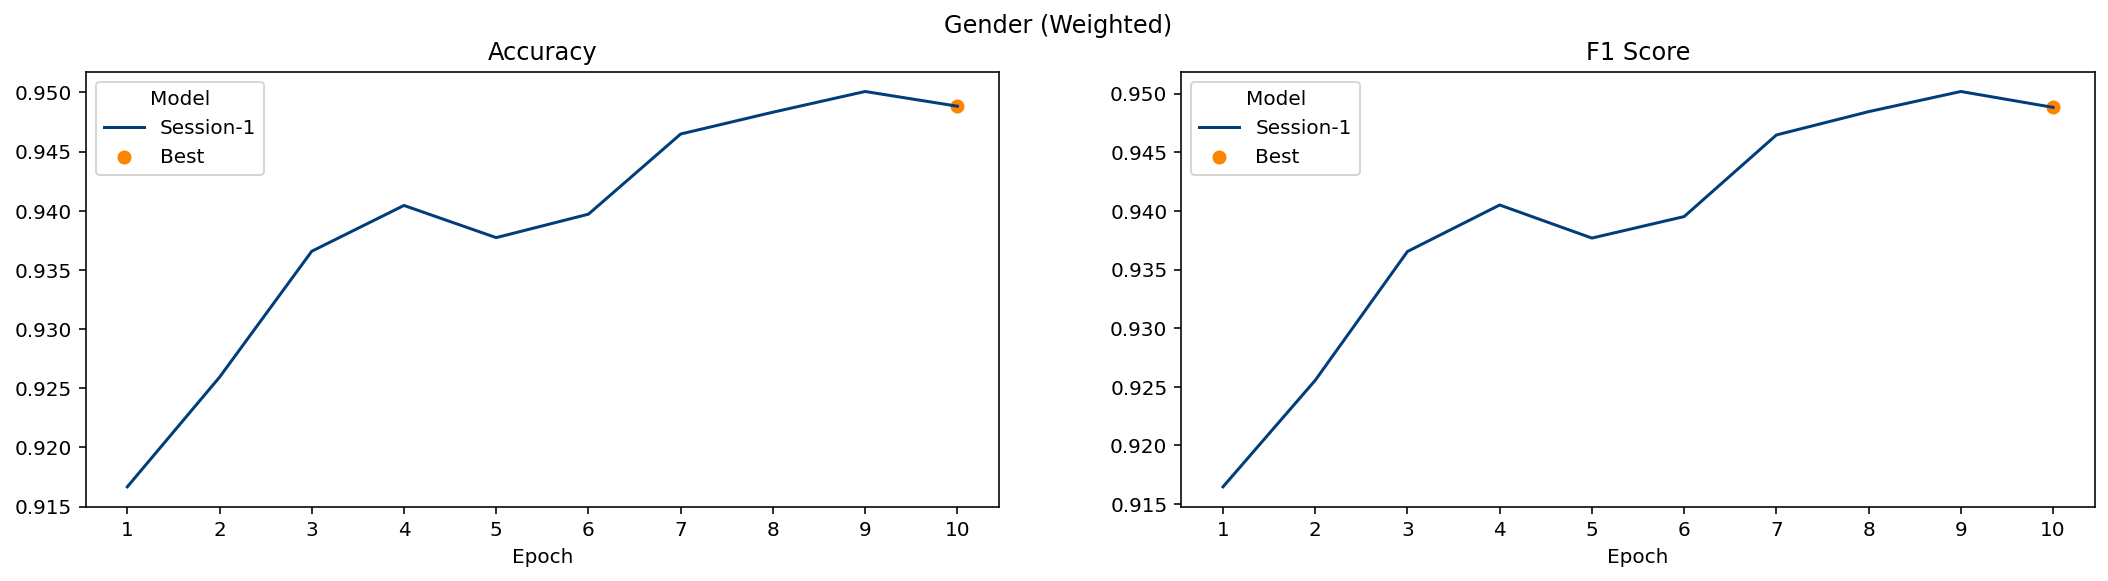

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'weighted', x_jump = 1)

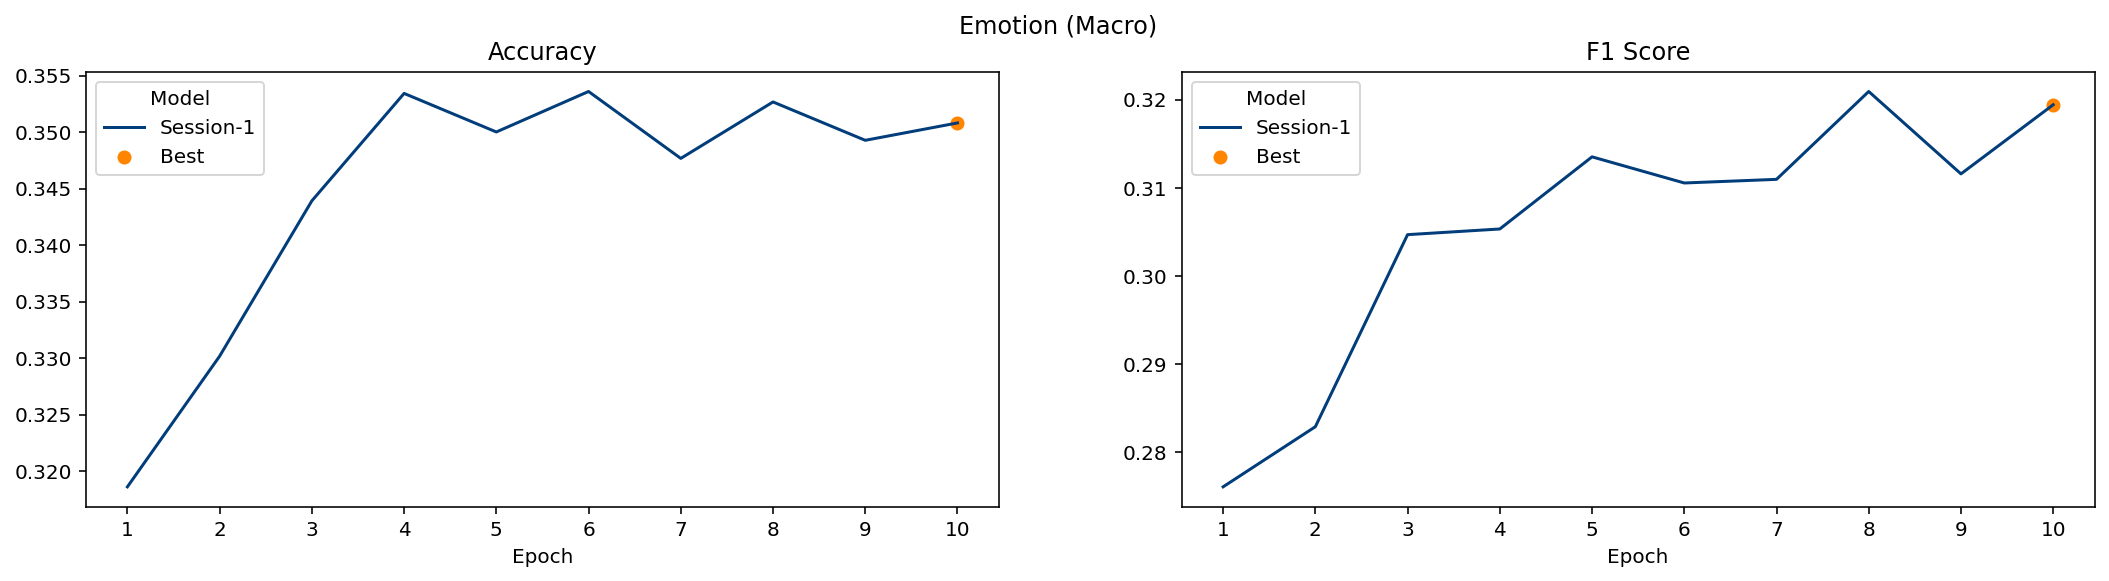

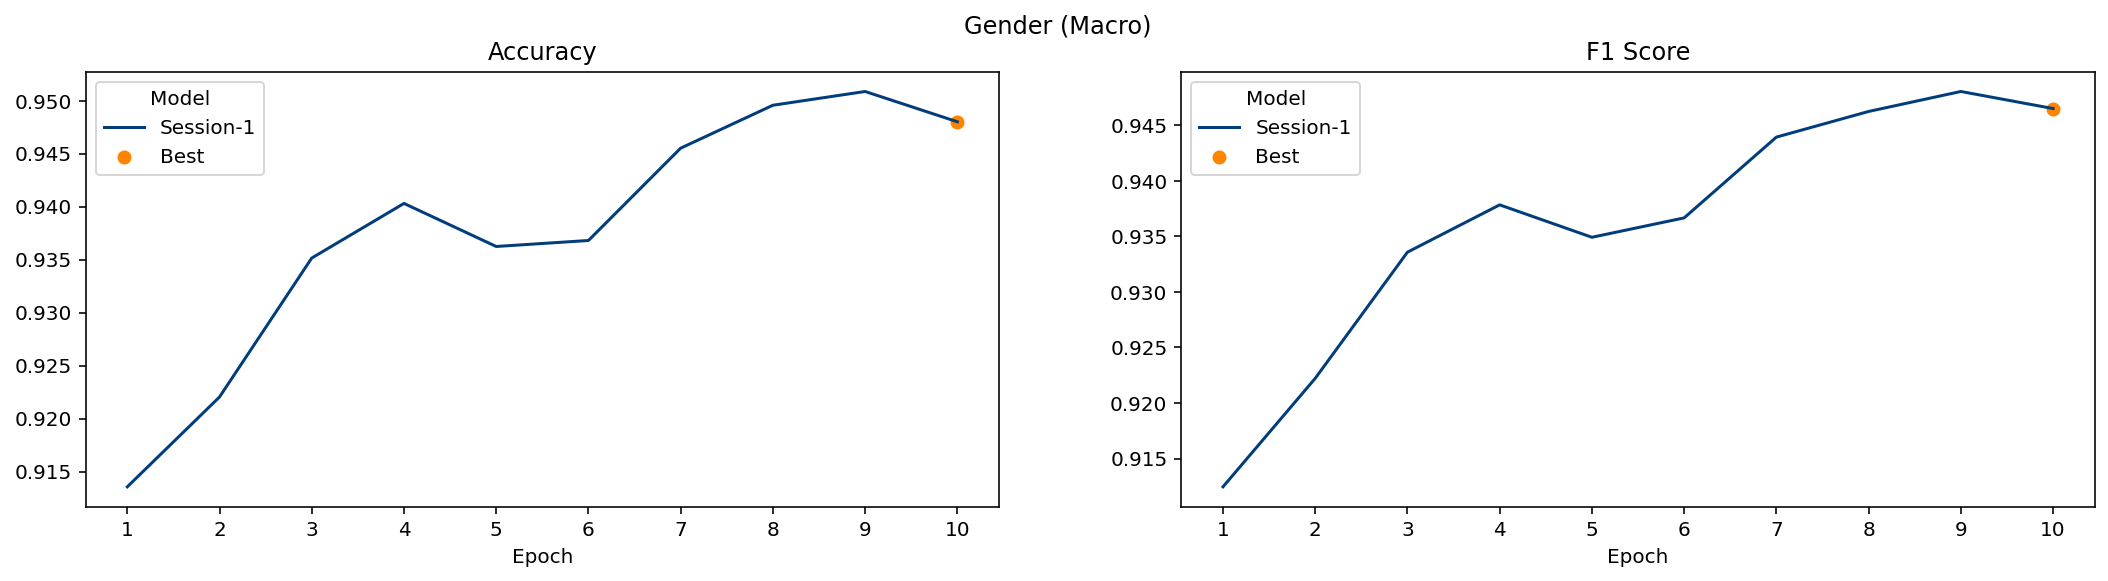

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'macro', x_jump = 1)

#### Step 5:
Plotting the regression metrics.

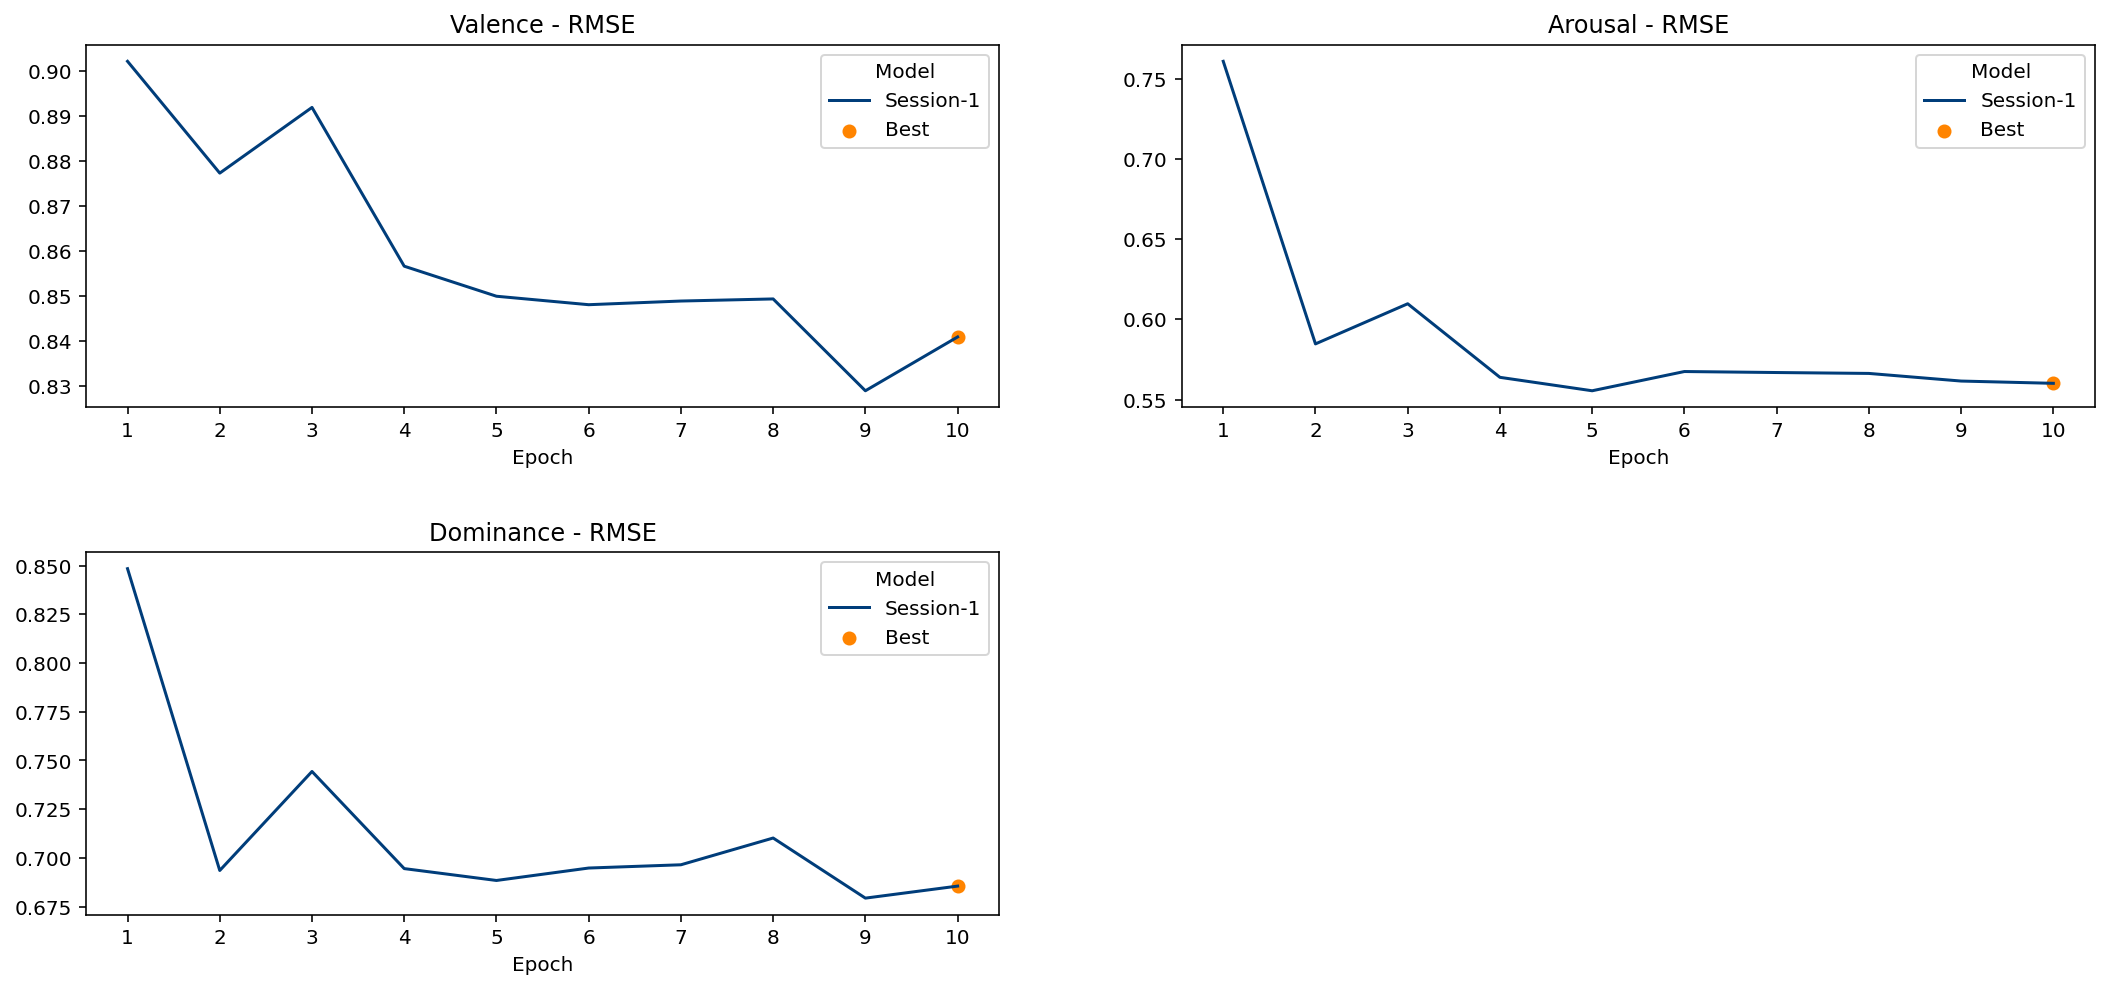

In [ ]:
plot_train_regression(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 6:
Saving the checkpoint and current best model.

In [ ]:
!zip -r 'IEMOCAP Meta.zip' 'IEMOCAP Meta'
!cp 'IEMOCAP Meta.zip' '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip'

<a id='session_two'></a>
## Session II
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- Before starting this section, run all cells from `Load Files` to `Model Parameters`, excluding -
  - Step 3 of Data Preparation.
  - Step 3 of Model Parameters.

- Load the checkpoint states into model, optimizer, and scheduler.

In [ ]:
checkpoint_num = 1
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')

epochs = (checkpoint['next epoch'], checkpoint['next epoch'] + epoch_size)
other_params['epochs'] = epochs

In [ ]:
model = ComplexNetwork(ARCH, layer_params, multitask_params, task_type)
optimizer = optim.SGD(model.parameters(), lr = optim_params['learning rate'], momentum = optim_params['momentum'],
                      weight_decay = optim_params['weight decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

model_params = (model, optimizer, all_transforms, scheduler)

#### Step 1:
Training the model.

In [ ]:
checkpoint_num = 2
train_network(roots, model_params, torch_params, other_params, checkpoint_num)

IntProgress(value=10, description='Epoch - 10 / 20', layout=Layout(width='500px'), max=20, min=10, style=Progr…

#### Step 2:
Loading the model data.

In [ ]:
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')
best_model = torch.load(f'{meta_root}/Best.pt')
best_epoch = None
if best_model['current epoch'] >= epochs[0]:
  best_epoch = best_model['current epoch'] - epoch_size*(checkpoint_num - 1)

#### Step 3:
Plotting the loss curves of the trained model with a marker of the current best model.

Epoch Range = 10 to 20
Session-2 | Training Duration = 5475.42 sec | Average Duration = 547.54 sec


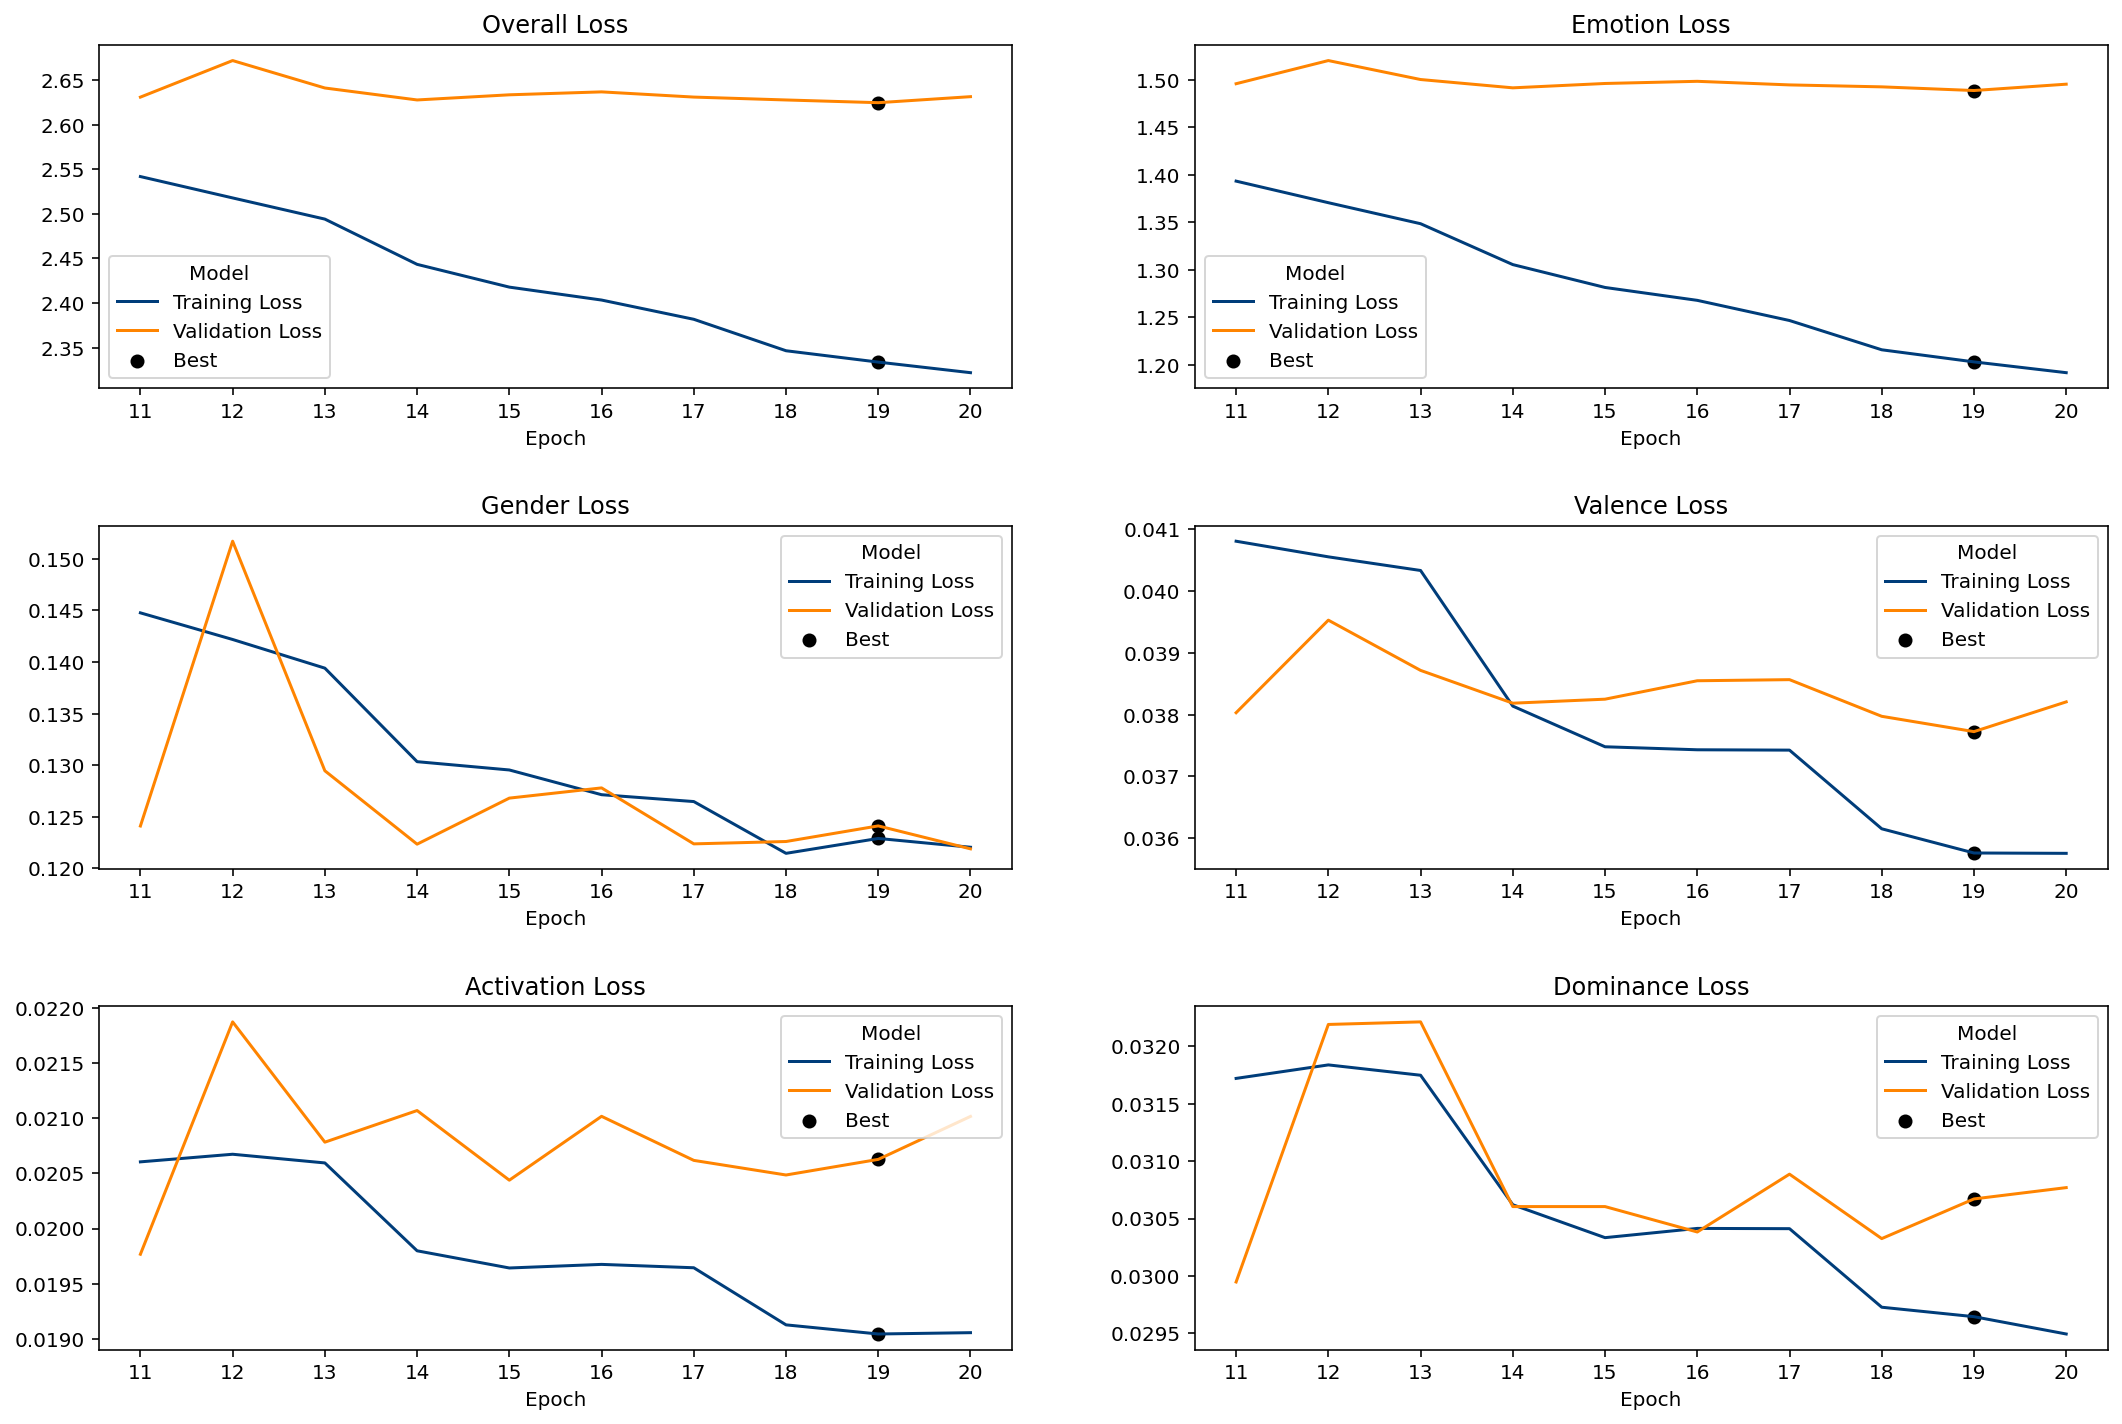

In [ ]:
plot_train_loss(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 4:
Plotting the classification metrics.
> `average` - weighted and macro.

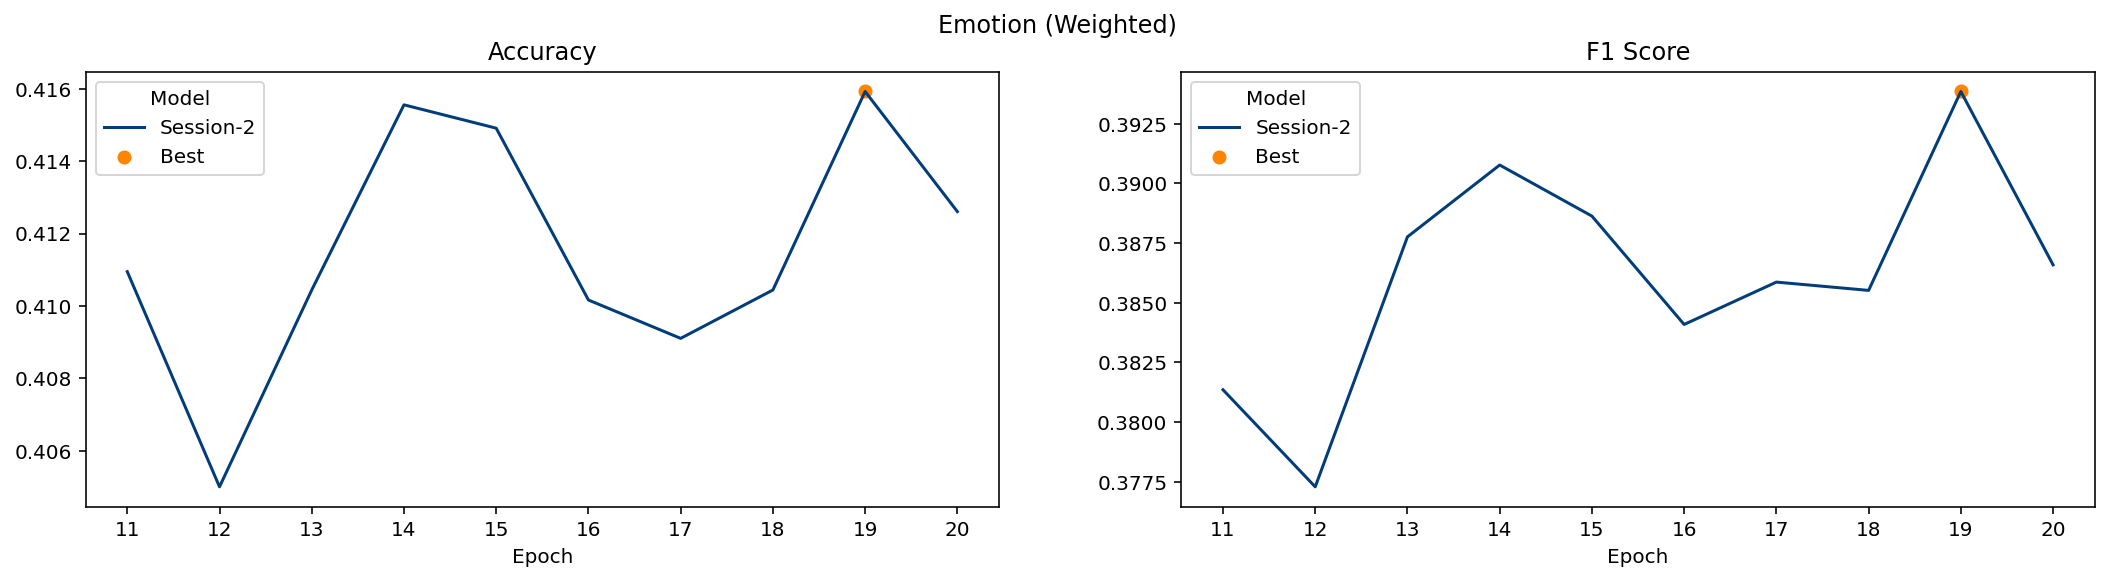

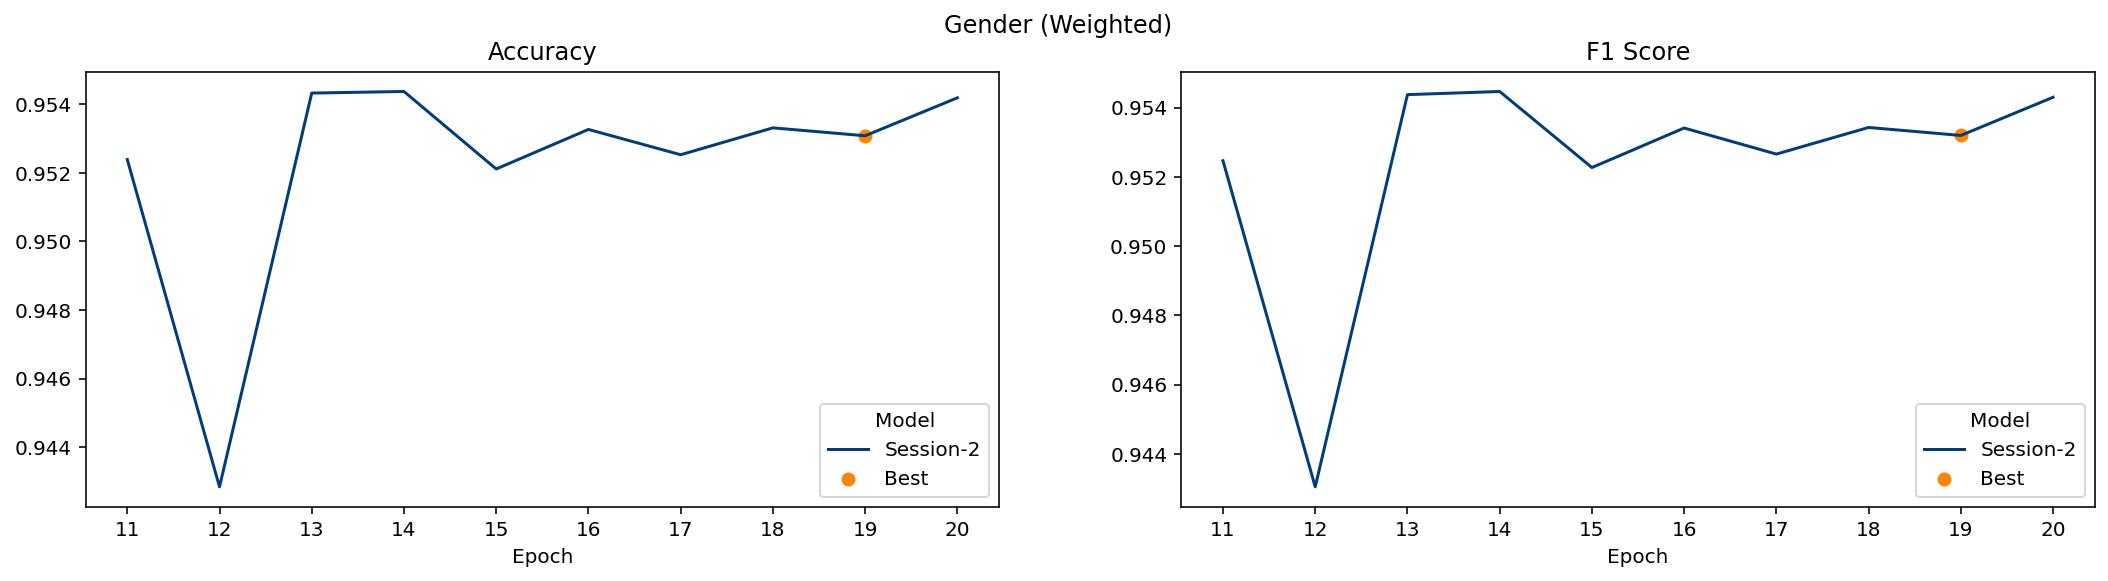

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'weighted', x_jump = 1)

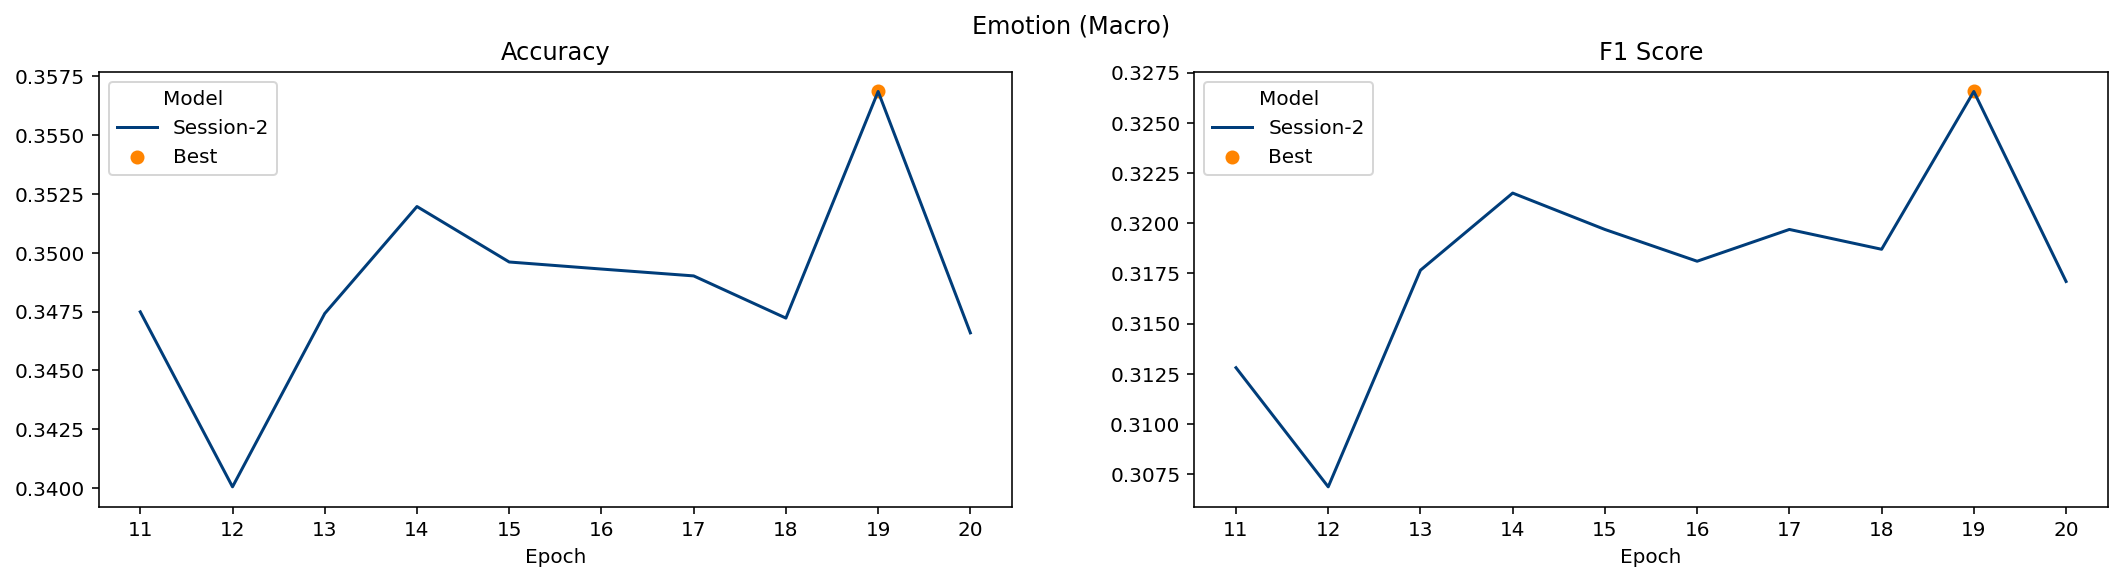

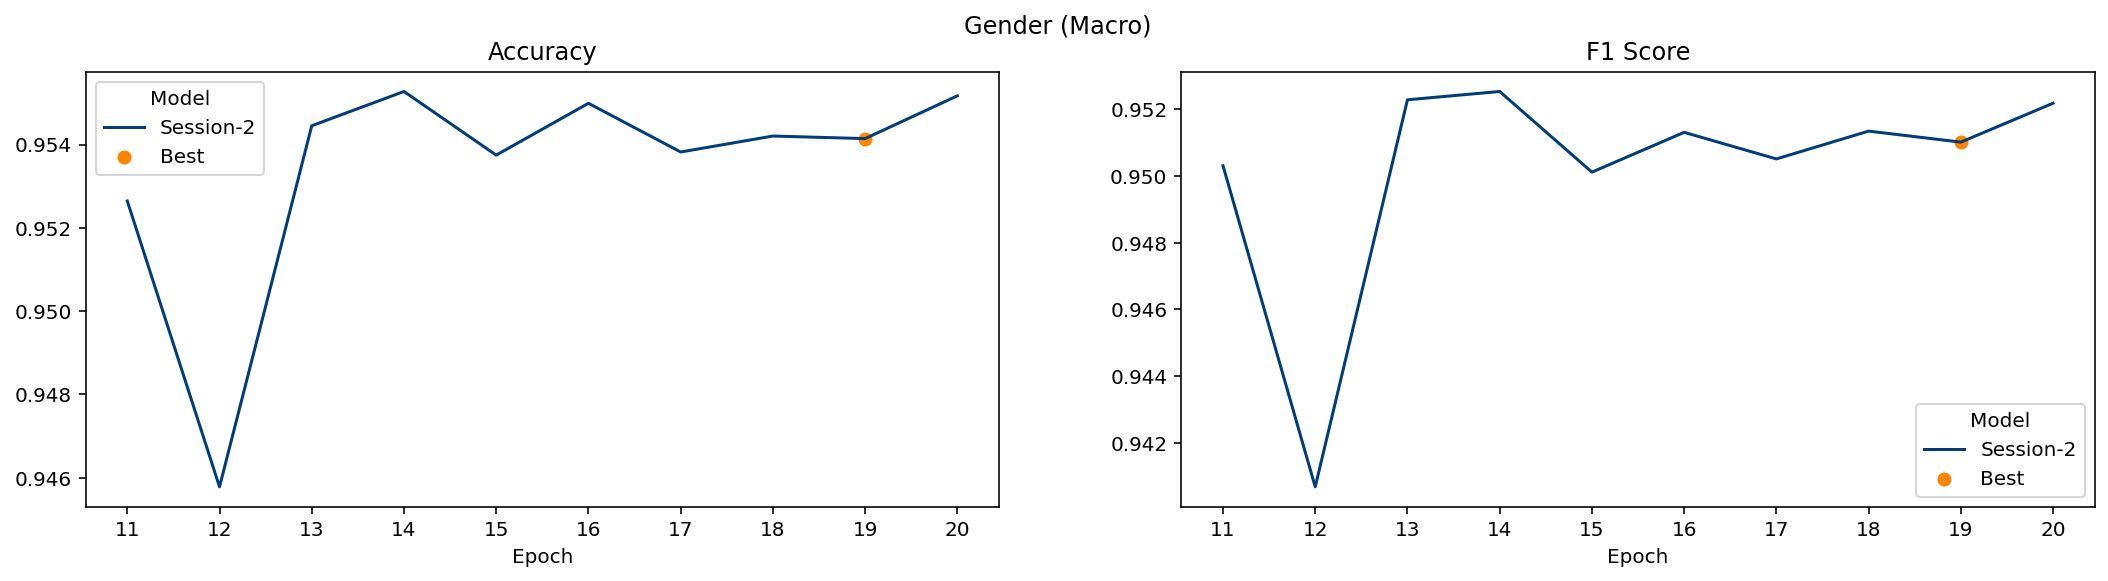

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'macro', x_jump = 1)

#### Step 5:
Plotting the regression metrics.

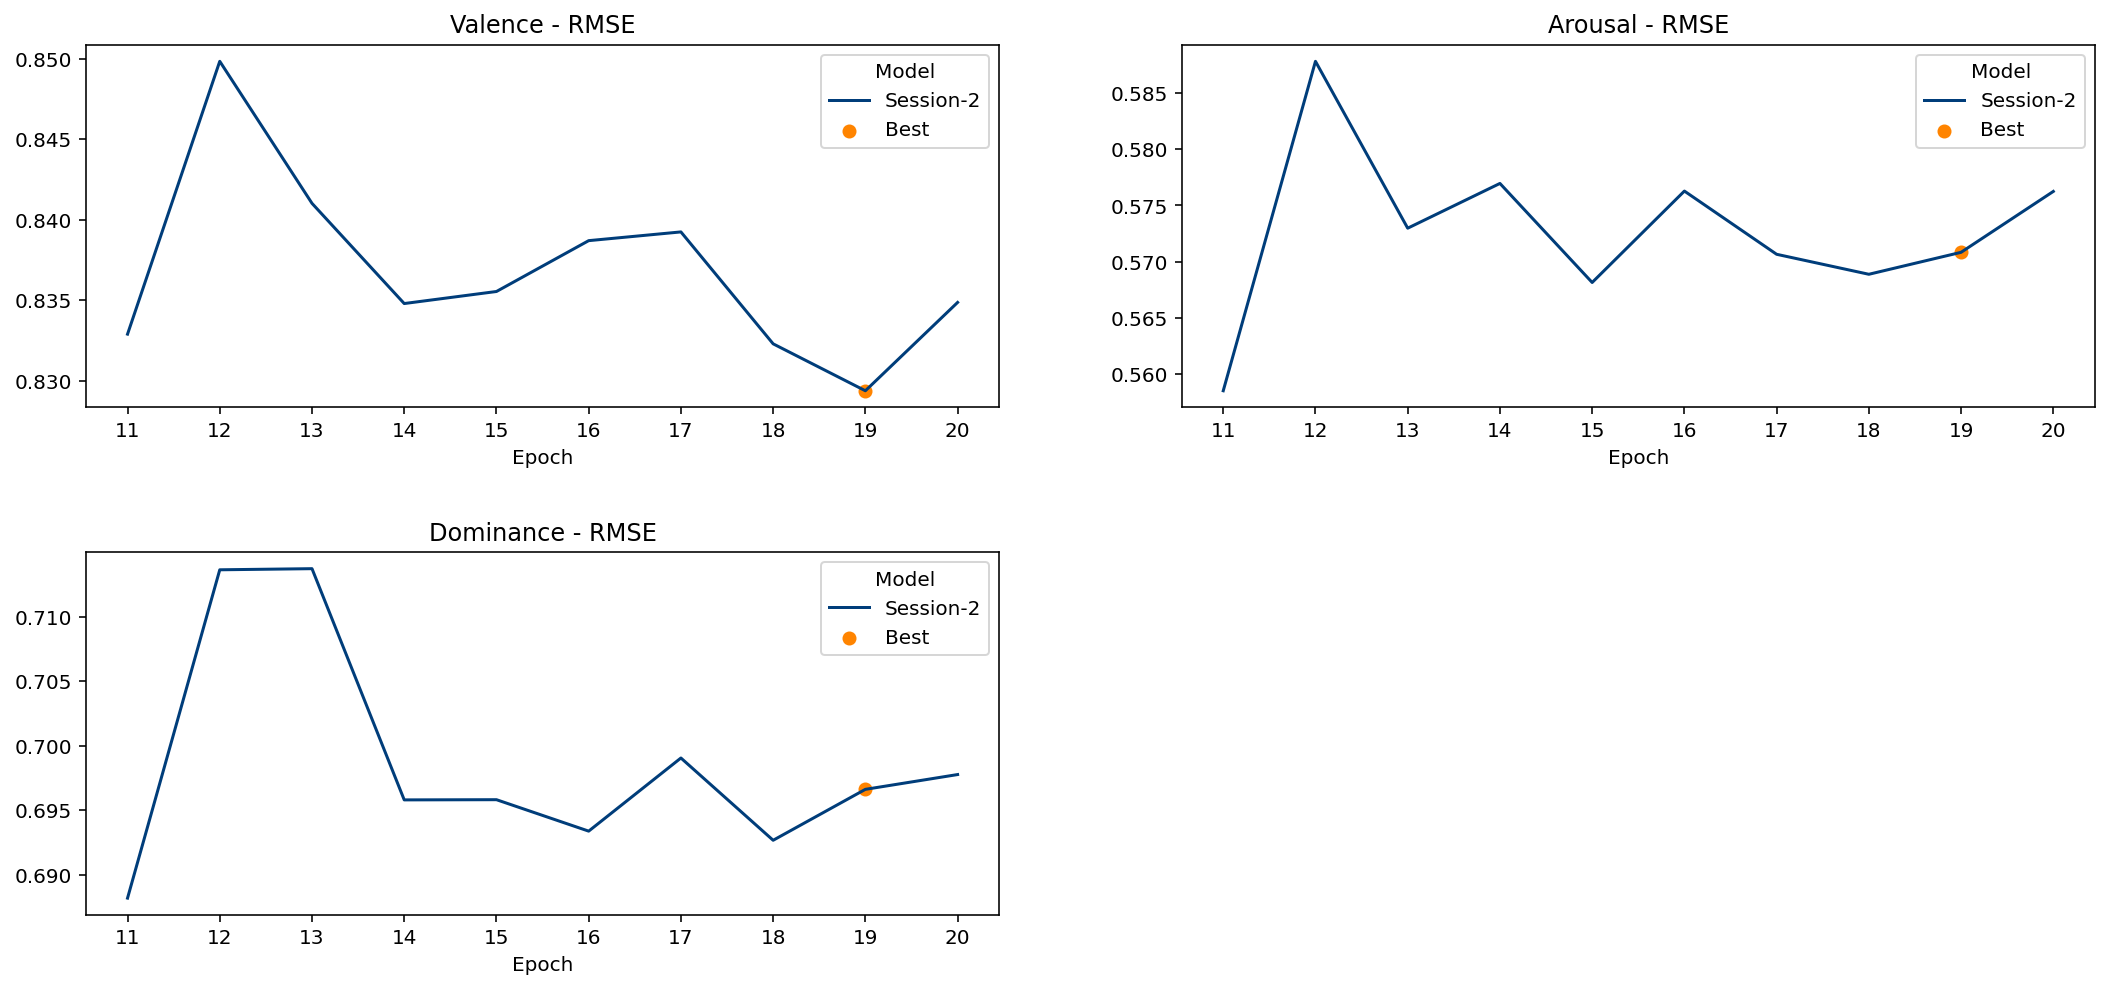

In [ ]:
plot_train_regression(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 6:
Saving the checkpoint and current best model.

In [ ]:
!zip -r 'IEMOCAP Meta.zip' 'IEMOCAP Meta'
!cp 'IEMOCAP Meta.zip' '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip'

<a id='session_three'></a>
## Session III
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- Before starting this section, run all cells from `Load Files` to `Model Parameters`, excluding -
  - Step 3 of Data Preparation.
  - Step 3 of Model Parameters.

- Load the checkpoint states into model, optimizer, and scheduler.

In [ ]:
checkpoint_num = 2
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')

epochs = (checkpoint['next epoch'], checkpoint['next epoch'] + epoch_size)
other_params['epochs'] = epochs

In [ ]:
model = ComplexNetwork(ARCH, layer_params, multitask_params, task_type)
optimizer = optim.SGD(model.parameters(), lr = optim_params['learning rate'], momentum = optim_params['momentum'],
                      weight_decay = optim_params['weight decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

model_params = (model, optimizer, all_transforms, scheduler)

#### Step 1:
Training the model.

In [ ]:
checkpoint_num = 3
train_network(roots, model_params, torch_params, other_params, checkpoint_num)

IntProgress(value=20, description='Epoch - 20 / 30', layout=Layout(width='500px'), max=30, min=20, style=Progr…

#### Step 2:
Loading the model data.

In [ ]:
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')
best_model = torch.load(f'{meta_root}/Best.pt')
best_epoch = None
if best_model['current epoch'] >= epochs[0]:
  best_epoch = best_model['current epoch'] - epoch_size*(checkpoint_num - 1)

#### Step 3:
Plotting the loss curves of the trained model with a marker of the current best model.

Epoch Range = 20 to 30
Session-3 | Training Duration = 4042.96 sec | Average Duration = 404.30 sec


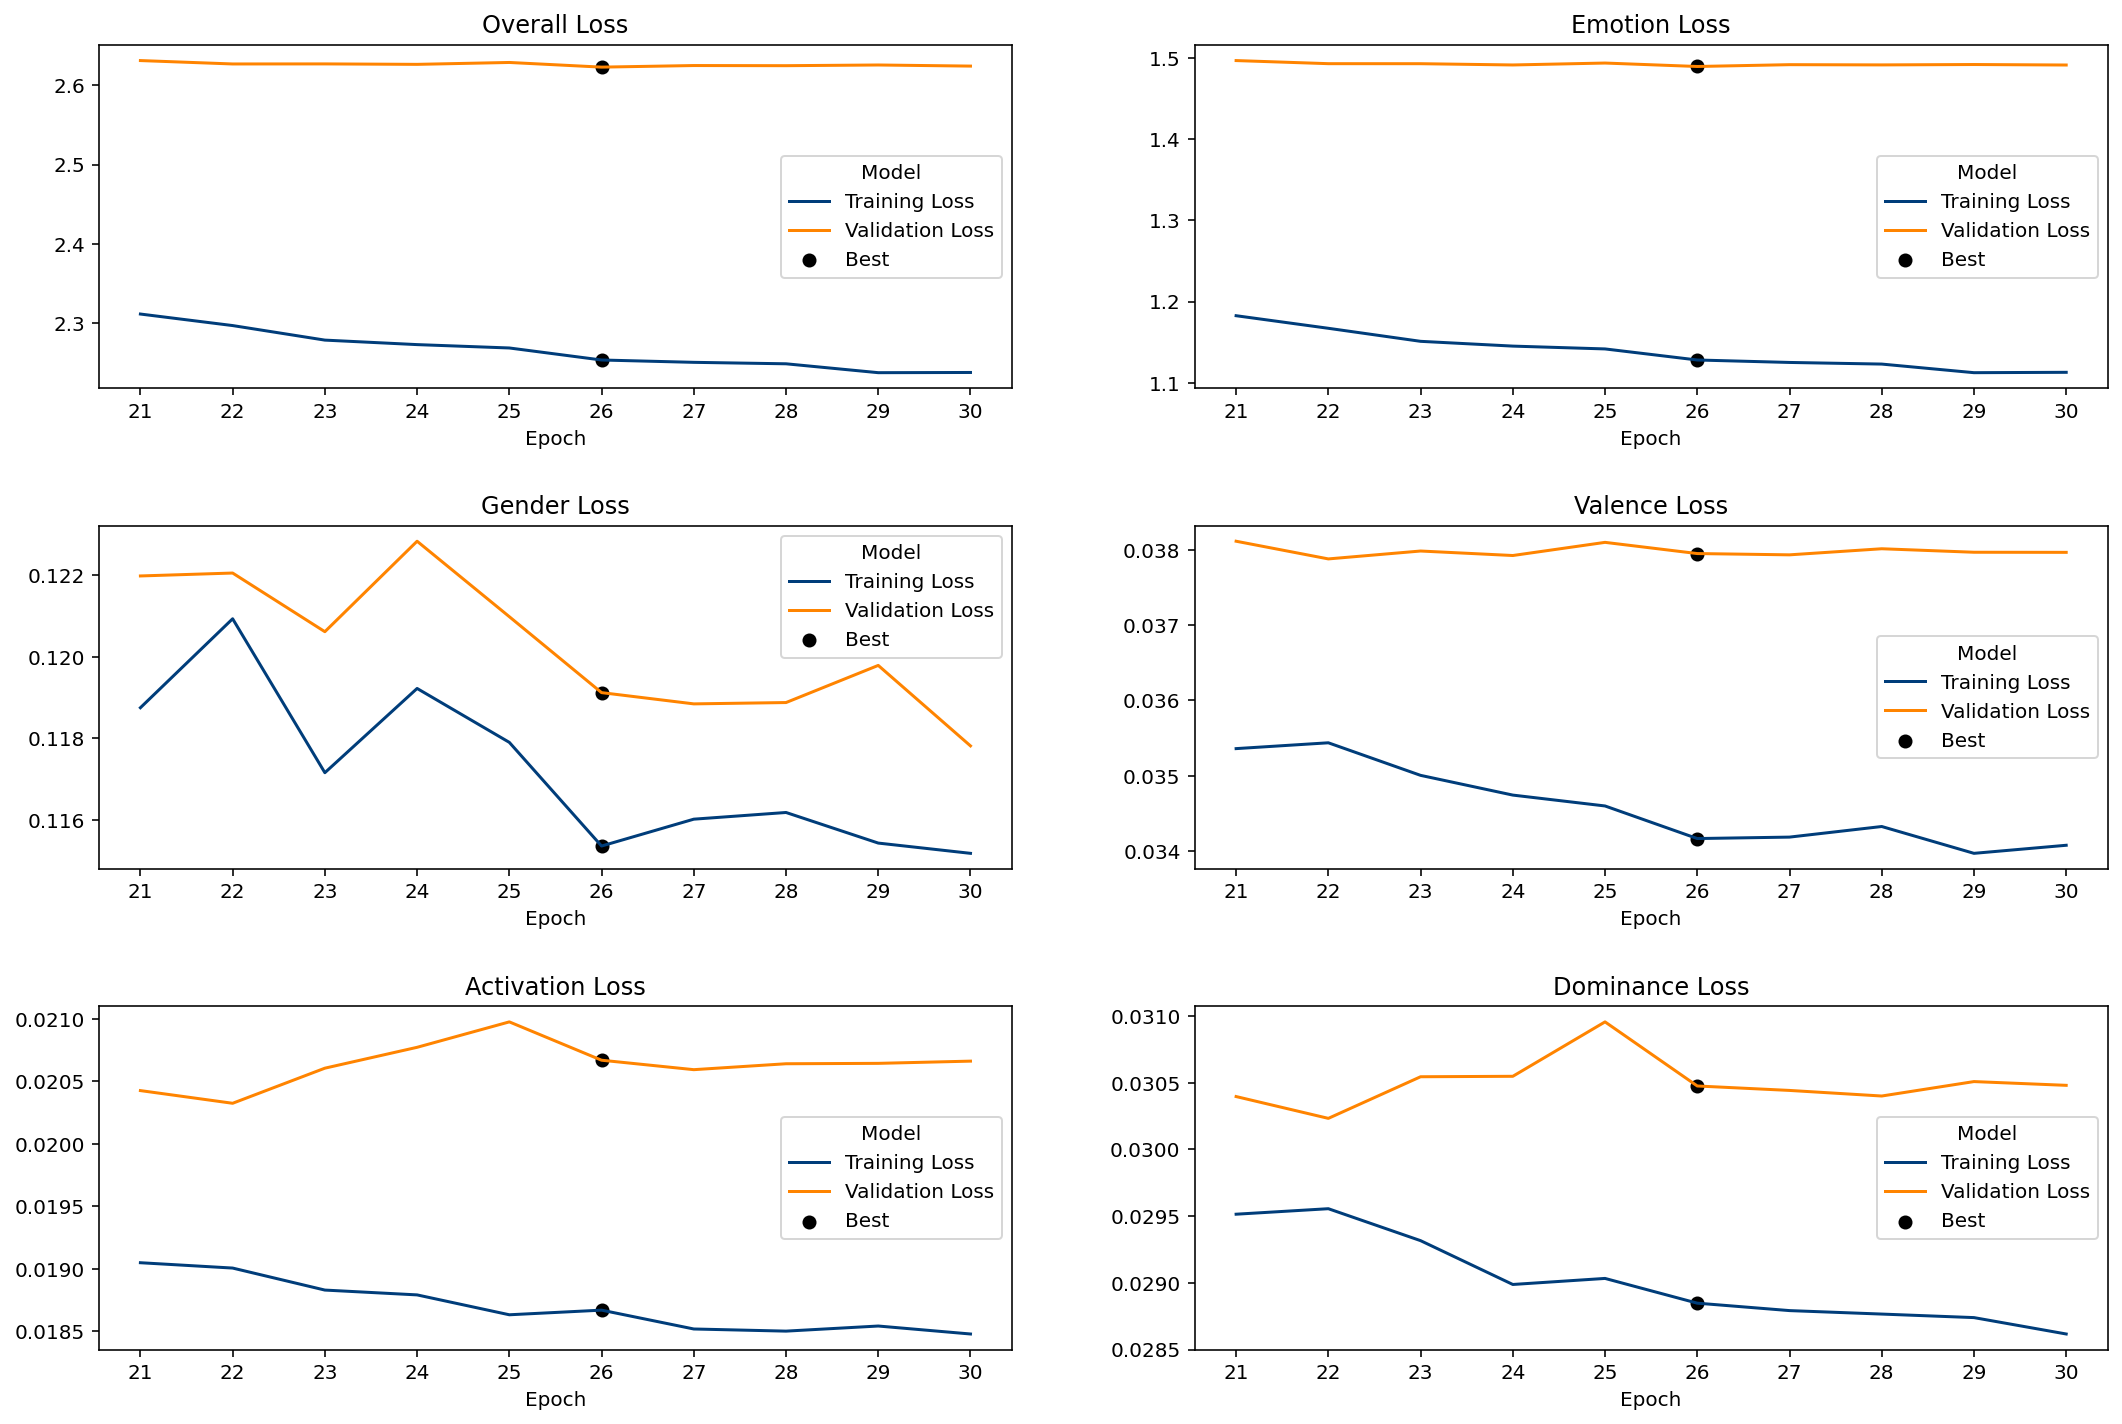

In [ ]:
plot_train_loss(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 4:
Plotting the classification metrics.
> `average` - weighted and macro.

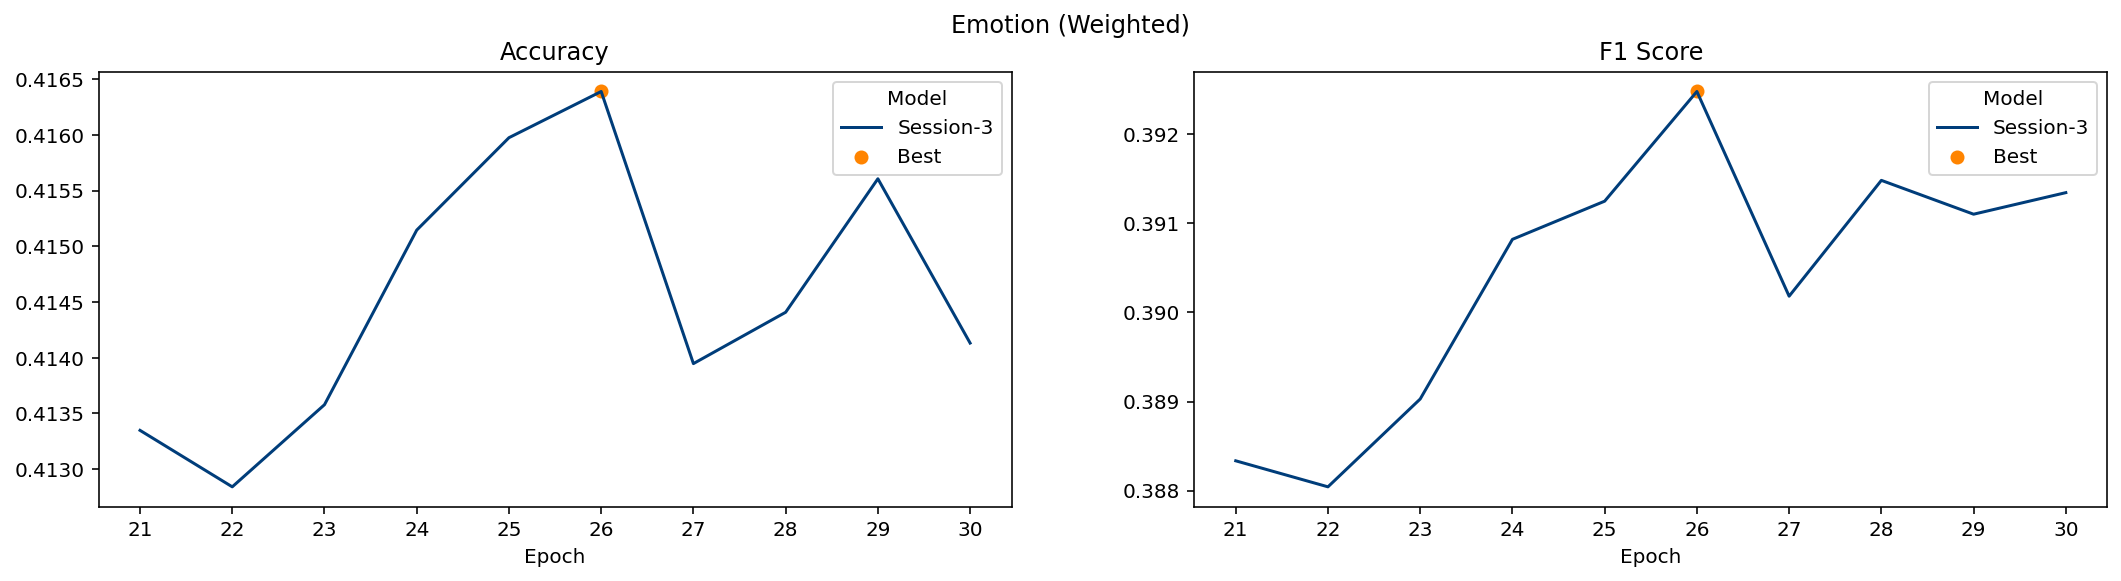

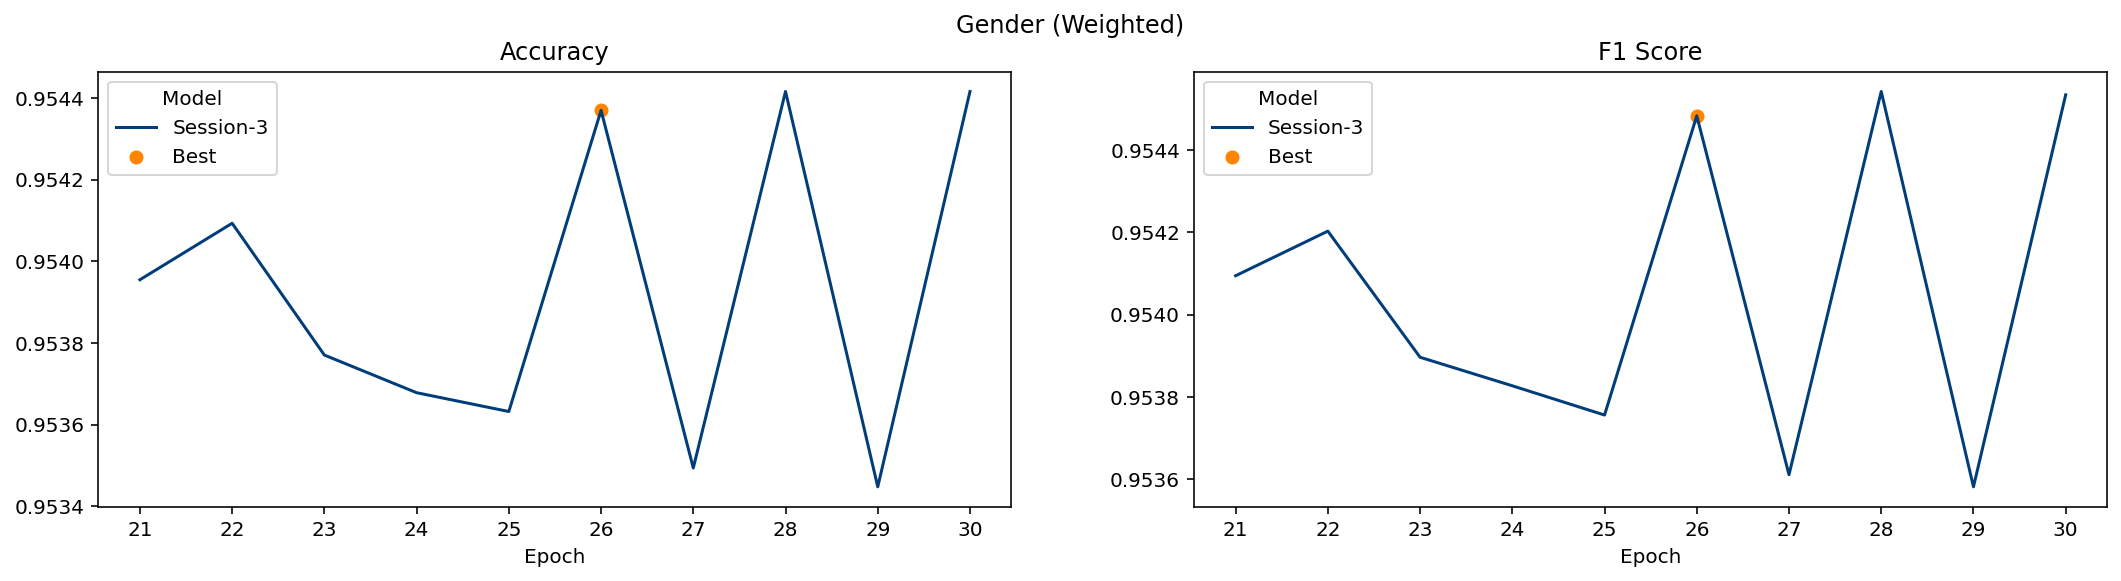

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'weighted', x_jump = 1)

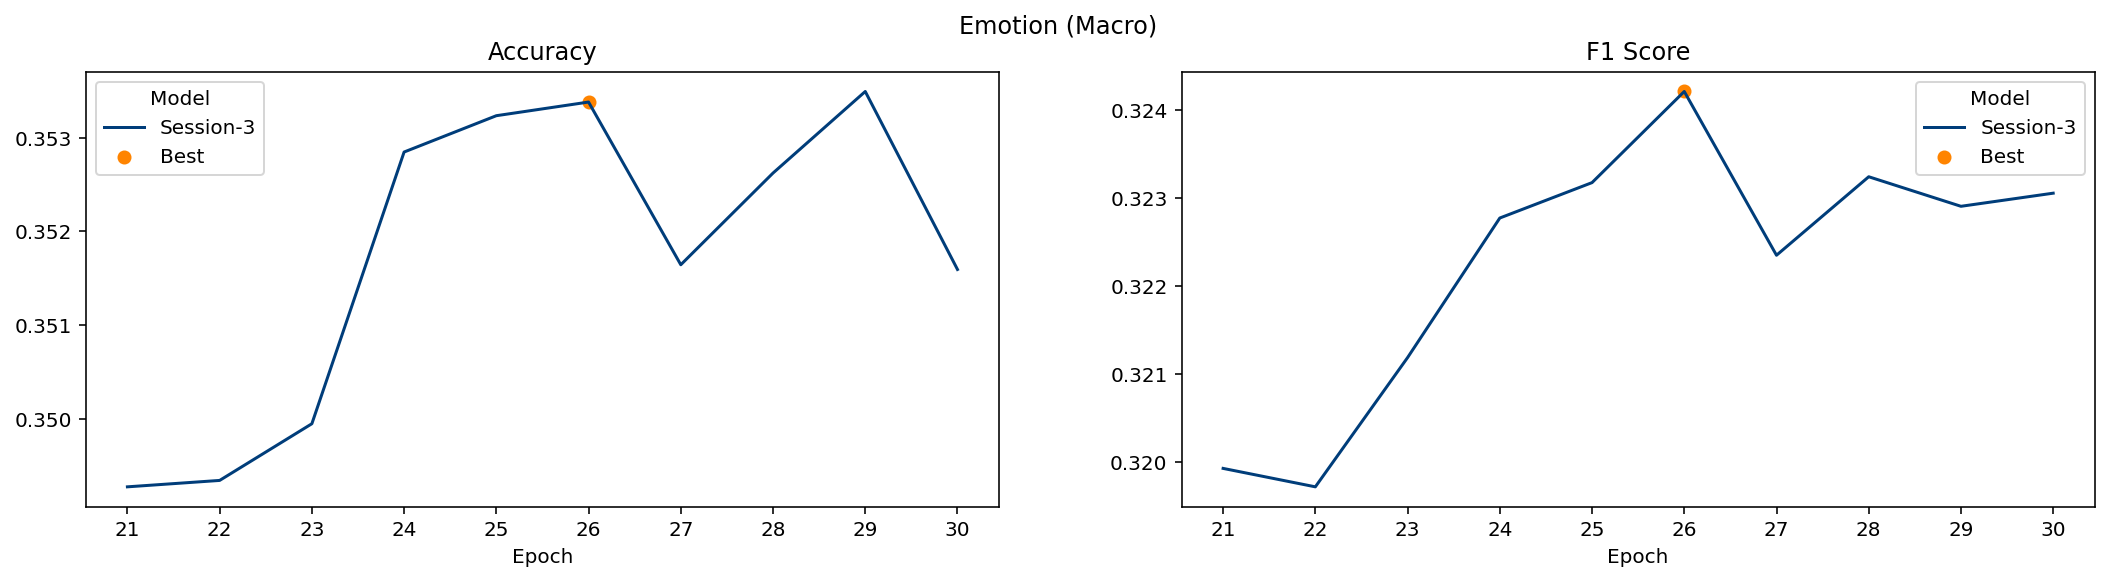

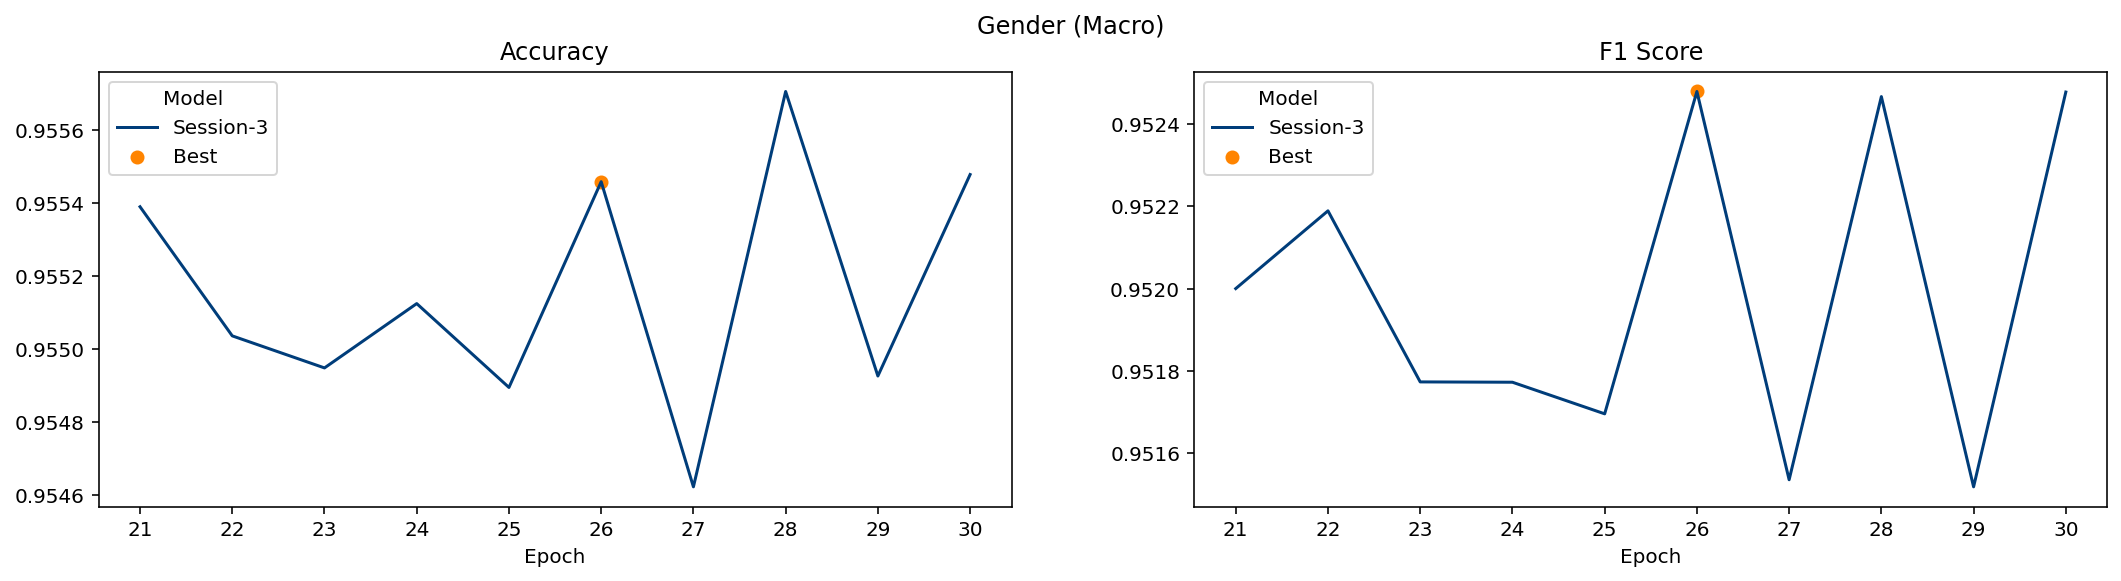

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'macro', x_jump = 1)

#### Step 5:
Plotting the regression metrics.

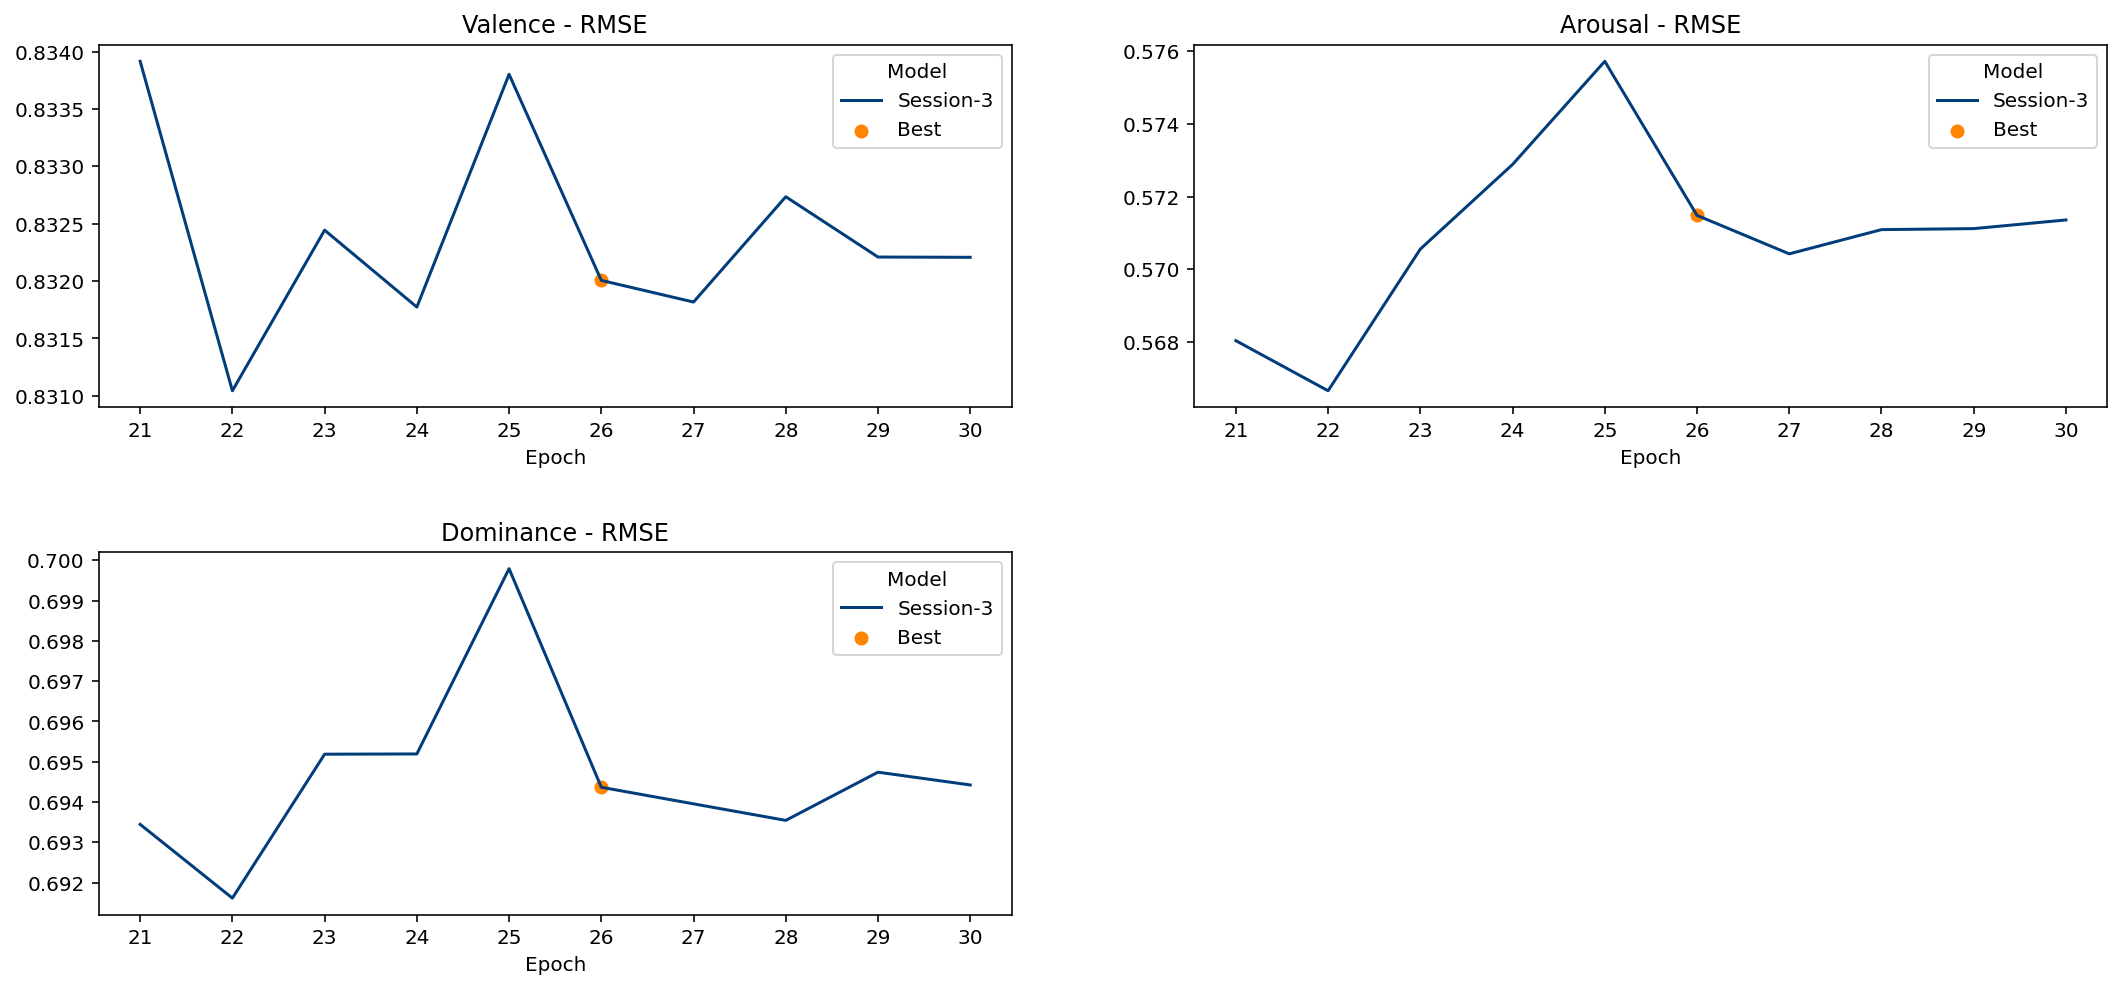

In [ ]:
plot_train_regression(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 6:
Saving the checkpoint and current best model.

In [ ]:
!zip -r 'IEMOCAP Meta.zip' 'IEMOCAP Meta'
!cp 'IEMOCAP Meta.zip' '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip'

<a id='session_four'></a>
## Session IV
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- Before starting this section, run all cells from `Load Files` to `Model Parameters`, excluding -
  - Step 3 of Data Preparation.
  - Step 3 of Model Parameters.

- Load the checkpoint states into model, optimizer, and scheduler.

In [ ]:
checkpoint_num = 3
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')

epochs = (checkpoint['next epoch'], checkpoint['next epoch'] + epoch_size)
other_params['epochs'] = epochs

In [ ]:
model = ComplexNetwork(ARCH, layer_params, multitask_params, task_type)
optimizer = optim.SGD(model.parameters(), lr = optim_params['learning rate'], momentum = optim_params['momentum'],
                      weight_decay = optim_params['weight decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

model_params = (model, optimizer, all_transforms, scheduler)

#### Step 1:
Training the model.

In [ ]:
checkpoint_num = 4
train_network(roots, model_params, torch_params, other_params, checkpoint_num)

IntProgress(value=30, description='Epoch - 30 / 40', layout=Layout(width='500px'), max=40, min=30, style=Progr…

#### Step 2:
Loading the model data.

In [ ]:
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')
best_model = torch.load(f'{meta_root}/Best.pt')
best_epoch = None
if best_model['current epoch'] >= epochs[0]:
  best_epoch = best_model['current epoch'] - epoch_size*(checkpoint_num - 1)

#### Step 3:
Plotting the loss curves of the trained model with a marker of the current best model.

Epoch Range = 30 to 40
Session-4 | Training Duration = 5024.99 sec | Average Duration = 502.50 sec


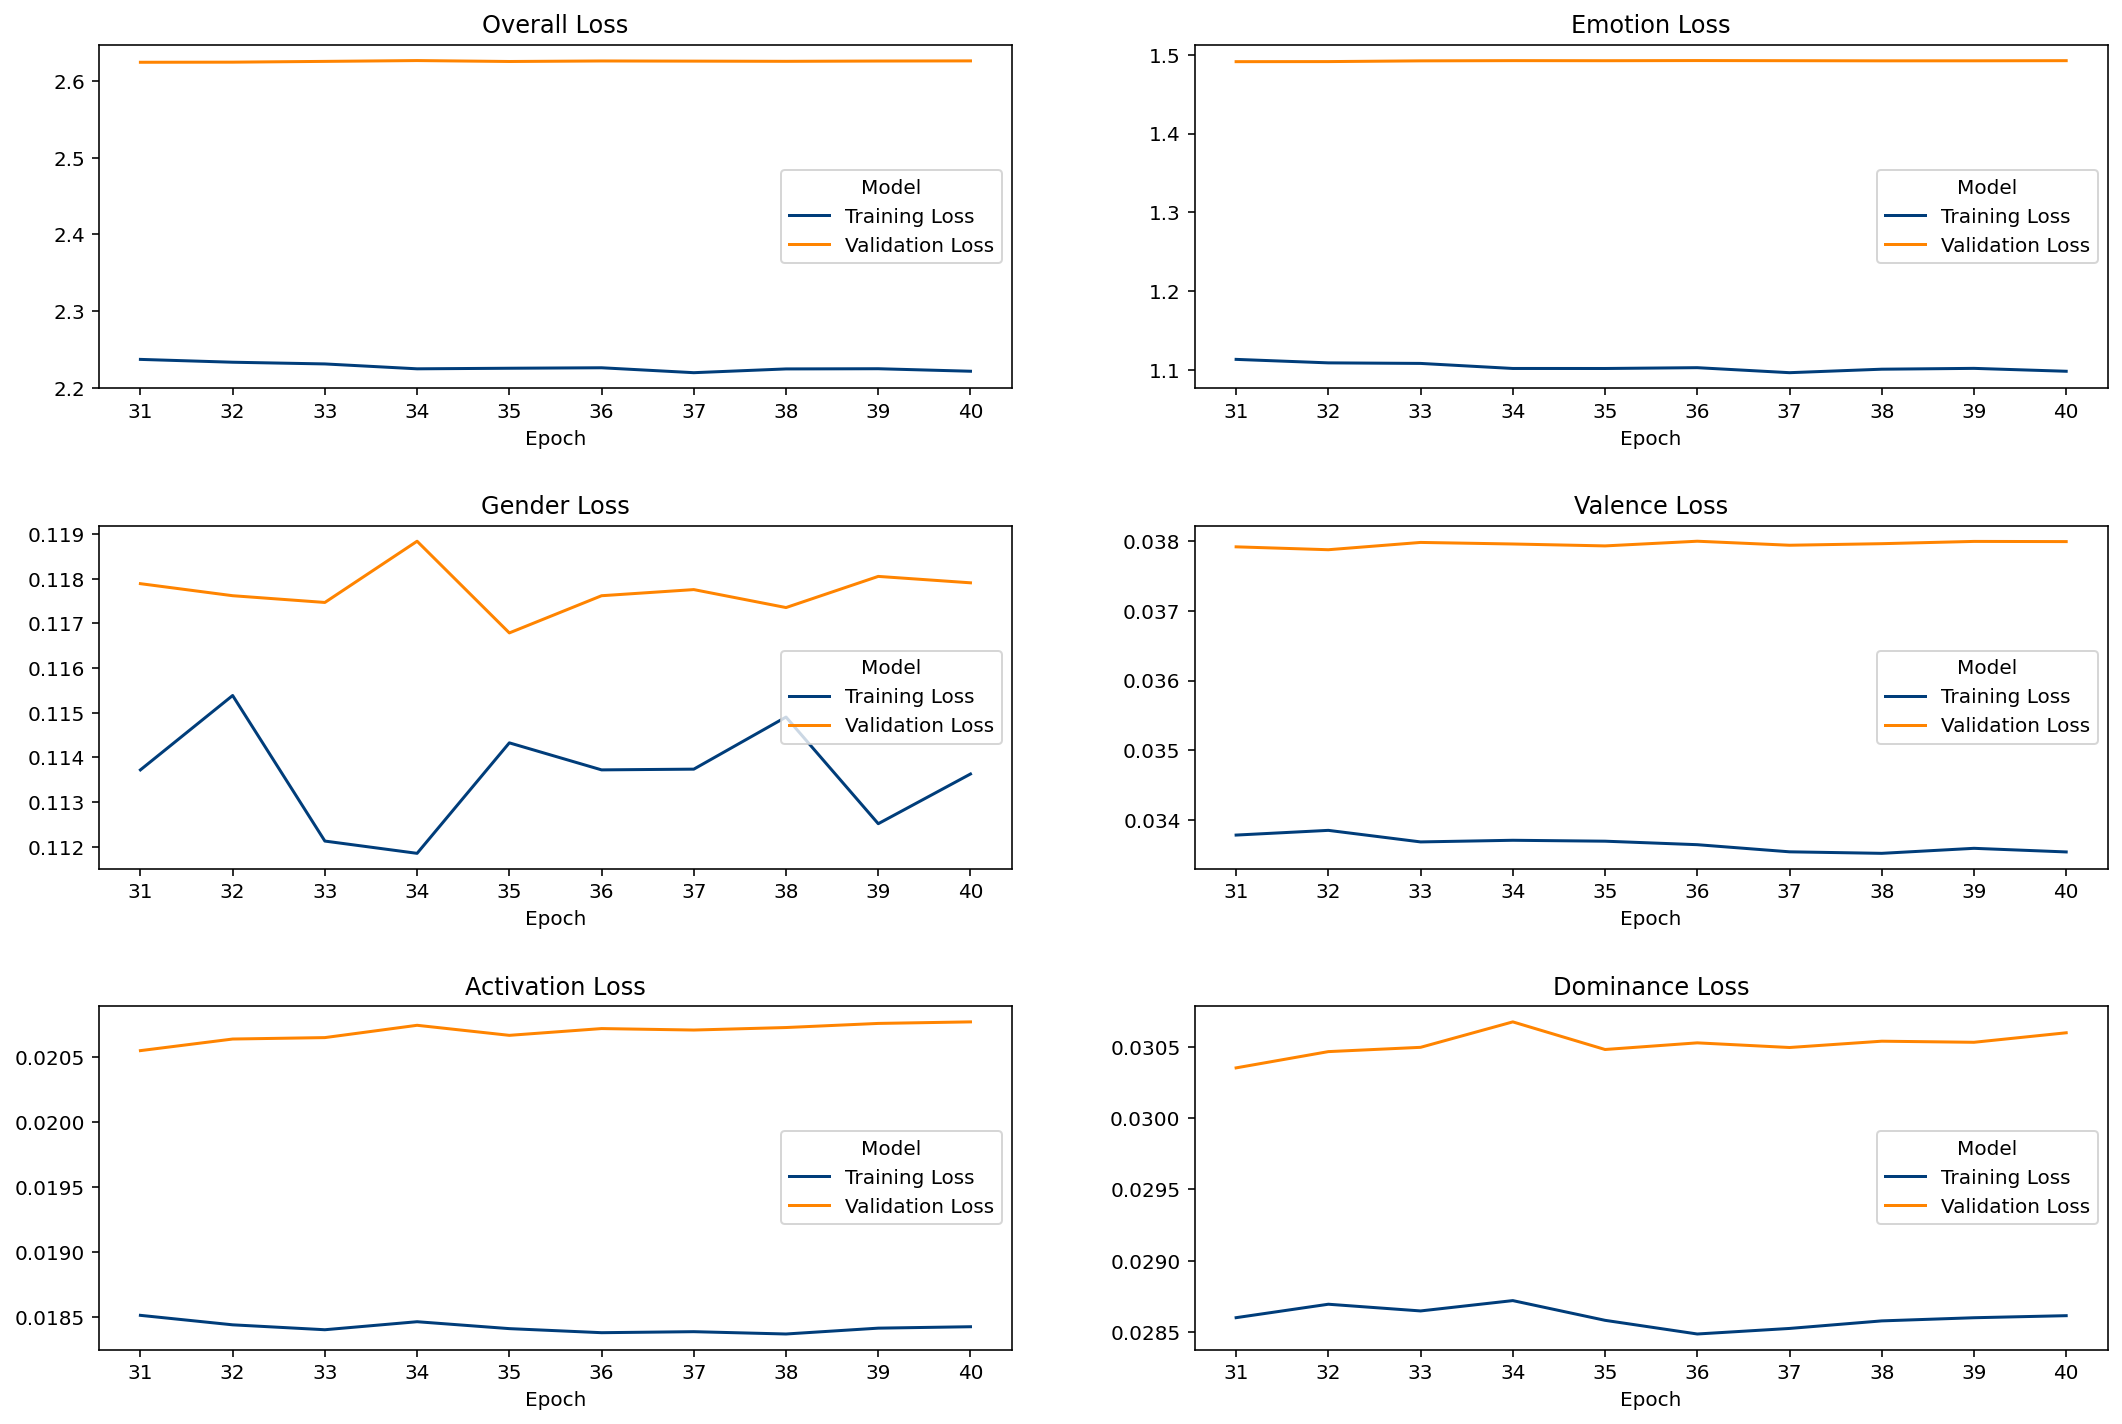

In [ ]:
plot_train_loss(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 4:
Plotting the classification metrics.
> `average` - weighted and macro.

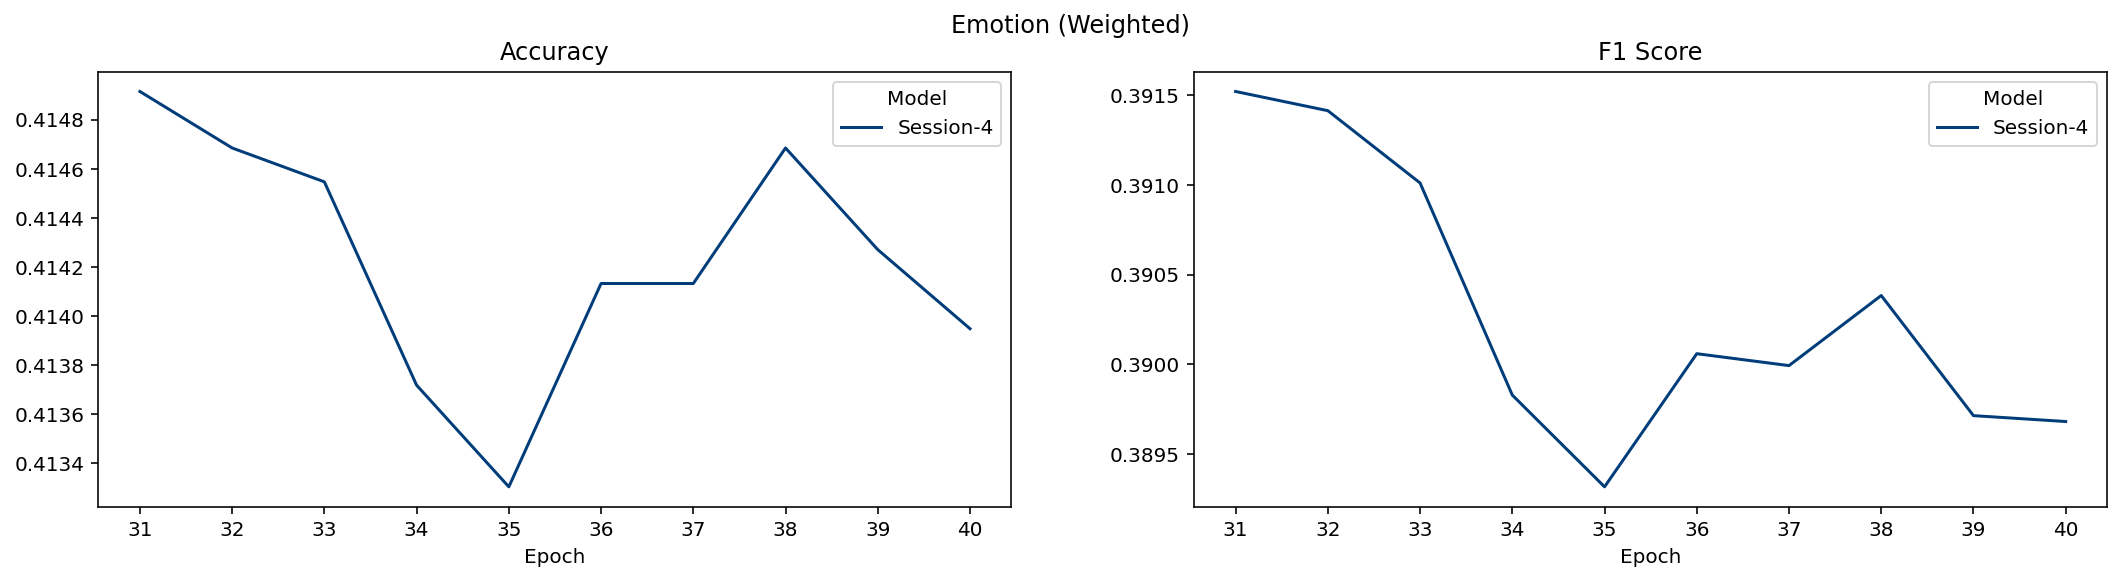

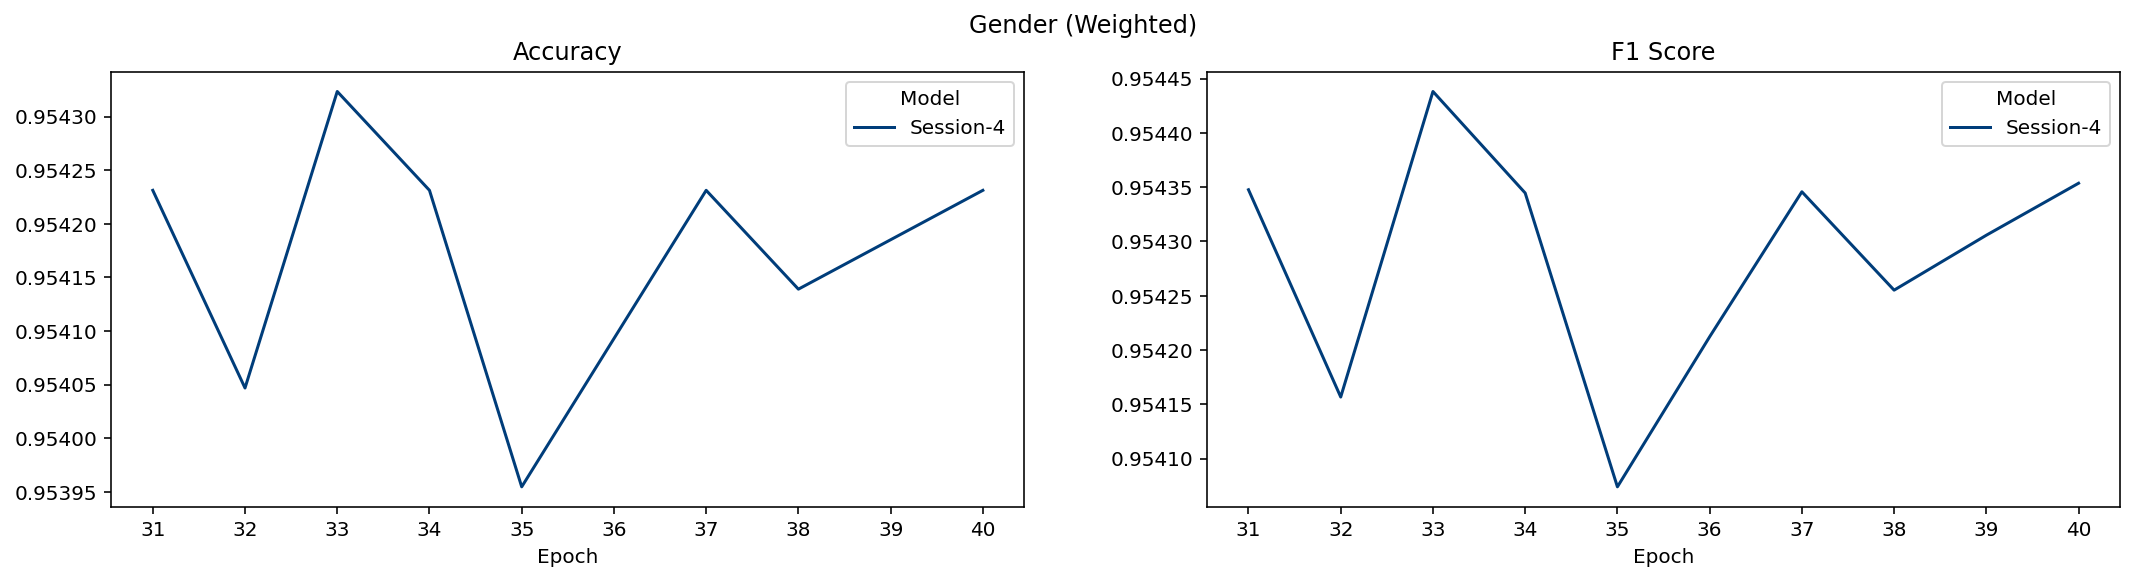

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'weighted', x_jump = 1)

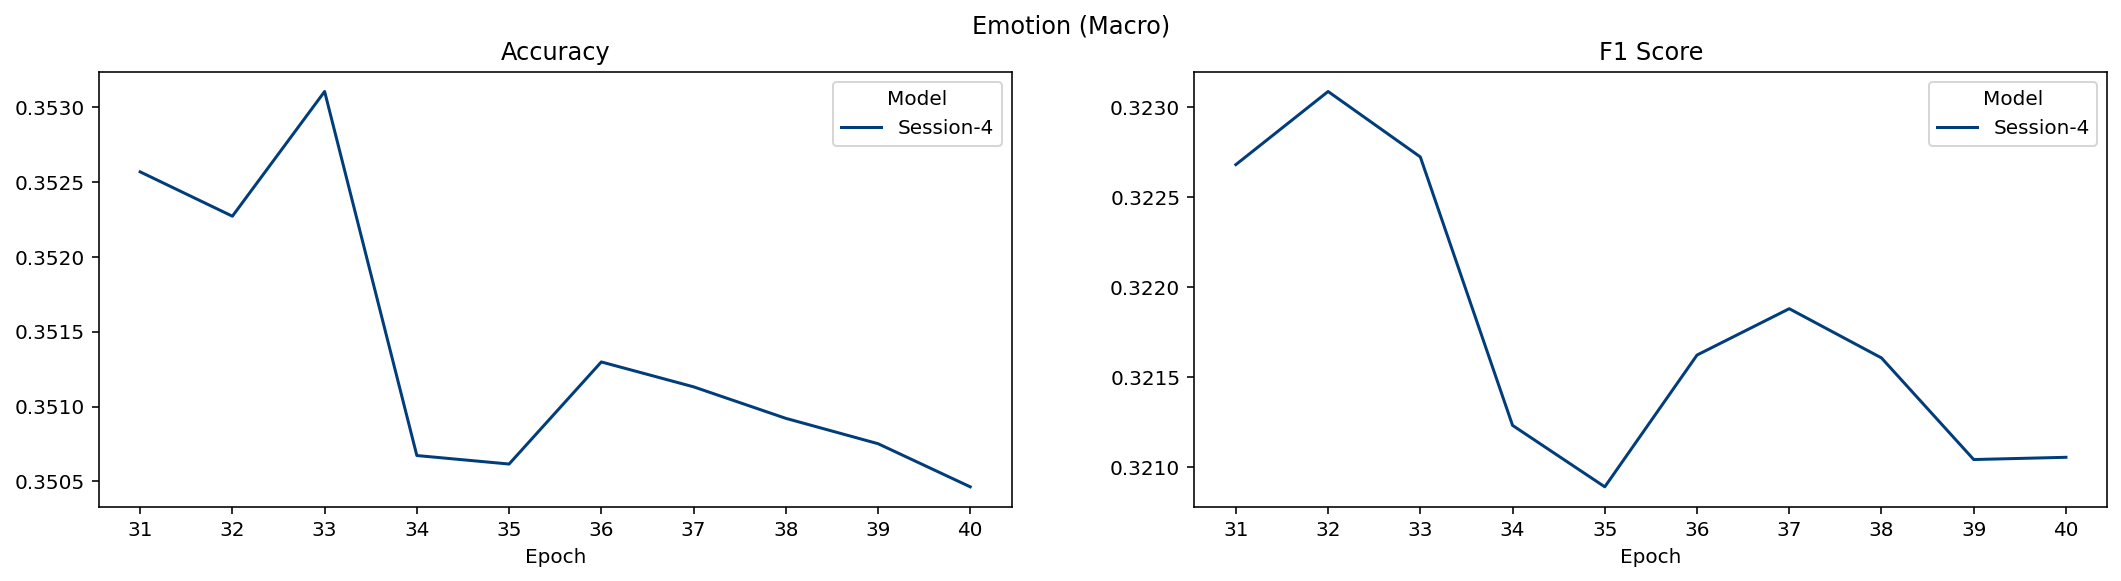

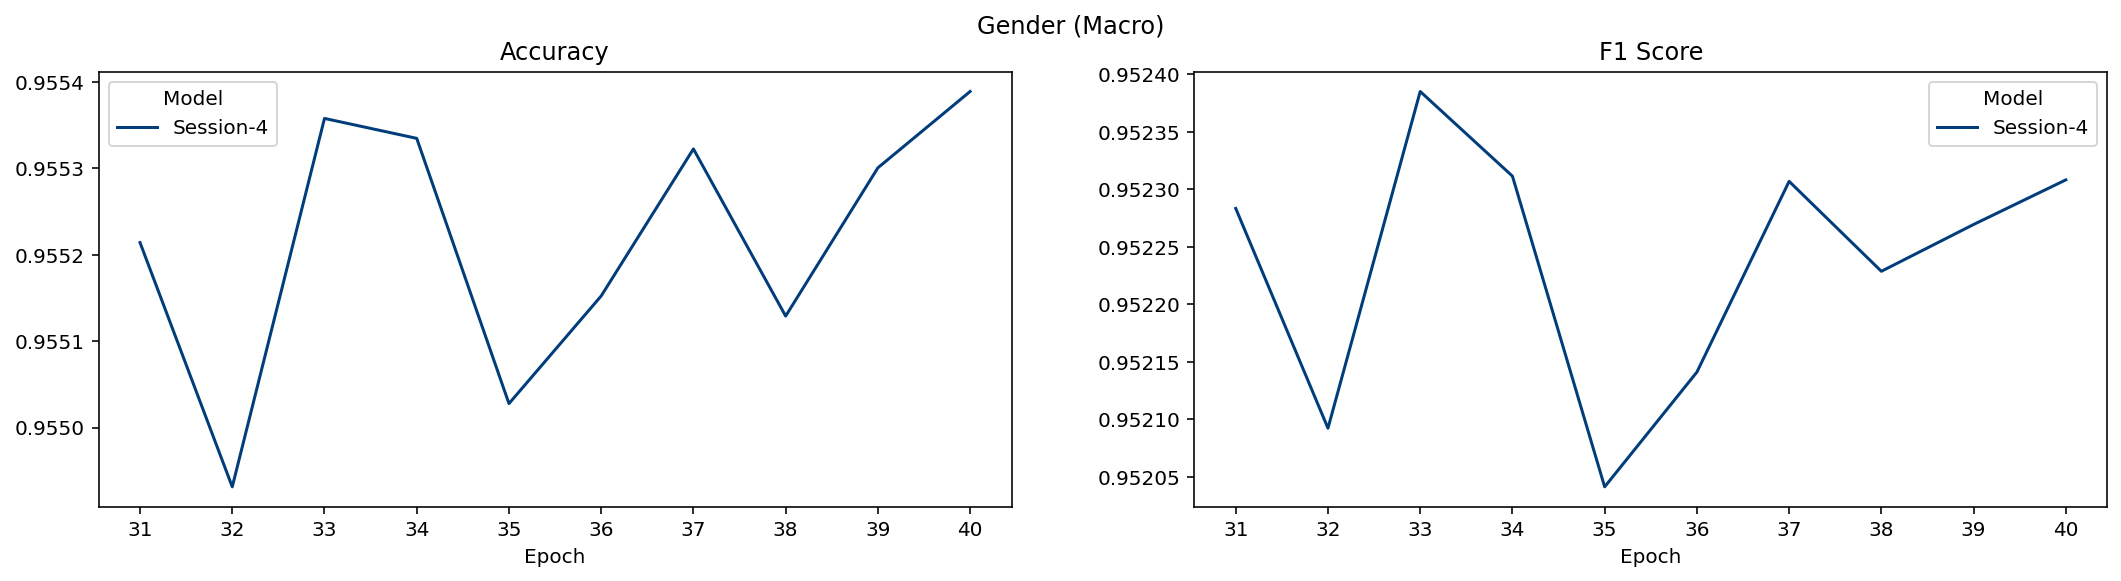

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'macro', x_jump = 1)

#### Step 5:
Plotting the regression metrics.

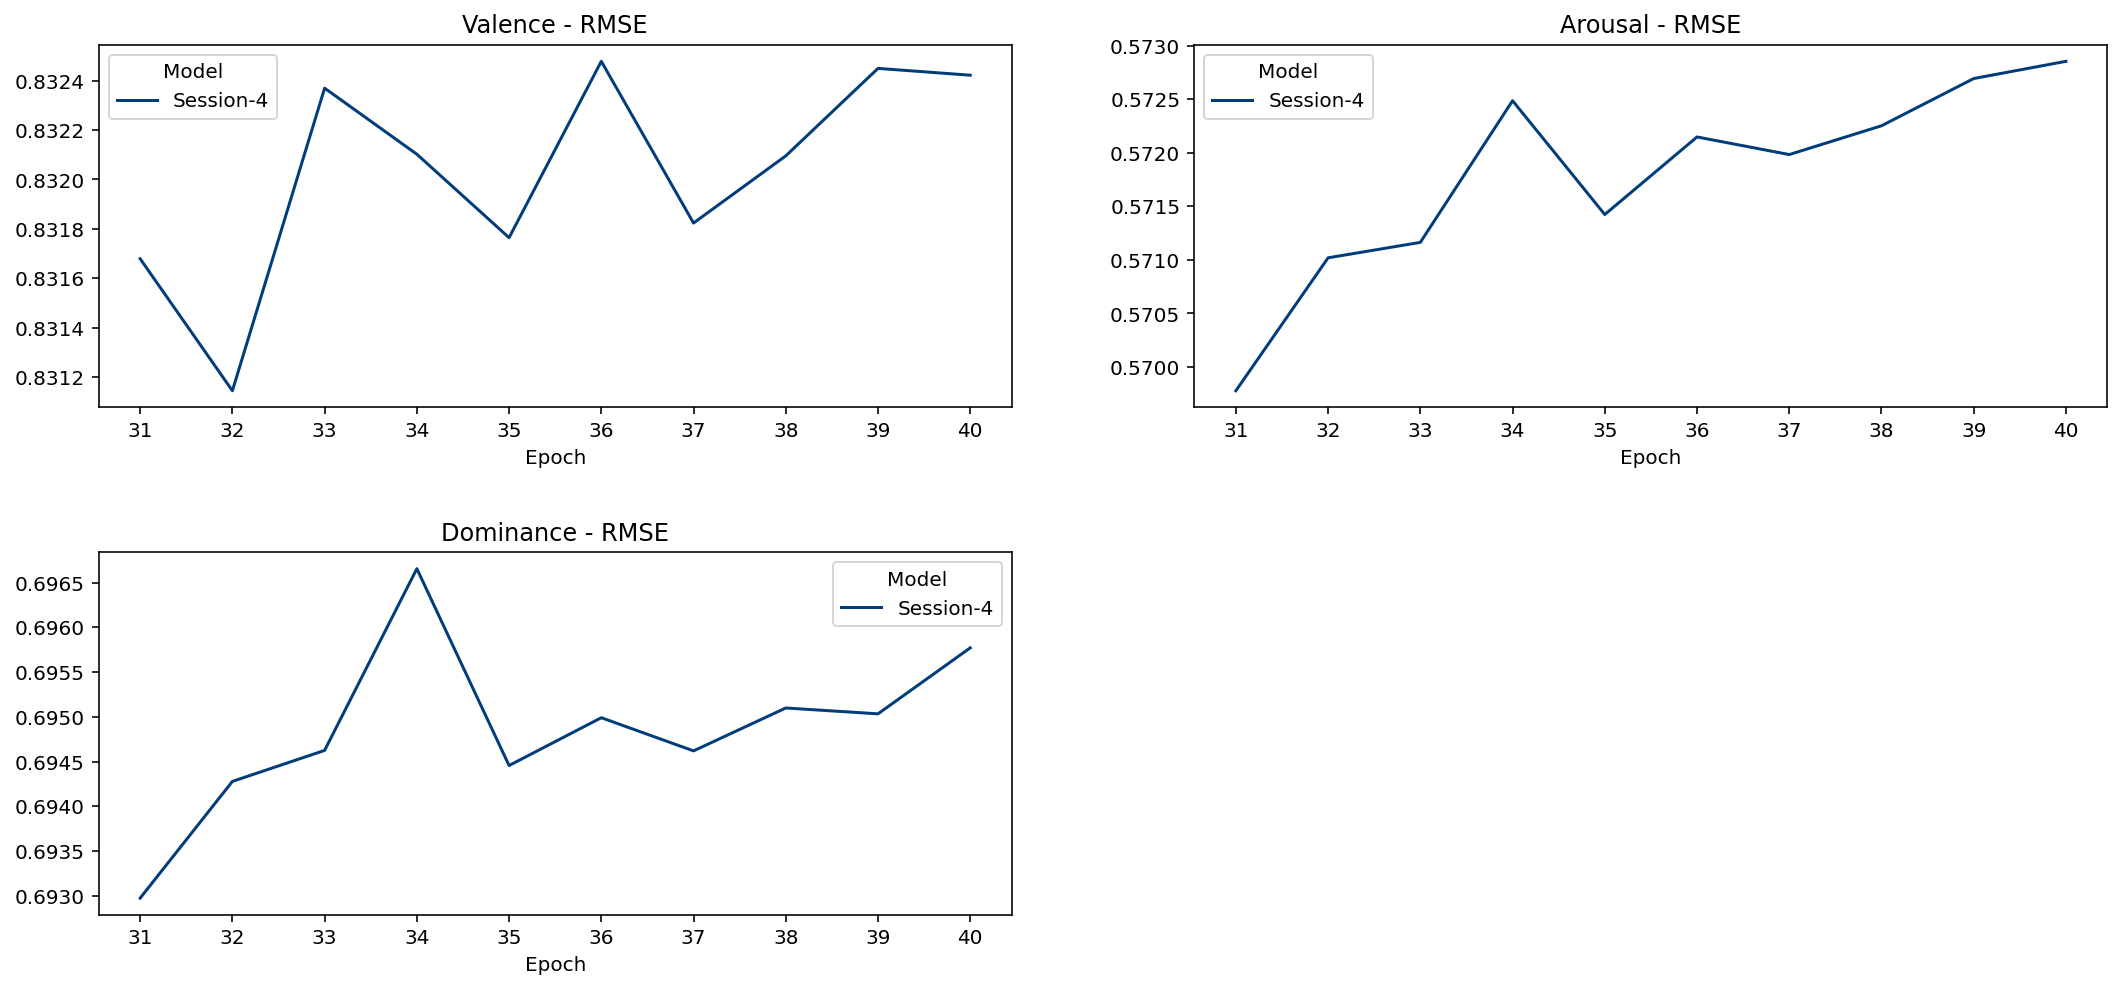

In [ ]:
plot_train_regression(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 6:
Saving the checkpoint and current best model.

In [ ]:
!zip -r 'IEMOCAP Meta.zip' 'IEMOCAP Meta'
!cp 'IEMOCAP Meta.zip' '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip'

<a id='session_five'></a>
## Session V
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- Before starting this section, run all cells from `Load Files` to `Model Parameters`, excluding -
  - Step 3 of Data Preparation.
  - Step 3 of Model Parameters.

- Load the checkpoint states into model, optimizer, and scheduler.

In [ ]:
checkpoint_num = 4
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')

epochs = (checkpoint['next epoch'], checkpoint['next epoch'] + epoch_size)
other_params['epochs'] = epochs

In [ ]:
model = ComplexNetwork(ARCH, layer_params, multitask_params, task_type)
optimizer = optim.SGD(model.parameters(), lr = optim_params['learning rate'], momentum = optim_params['momentum'],
                      weight_decay = optim_params['weight decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

model_params = (model, optimizer, all_transforms, scheduler)

#### Step 1:
Training the model.

In [ ]:
checkpoint_num = 5
train_network(roots, model_params, torch_params, other_params, checkpoint_num)

IntProgress(value=40, description='Epoch - 40 / 50', layout=Layout(width='500px'), max=50, min=40, style=Progr…

#### Step 2:
Loading the model data.

In [ ]:
checkpoint = torch.load(f'{meta_root}/Checkpoint-{checkpoint_num}.pt')
best_model = torch.load(f'{meta_root}/Best.pt')
best_epoch = None
if best_model['current epoch'] >= epochs[0]:
  best_epoch = best_model['current epoch'] - epoch_size*(checkpoint_num - 1)

#### Step 3:
Plotting the loss curves of the trained model with a marker of the current best model.

Epoch Range = 40 to 50
Session-5 | Training Duration = 4986.63 sec | Average Duration = 498.66 sec


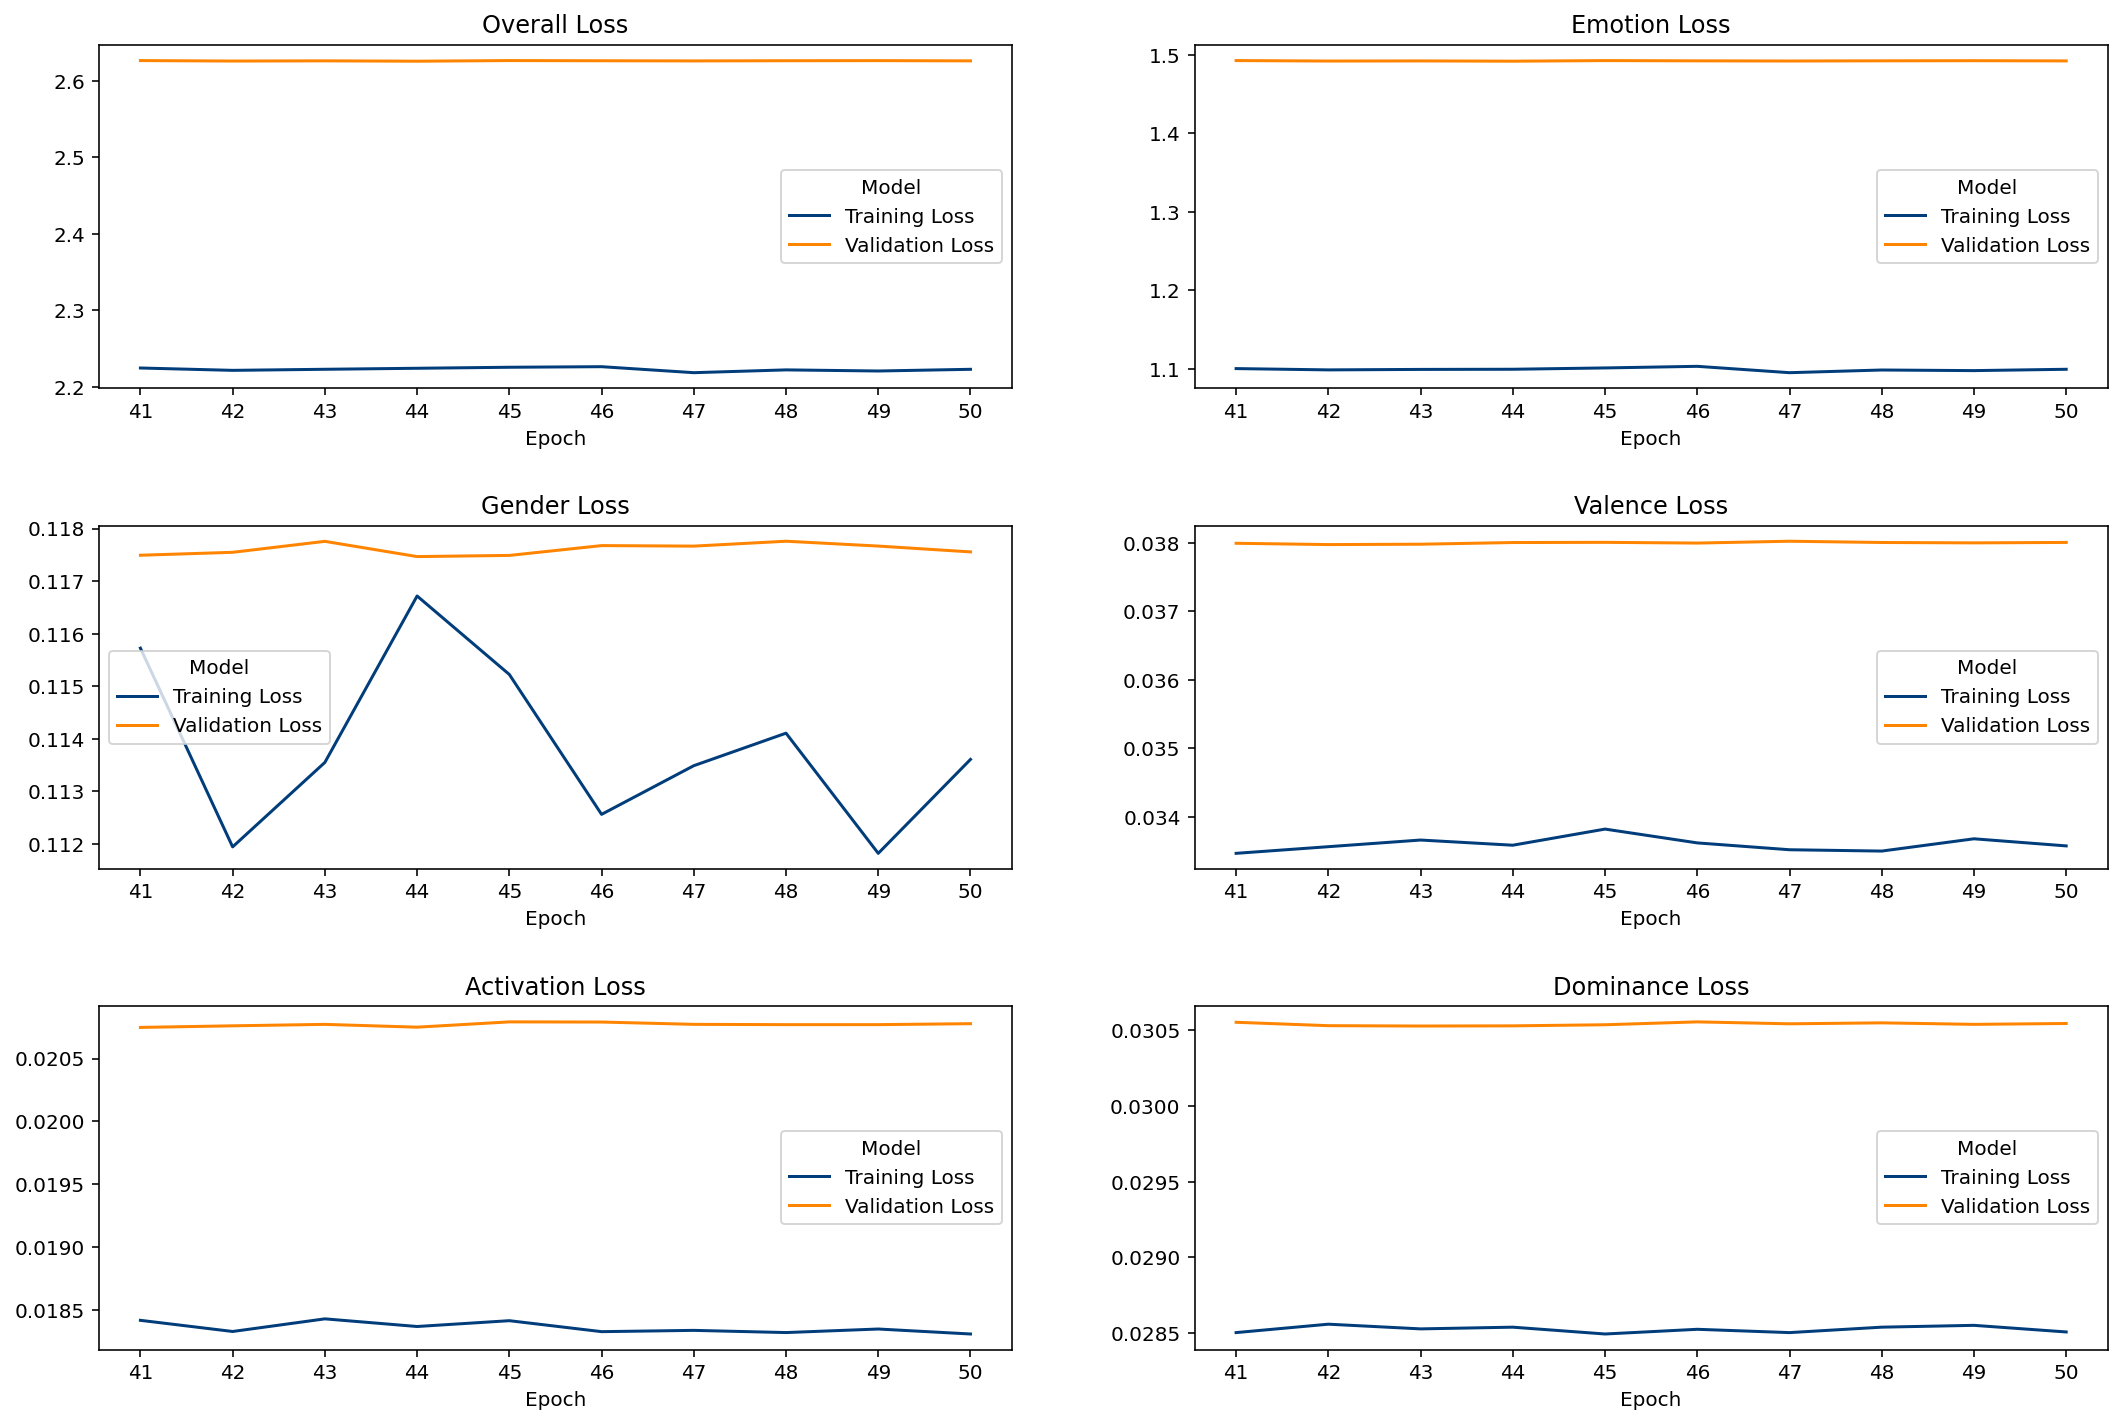

In [ ]:
plot_train_loss(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 4:
Plotting the classification metrics.
> `average` - weighted and macro.

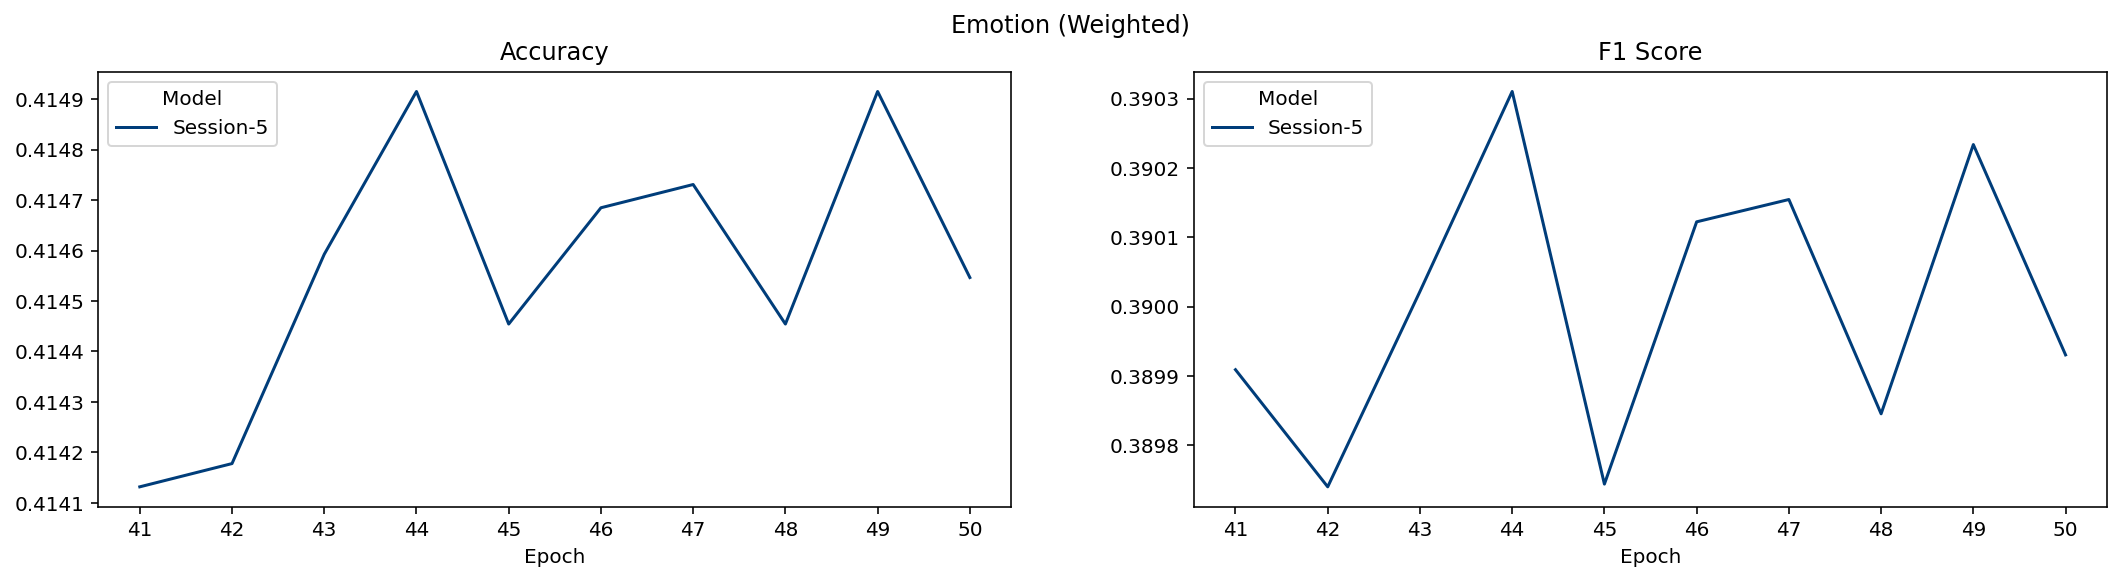

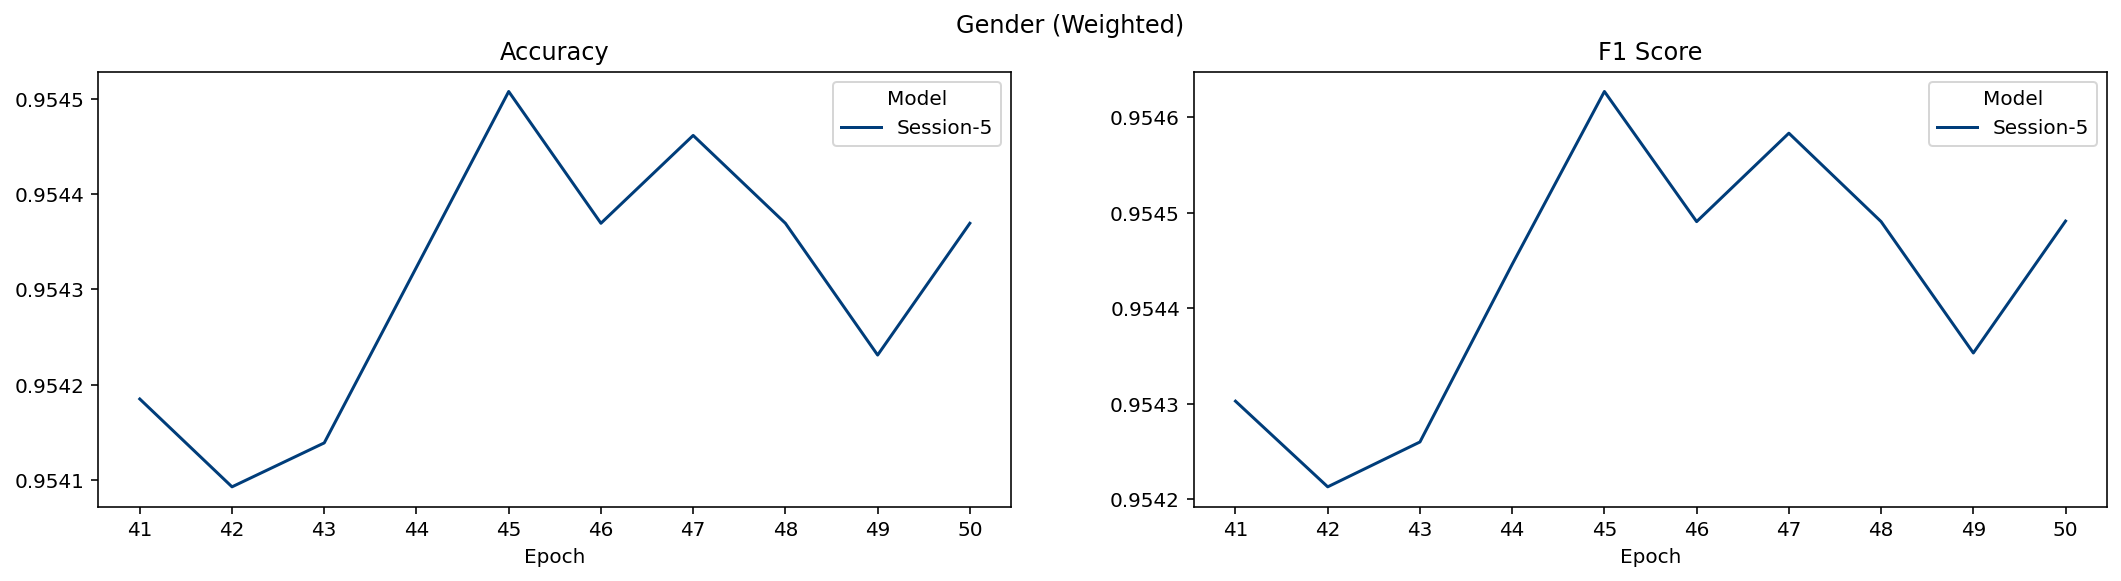

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'weighted', x_jump = 1)

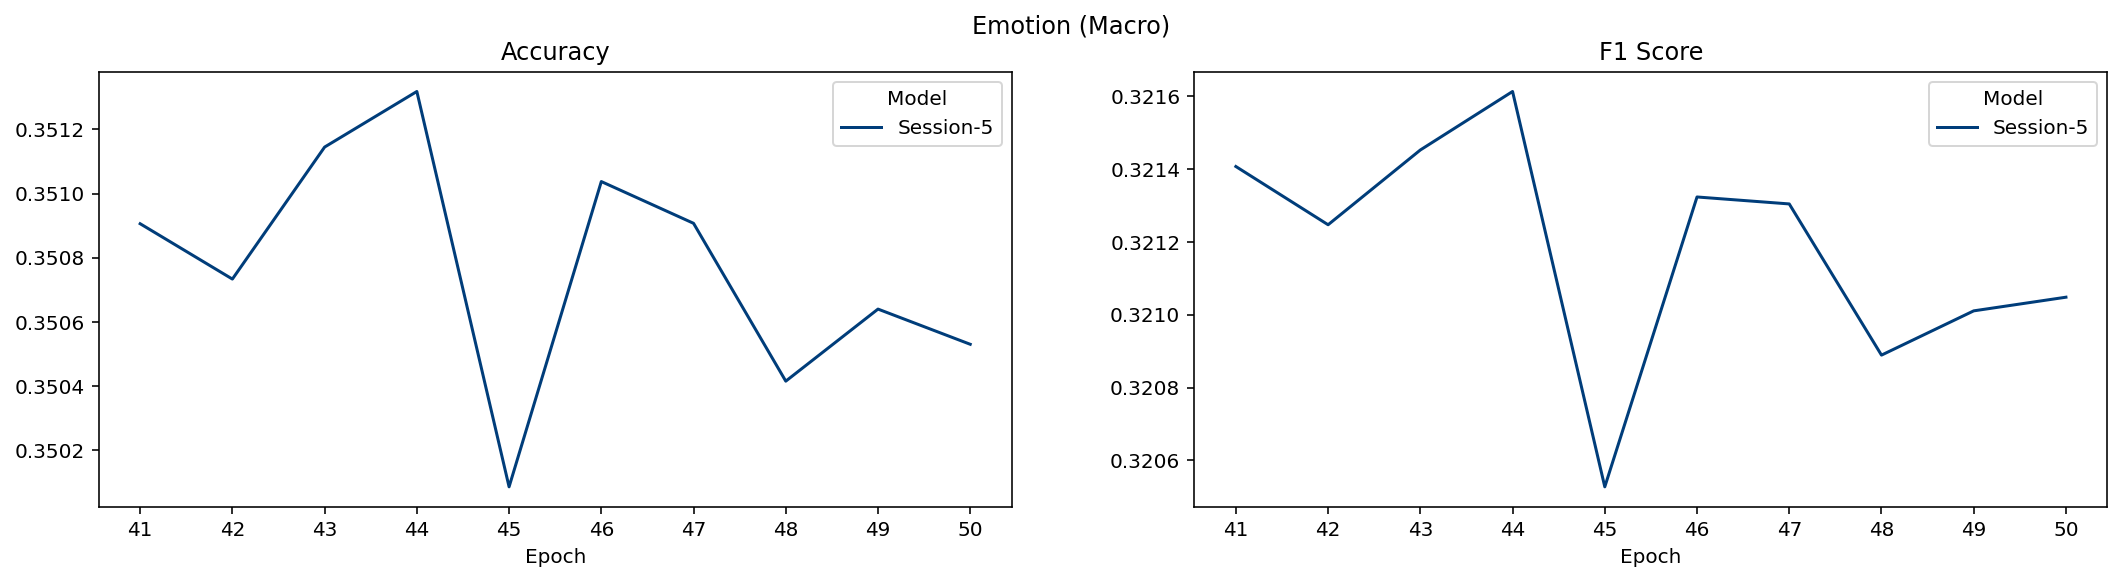

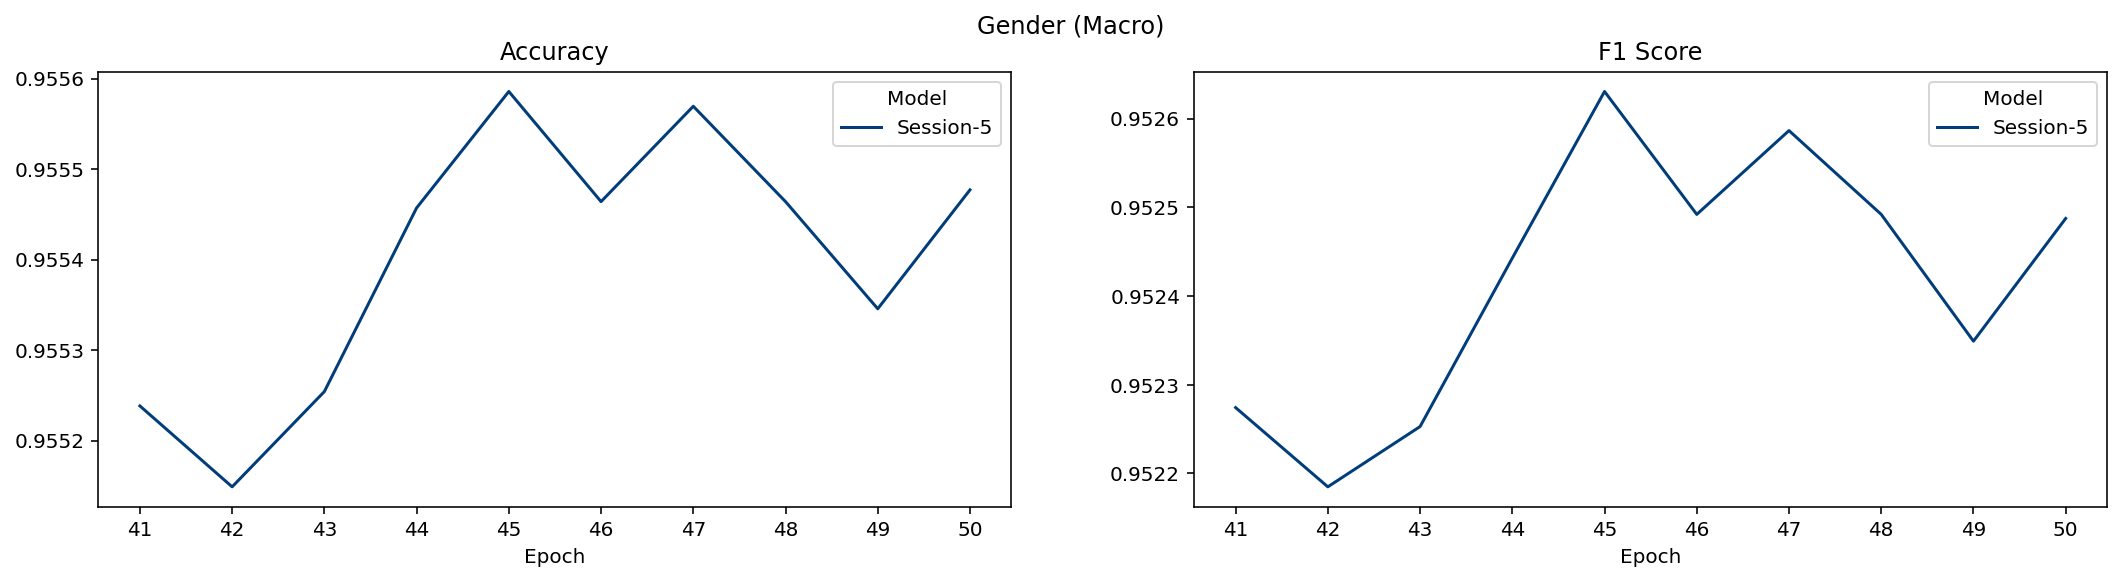

In [ ]:
plot_train_classification(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, average= 'macro', x_jump = 1)

#### Step 5:
Plotting the regression metrics.

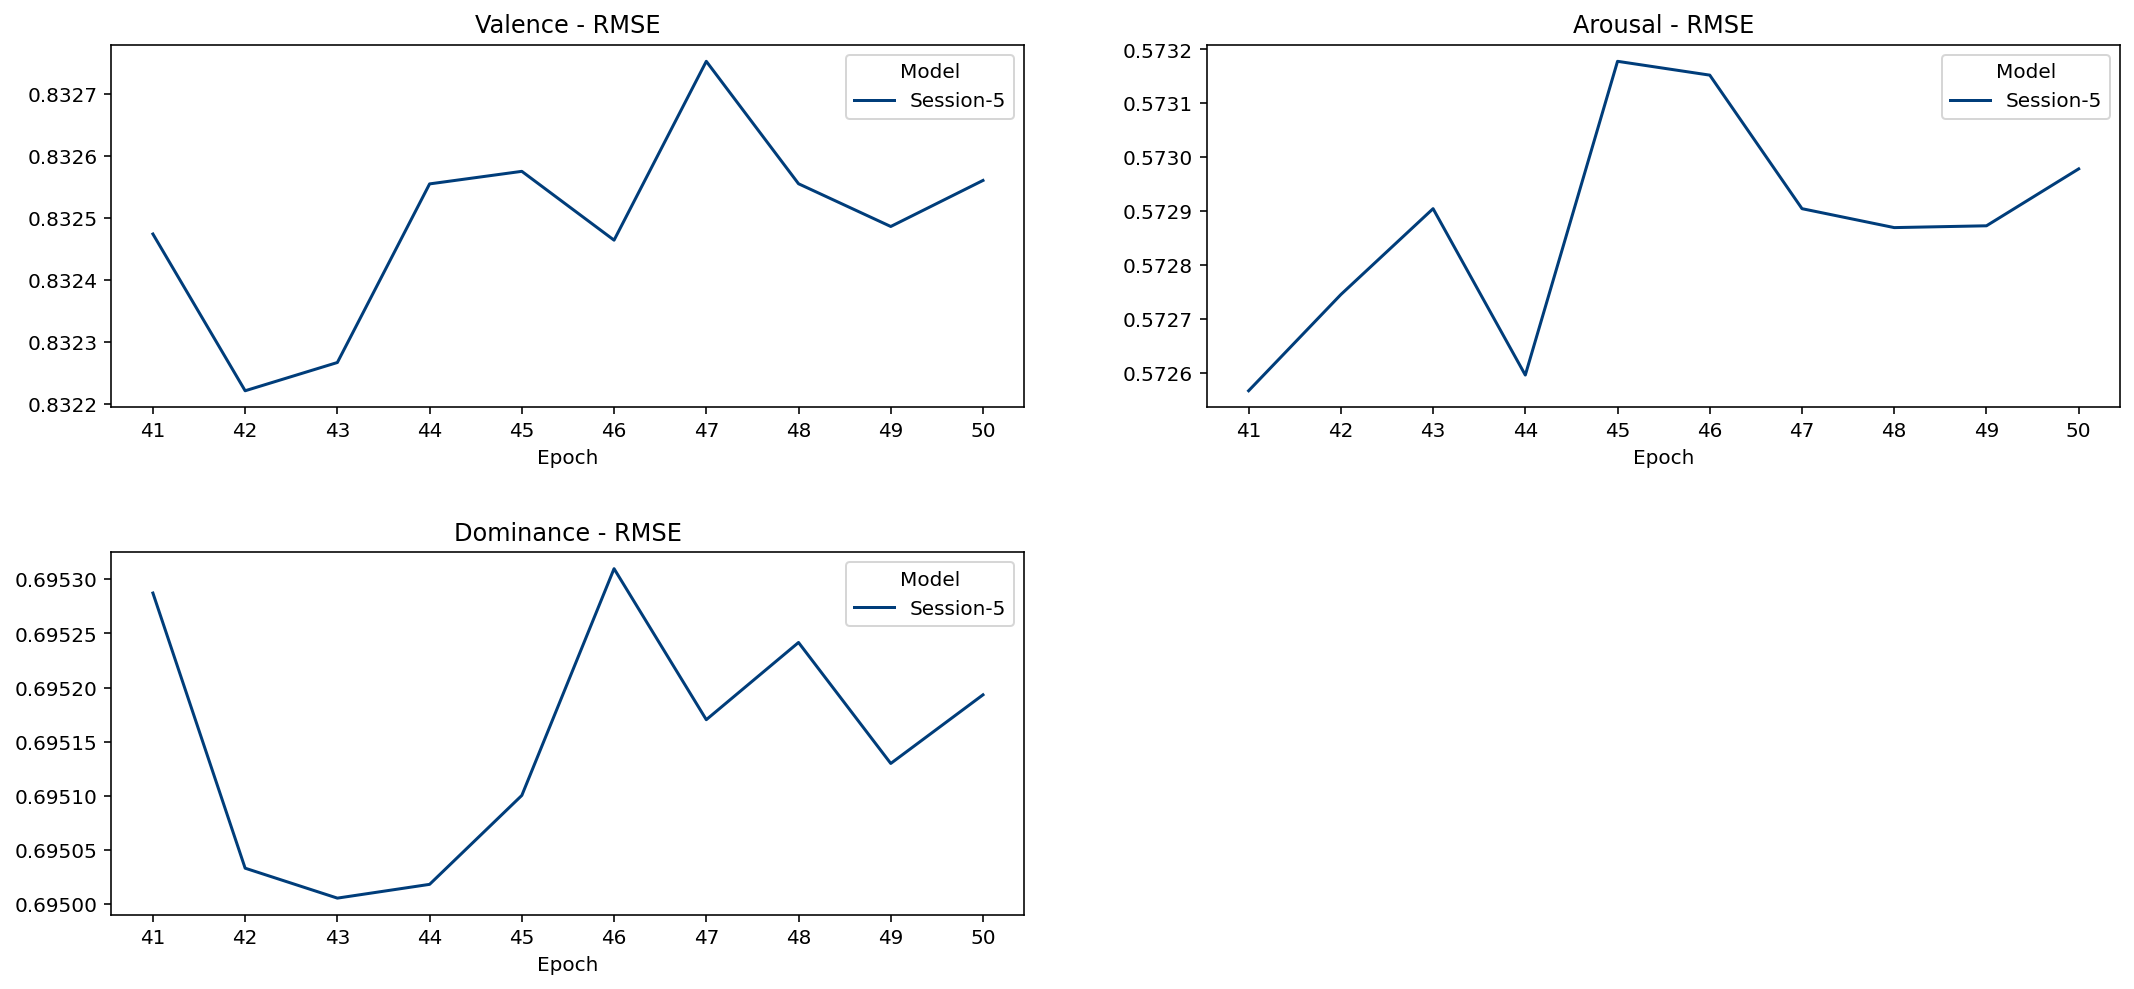

In [ ]:
plot_train_regression(checkpoint, f'Session-{checkpoint_num}', best_epoch, checkpoint_num, epoch_size, x_jump = 1)

#### Step 6:
Saving the checkpoint and current best model.

In [ ]:
!zip -r 'IEMOCAP Meta.zip' 'IEMOCAP Meta'
!cp 'IEMOCAP Meta.zip' '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip'

<a id='comb_sessions'></a>
## Combining Sessions
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Combining the data from all checkpoints.

In [ ]:
checkpoint = torch.load(f'{meta_root}/Checkpoint-1.pt', map_location = torch.device('cpu'))
best_model = torch.load(f'{meta_root}/Best.pt', map_location = torch.device('cpu'))
best_epoch = best_model['current epoch']

epoch_size = 10
min, max = 1, 5

all_checkpoints = combine_data(meta_root, checkpoint, min, max)

#### Step 2:
Plotting the loss curves of the trained model with a marker of the best model.

In [ ]:
plot_train_loss(all_checkpoints, 'All Sessions', best_epoch, checkpoint_num = 1, epoch_size = epoch_size * max, x_jump = 5)

#### Step 3:
Plotting the classification metrics.
> `average` - weighted and macro.

In [ ]:
plot_train_classification(all_checkpoints, 'All Sessions', best_epoch, checkpoint_num = 1, epoch_size = epoch_size * max, average= 'weighted', x_jump = 5)

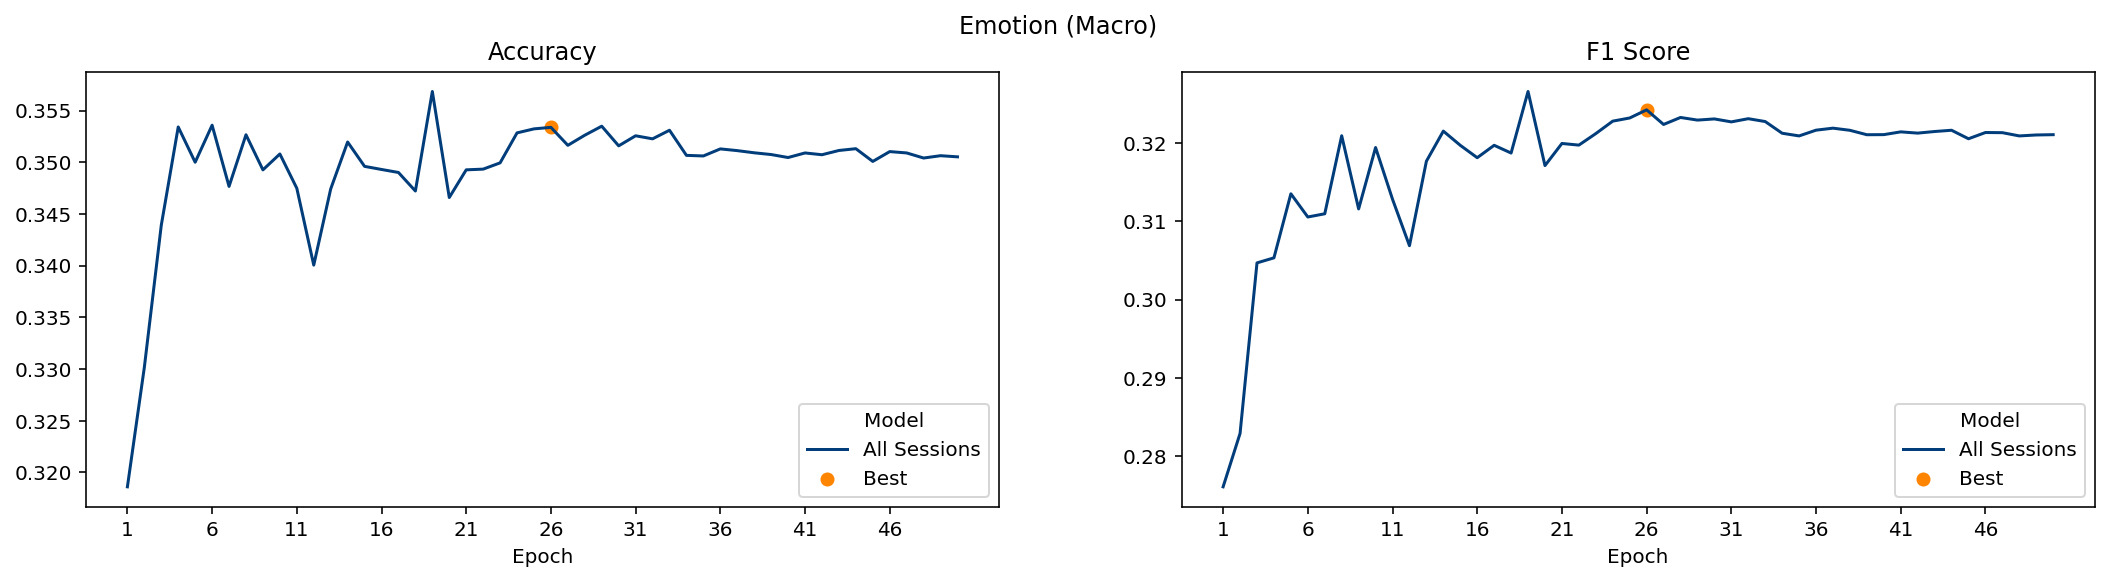

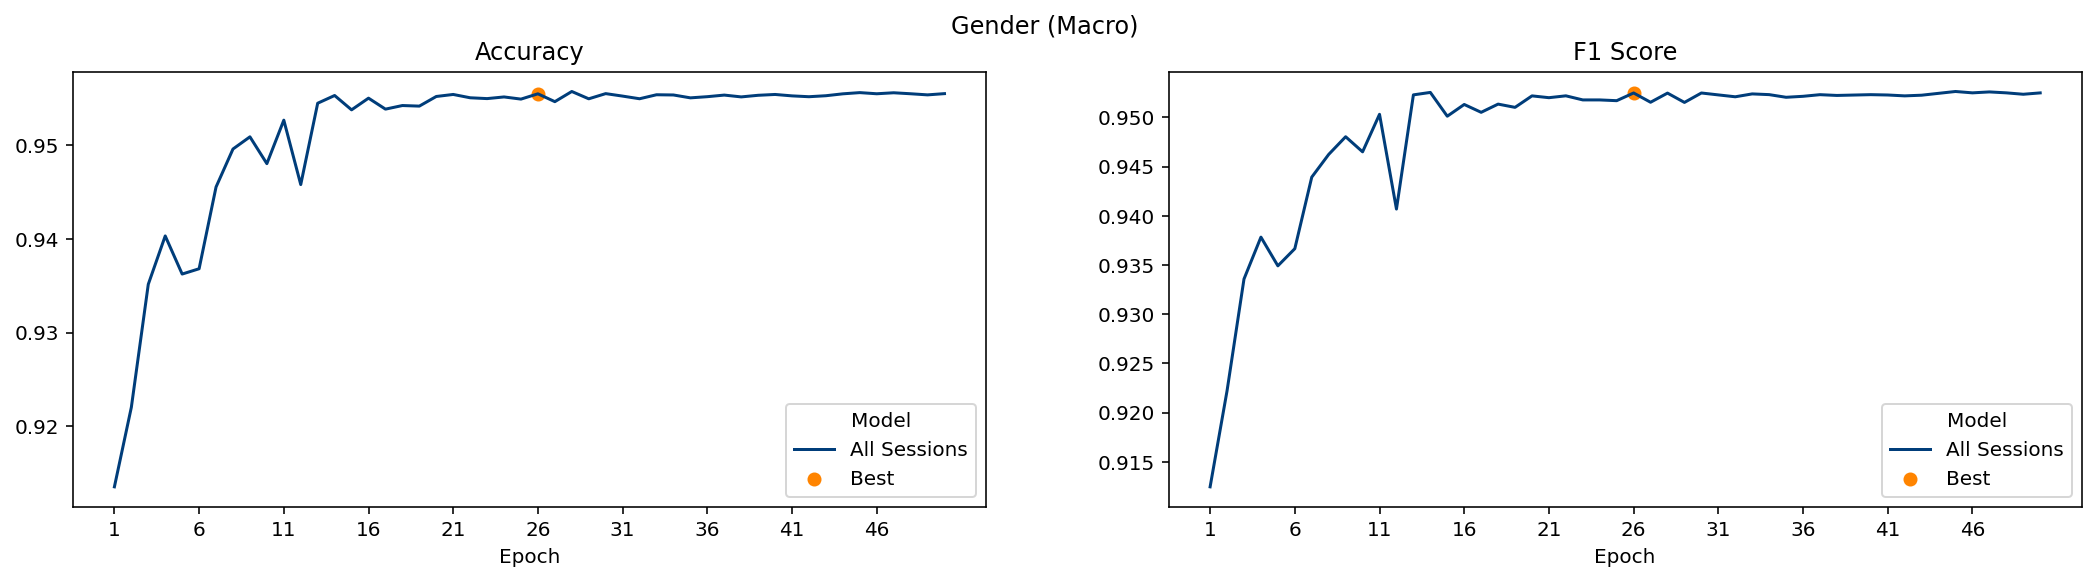

In [ ]:
plot_train_classification(all_checkpoints, 'All Sessions', best_epoch, checkpoint_num = 1, epoch_size = epoch_size * max, average= 'macro', x_jump = 5)

#### Step 4:
Plotting the regression metrics.

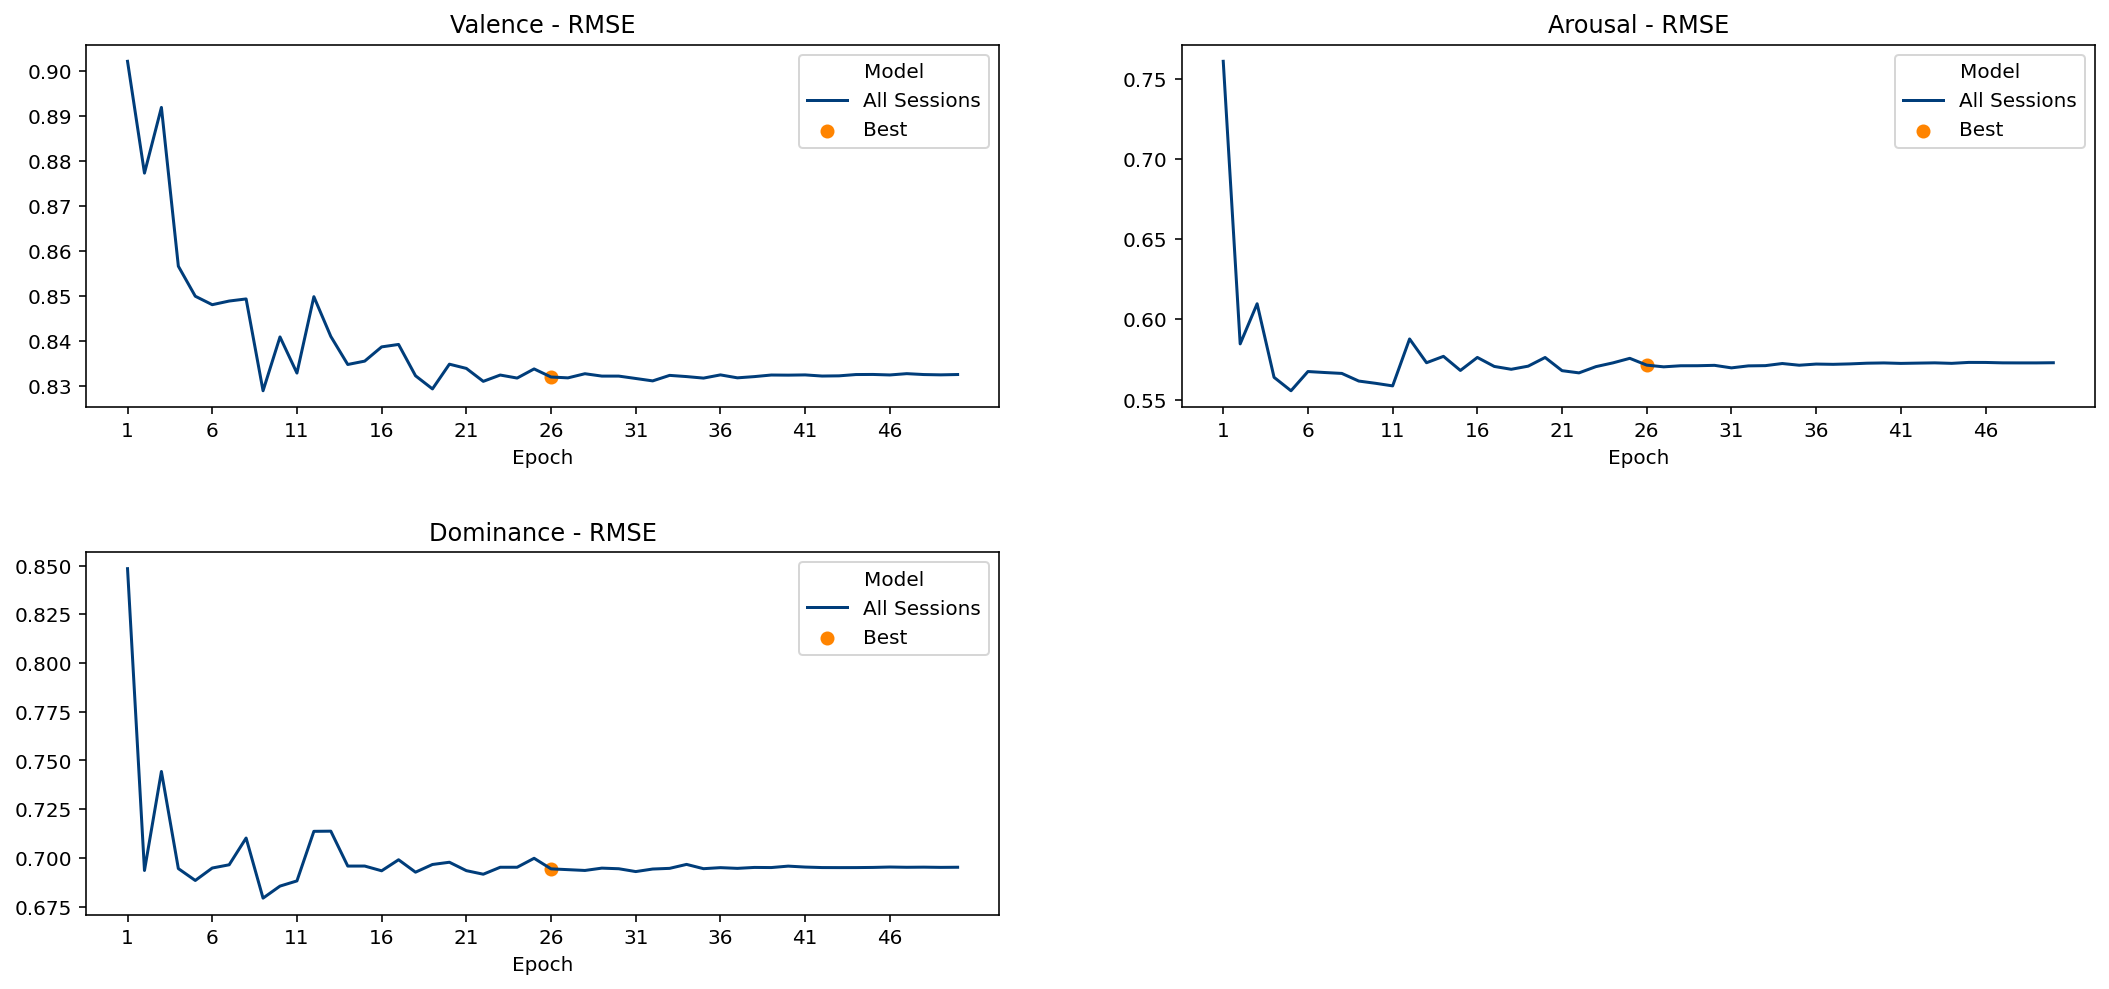

In [ ]:
plot_train_regression(all_checkpoints, 'All Sessions', best_epoch, checkpoint_num = 1, epoch_size = epoch_size * max,  x_jump = 5)

#### Step 5:
Plotting the classification metrics per class for the best model.

In [ ]:
plot_per_class(best_model, tuple(class_data.keys())[:-2], 'Emotion')

In [ ]:
plot_per_class(best_model, tuple(class_data.keys())[-2:], 'Gender')

#### Step 6:
Plotting the confusion matrix of the best model.

In [ ]:
plot_confusion_matrix(best_model['confusion matrix'][0], tuple(class_labels.keys()), 'Emotions', fig_size = (12,4), wspace = 0.3)

In [ ]:
plot_confusion_matrix(best_model['confusion matrix'][1], ('Male', 'Female'), 'Genders', fig_size = (8,2), wspace = 0.3)

<a id='post_viz'></a>
## Post-training Visualization
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
In this section, we visualize the following -
- Filters of the convolutional layers.
- Feature maps.
- Attention weights.

#### Step 1:
Loading the best performing model.

In [ ]:
best_model = torch.load(f'{meta_root}/Best.pt', map_location=torch.device('cpu'))
model.load_state_dict(best_model['model'])

<All keys matched successfully>

#### Step 2:
Displaying the learned weights of the auxiliary task losses.

In [ ]:
tasks = ['Gender', 'Valence', 'Activation', 'Dominance']
for i in range(len(tasks)):
  print(f'{tasks[i]}: {model.log_vars[i]:.04f}')

Gender: 2.8347
Valence: -0.8029
Activation: -1.0831
Dominance: -0.9487


#### Step 3:
Plotting the filters of the first and second convolutional layers.

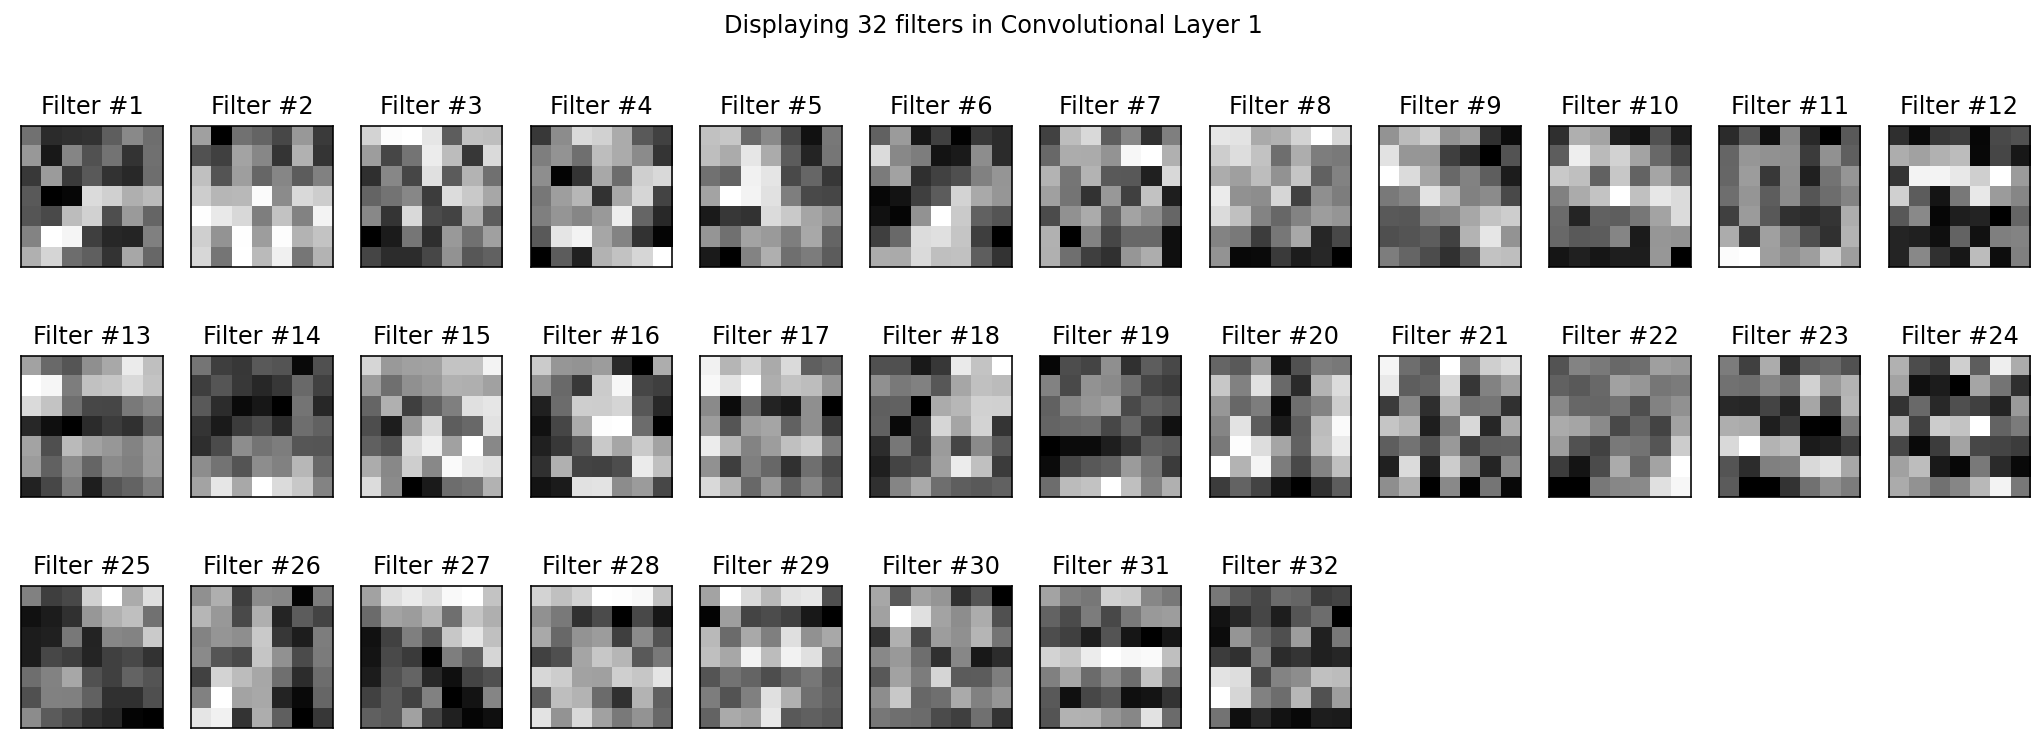

In [ ]:
plot_maps((model, 1), plot_type = 'filters', fig_size = (18, 6))

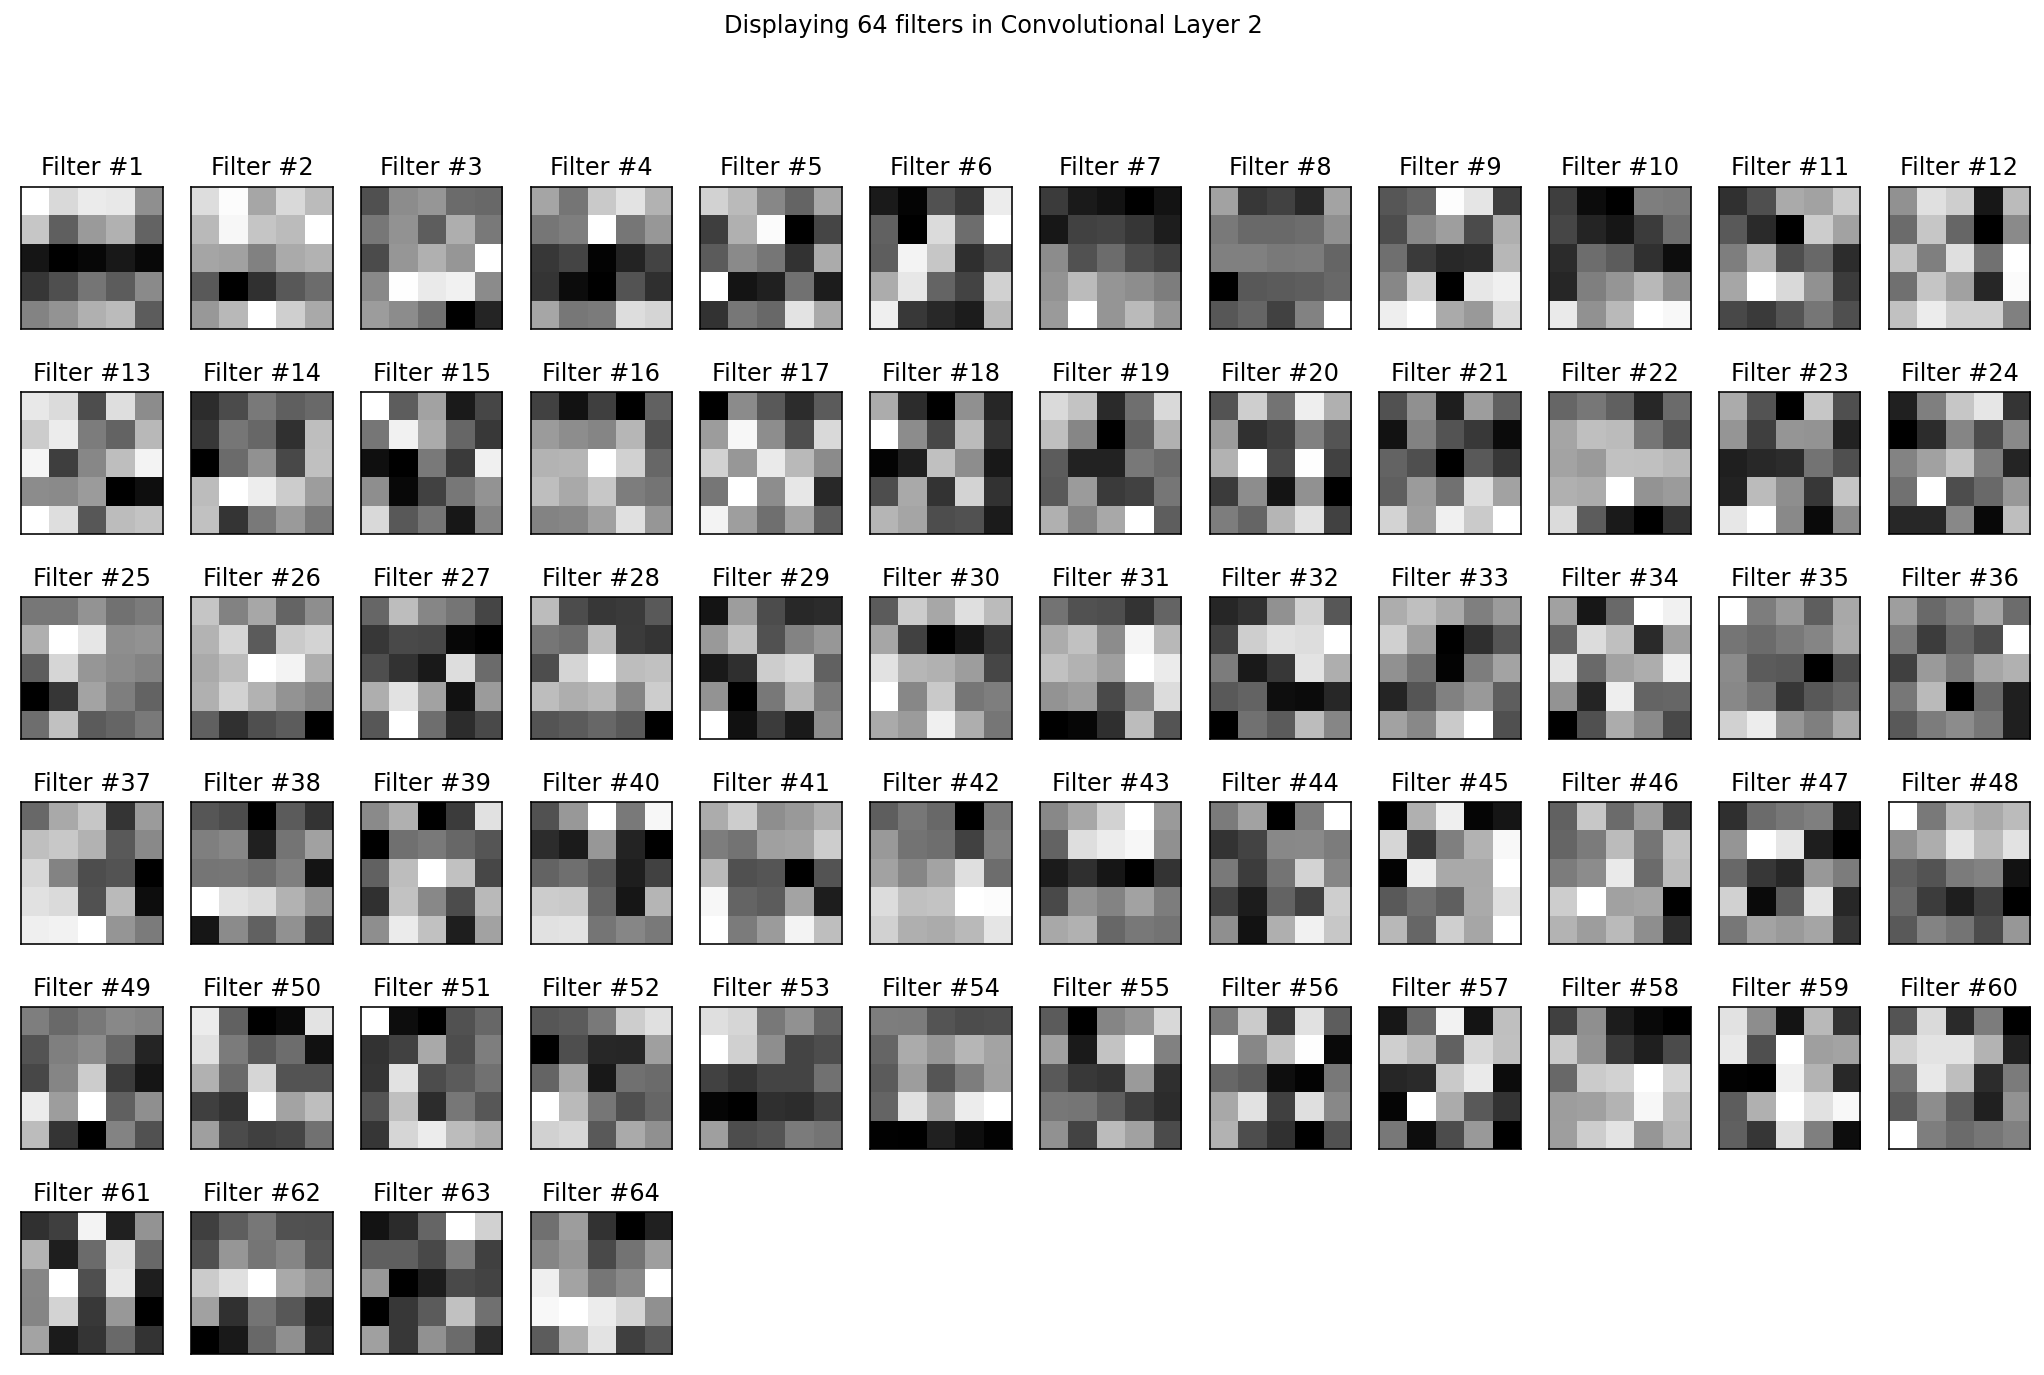

In [ ]:
plot_maps((model, 2), plot_type = 'filters', fig_size = (18, 11))

#### Step 4:
Obtainin the feature maps and attention weights for a random image.

In [ ]:
img, img_tensor, attention, feature_maps = get_feature_maps(root, model, split_data, 'train', label_data, all_transforms)

#### Step 5:
Displaying the -
- Image.
- Feature Maps.
- Attention Weights.

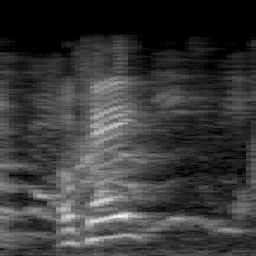

In [ ]:
display(img)

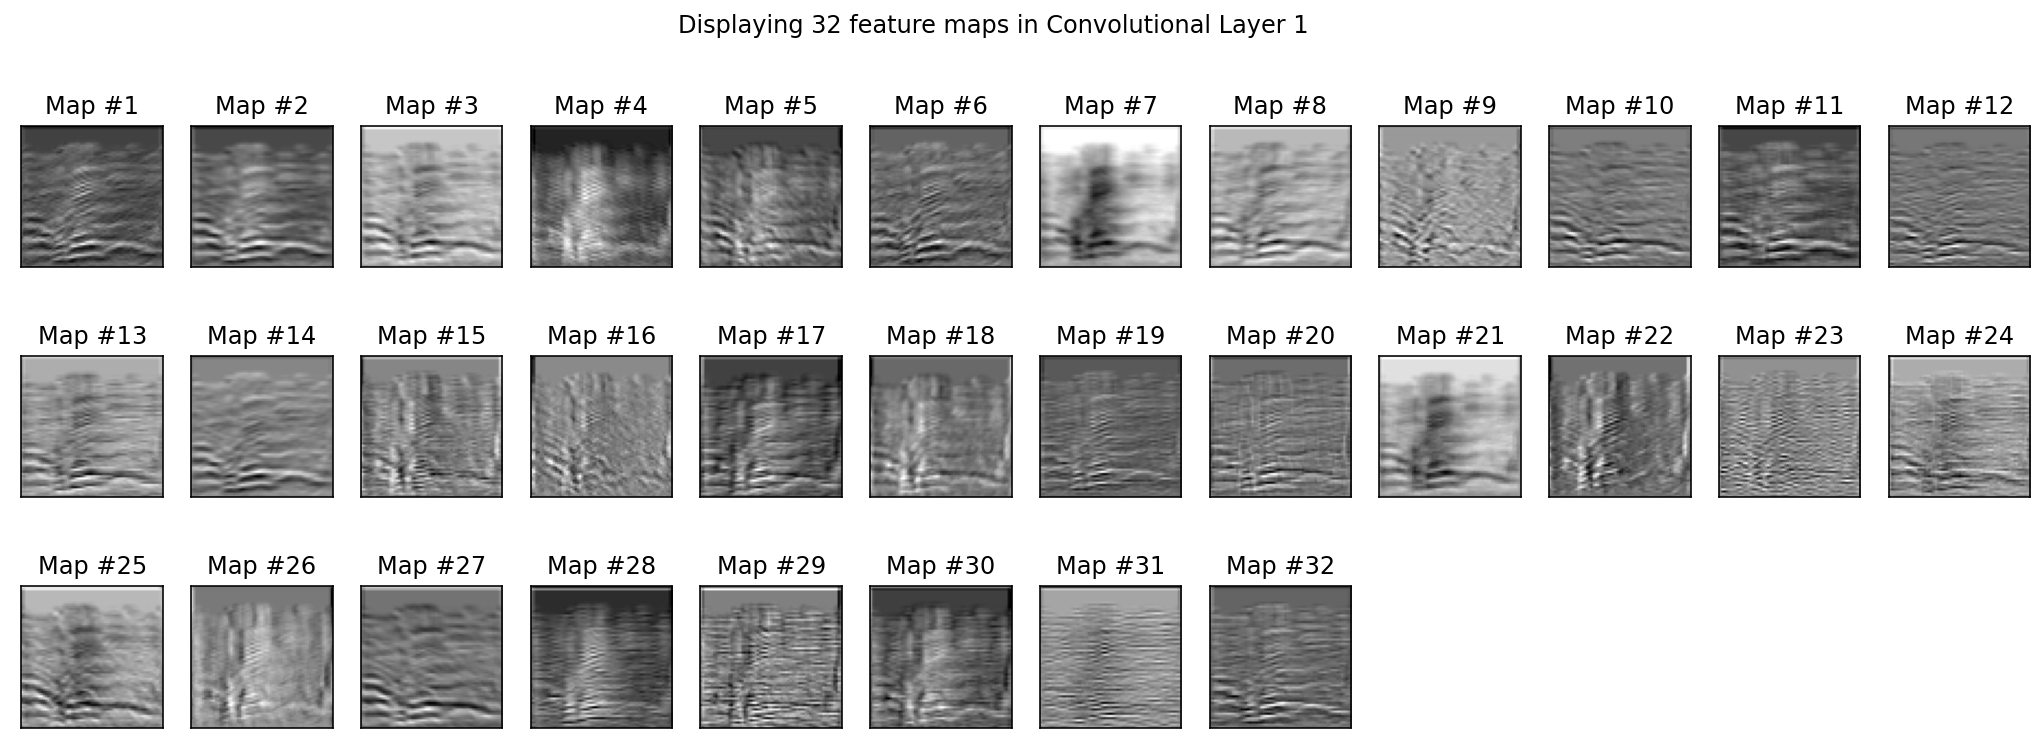

In [ ]:
plot_maps((feature_maps, 0), plot_type = 'feature', fig_size = (18, 6))

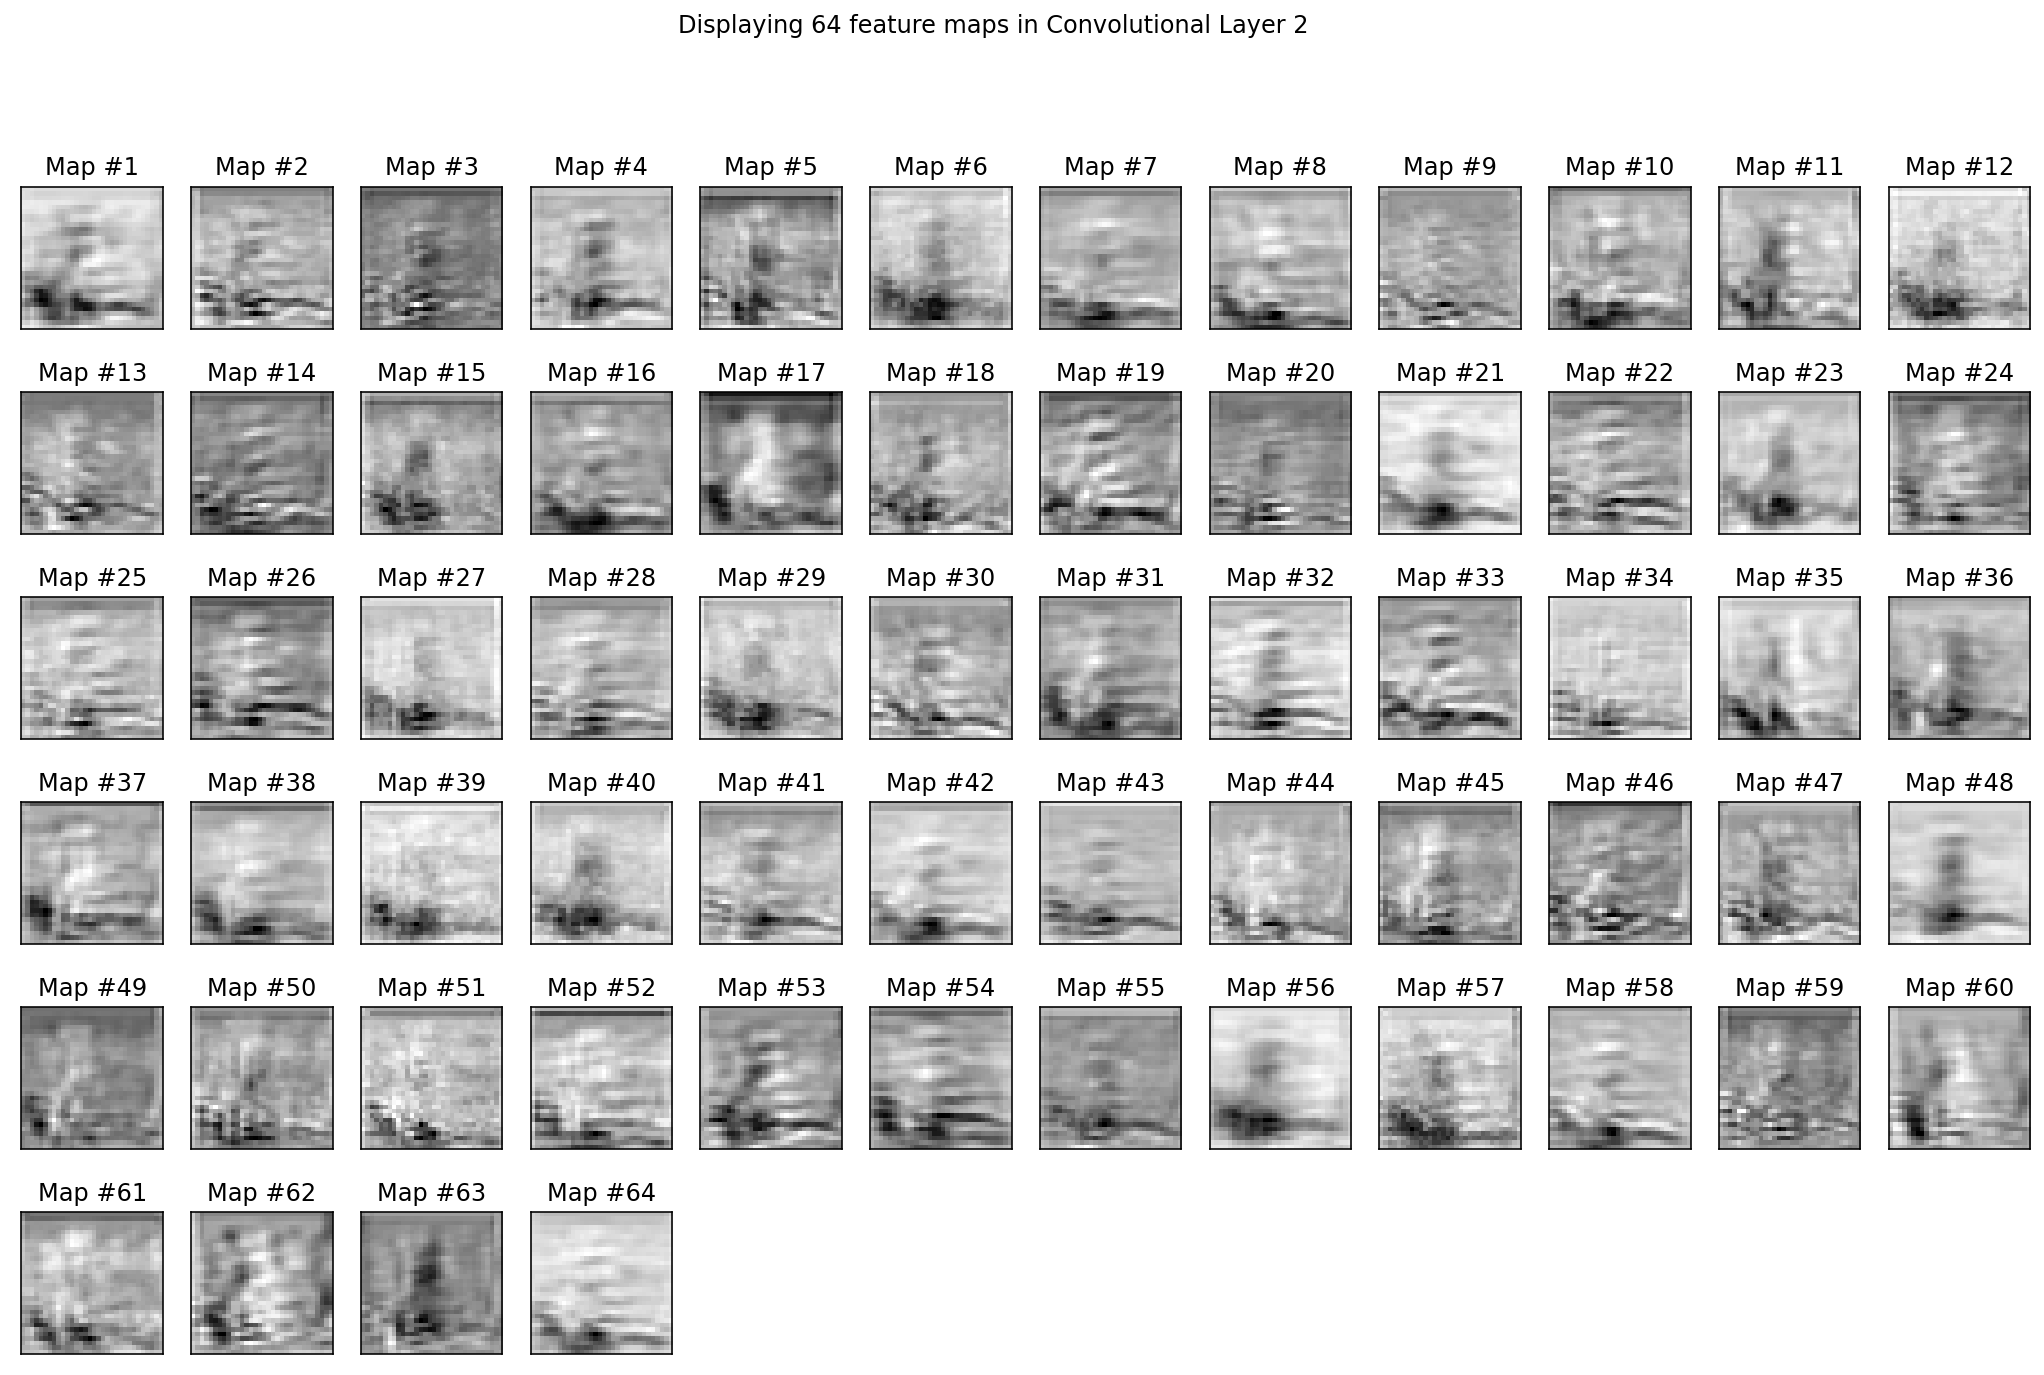

In [ ]:
plot_maps((feature_maps, 1), plot_type = 'feature', fig_size = (18, 11))

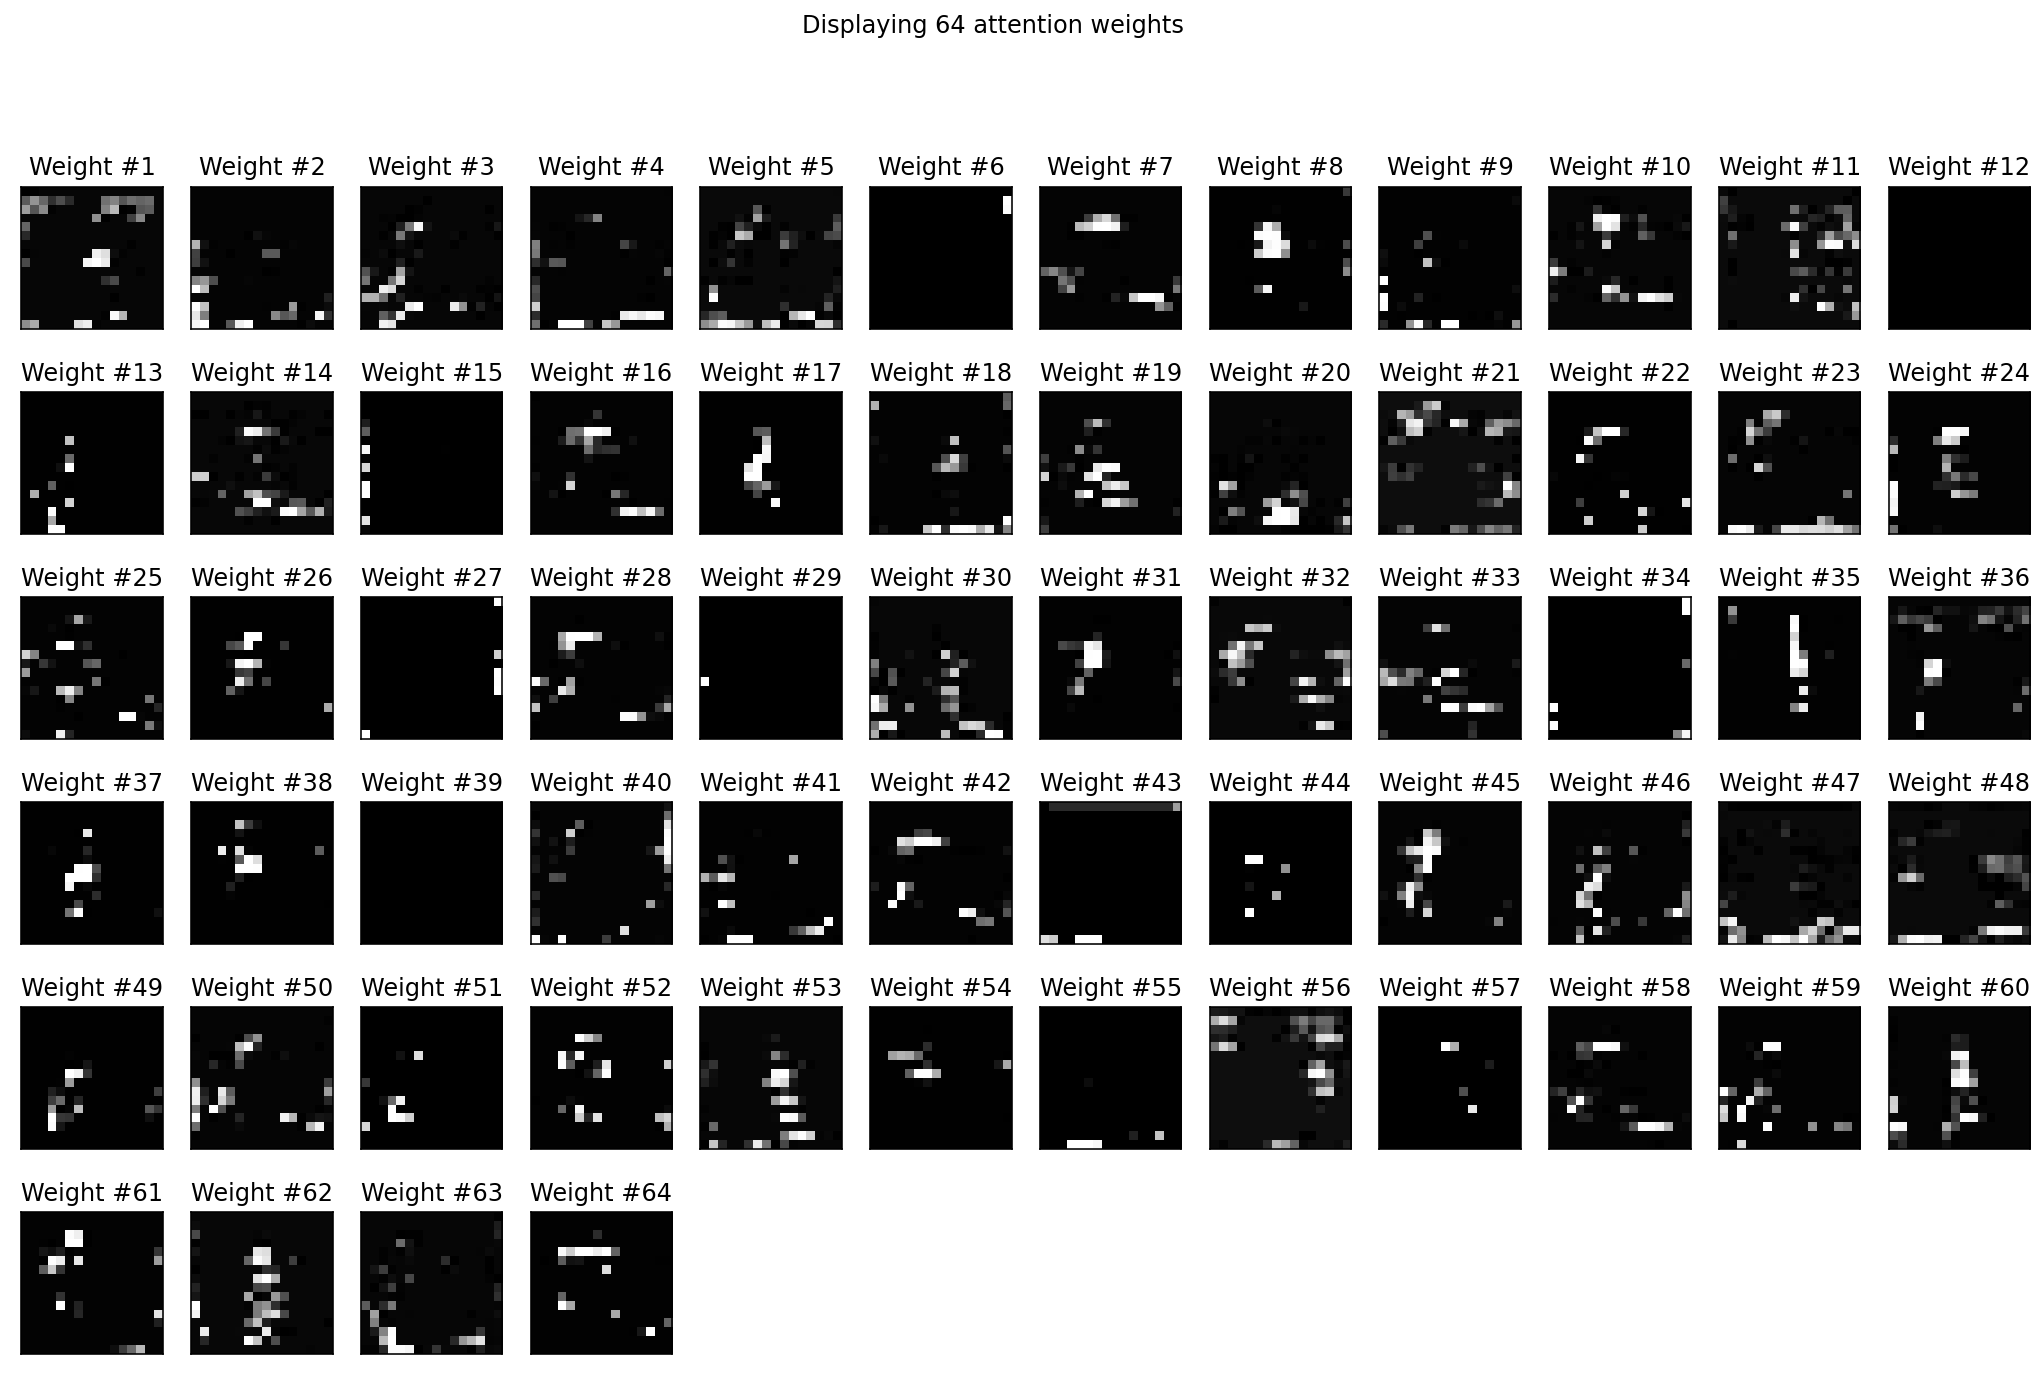

In [ ]:
plot_maps((attention, 1), plot_type = 'attention', fig_size = (18, 11))